In [1]:
from icecube import dataclasses, dataio, icetray, simclasses
from glob import glob
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm

In [3]:
def get_mcpe_maps(directory):
    
    '''
    Appending MCPE Maps from all the frames
    '''
    
    if directory == 'Original':
        files = sorted(glob('../I3Files/step3CodeTestOriginalGeo/simple_track_posChanged_step3_*.i3.gz'))
    if directory == 'Changed':
        files = sorted(glob('../I3Files/step3CodeTestUpdatedGeo/simple_track_posChanged_step3_*.i3.gz'))
    if directory == 'DEgg Changed':
        files = sorted(glob('../I3Files/step3_DEgg_UpdatedCode/simple_track_posChanged_step3_*.i3.gz'))
    if directory == 'mDOM Changed':
        files = sorted(glob('../I3Files/step3_mDOM_UpdatedCode/simple_track_posChanged_step3_*.i3.gz'))
    
    icecube_mcpe, mdom_mcpe, degg_mcpe, pdom_mcpe = [], [], [], []
    for file in files[0:100]:
        infile = dataio.I3File(file)

        while infile.more():
            frame = infile.pop_frame()
            if "I3MCPESeriesMap_IceCube" in frame:
                icecube_mcpe.append(frame["I3MCPESeriesMap_IceCube"])
                mdom_mcpe.append(frame["I3MCPESeriesMap_mDOM"])
                degg_mcpe.append(frame["I3MCPESeriesMap_DEgg"])
                pdom_mcpe.append(frame["I3MCPESeriesMap_PDOM"])
                
    return icecube_mcpe, mdom_mcpe, degg_mcpe, pdom_mcpe

In [4]:
icecube_mcpe, mdom_mcpe, degg_mcpe, pdom_mcpe = get_mcpe_maps(directory='Original')

In [5]:
icecube_mcpeC, mdom_mcpeC, degg_mcpeC, pdom_mcpeC = get_mcpe_maps(directory='Changed')

In [2]:
def get_omkey_id():
    '''
    storing all omkeys as a list
    '''
    file = dataio.I3File('/mnt/c/Users/akank/IceCube_Software/i3/icetray/scripts/init_tests_021423/GCD/GeoCalibDetectorStatus_ICUpgrade.v58.mixed.V0.i3.bz2')
    frame = file.pop_frame()
    geometry = frame["I3Geometry"]
    omgeo = geometry.omgeo
    
    omkeys = []
    for i in omgeo.keys():
        omkeys.append(i)
    return omkeys

In [3]:
geo_omkeys = get_omkey_id()

In [4]:
len(geo_omkeys)

15707

In [1]:
def get_hits(dom_mcpe, geo_omkeys):
    '''
    getting the number of hits in each omkey in the string 
    '''
    strings = [79, 92, 93]
    pmts = [1, 4, 8, 13, 17, 20]
    hits, omkey_ids = [], []
    for mcpe_map in dom_mcpe:
        for omkey, mcpe  in mcpe_map.items():
            if omkey[0] in strings:
                #if omkey[2] in pmts:
                if len(mcpe) >= 0:
                    id_ = geo_omkeys.index(omkey) #each omkey has a unique index. Storing this index as an id
                    hits.append(len(mcpe))
                    omkey_ids.append(id_)
    return hits, omkey_ids

In [8]:
hits, ids = get_hits(degg_mcpe, geo_omkeys)

In [47]:
hitsC, idsC = get_hits(degg_mcpeC, geo_omkeys)

In [48]:
hits = np.array(hits)
ids = np.array(ids)

hitsC=np.array(hitsC)
idsC = np.array(idsC)

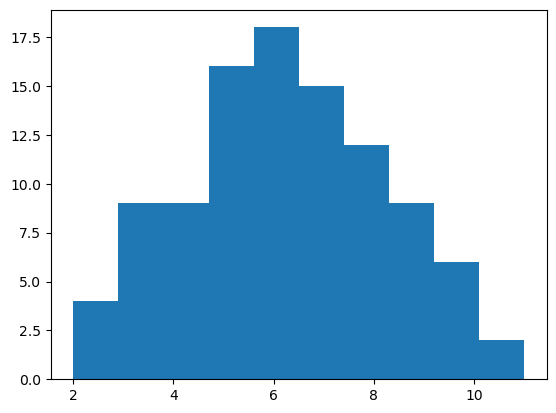

In [49]:
plt.hist(hits[ids==ids[10000]])
val=hits[ids==ids[10000]]
valC=hitsC[idsC==idsC[10000]]

In [50]:
mean = sum(val)/100
std = np.sqrt(sum((val-mean)**2)/100)
se = std/np.sqrt(100)

meanC = sum(valC)/100
stdC = np.sqrt(sum((valC-meanC)**2)/100)
seC = stdC/np.sqrt(100)

In [51]:
pos_err = np.sqrt(mean/100)
pos_errC = np.sqrt(meanC/100)

In [52]:
(mean/meanC)*np.sqrt((pos_err/mean)**2+(pos_errC/meanC)**2)

0.25669524061644394

In [53]:
(mean/meanC)*np.sqrt((se/mean)**2+(seC/meanC)**2)

0.20921751484896206

In [54]:
(mean/meanC)*((se/mean) - (seC/meanC))

-0.06659134716155601

In [51]:
(se/mean)**2

0.001241107982139958

In [9]:
def get_avg_hits(hits, omkeys, omkeysC):
    
    """
    calculating the average number of hits
    """
    
    hits_array = np.array(hits)
    omkeys_array = np.array(omkeys)
    
    mean_val, mean_error_val = [], []
    key_val = list(set(omkeys + omkeysC)) #creating a list of the omkey indices. Each index appears only once
    key_val.sort()
    
    num_events = 100
    pmt = []
    for key in key_val:
        key_hits = hits_array[omkeys_array==key]
        if len(key_hits) > 0:  
            mean = sum(key_hits)/num_events
            if len(key_hits) < num_events:
                key_hitsAdd = np.pad(key_hits, (0, 100-len(key_hits)), 'constant')
                std_mean = np.sqrt(sum((key_hitsAdd-mean)**2)/num_events)
            else:
                std_mean = np.sqrt(sum((key_hits-mean)**2)/num_events)
            mean_err = std_mean/np.sqrt(num_events)
        else:
            mean = 0
            error = 0
            mean_err = 0
            
        mean_val.append(mean)
        mean_error_val.append(mean_err)
        pmt.append(key)
        
    mean_val = np.array(mean_val)
    key_val = np.array(pmt) #np.array(key_val)
    mean_error_val = np.array(mean_error_val)
    
    return mean_val, key_val, mean_error_val

In [10]:
def get_plot(dom_mcpe, dom_mcpeC, above, plt_title):
    
    hits, sum_omkeys = get_hits(dom_mcpe, geo_omkeys) 
    hitsC, sum_omkeysC = get_hits(dom_mcpeC, geo_omkeys)
    
    mean_val, key_val, mean_error_val = get_avg_hits(hits, sum_omkeys, sum_omkeysC)
    mean_valC, key_valC, mean_error_valC = get_avg_hits(hitsC, sum_omkeysC, sum_omkeys)
    
    plt.plot(mean_val, mean_valC, '.')
    plt.show()
    
    boolean = mean_valC>=above
    
    A = mean_valC[boolean]
    B = mean_val[boolean]
    
    A_err = mean_error_valC[boolean]
    B_err = mean_error_val[boolean]

    mean_ratio = A/B
    
    if plt_title == 'IceCube':
        
        rat_bool = mean_ratio>1.3
        A = A[rat_bool]
        B = B[rat_bool]
        
        A_err = A_err[rat_bool]
        B_err = B_err[rat_bool]
        
        mean_ratio = mean_ratio[rat_bool]
        
        r = sum((A-np.mean(A))*(B-np.mean(B)))/np.sqrt(sum((A-np.mean(A))**2)*sum((B-np.mean(B))**2))
        sigma_ab = r*A_err*B_err
        covariance_term = (2*sigma_ab/(A*B))
        print(r)
        mean_ratioErr = mean_ratio*np.sqrt((A_err/A)**2 + (B_err/B)**2 - covariance_term)
        print(mean_ratioErr)
        
        mean_of_mean = np.mean(mean_ratio)
        err_on_mean = np.std(mean_ratio)#/np.sqrt(len(mean_ratio))

        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [2.7, 1]}, figsize=(15,6))
        ax0.errorbar(key_val[boolean][rat_bool], B,
                    yerr=B_err,
                    fmt='o', label = 'Original Geometry')
        ax0.errorbar(key_valC[boolean][rat_bool], A,
                    yerr=A_err,
                    fmt='o', label = 'Increased Efficiency')
        #ax0.set_xlabel('pmt', fontsize=10)
        ax0.set_ylabel('average hits', fontsize=10)
        ax0.set_title(str(plt_title), fontsize=11)
        ax0.legend()

        ax1.errorbar(key_val[boolean][rat_bool], mean_ratio,
                    yerr=mean_ratioErr,
                    fmt='o', label = 'ratio', color='black')
        ax1.axhline(y=mean_of_mean, color ='red', lw = 2, label = 'mean')
        ax1.fill_between(key_val[boolean][rat_bool], mean_of_mean-err_on_mean, mean_of_mean+err_on_mean, facecolor='skyblue', alpha=.5)
        ax1.set_xlabel('pmt', fontsize=10)
        ax1.set_ylabel('ratio', fontsize=10)
        #ax1.grid()
        ax1.legend()

        plt.savefig('./'+str(plt_title)+'.png', dpi = 200, bbox_inches='tight')
        plt.show()
        
    else:
        '''
        covariance
        '''
        r = sum((A-np.mean(A))*(B-np.mean(B)))/np.sqrt(sum((A-np.mean(A))**2)*sum((B-np.mean(B))**2))
        sigma_ab = r*A_err*B_err#(1/len(A))*sum((A-np.mean(A))*(B-np.mean(B)))
        covariance_term = (2*sigma_ab/(A*B))
        print(r)
        mean_ratioErr = mean_ratio*np.sqrt((A_err/A)**2 + (B_err/B)**2 )#- covariance_term)
        print(mean_ratio)
        print(mean_ratioErr)
    
        mean_of_mean = np.mean(mean_ratio)
        err_on_mean = np.std(mean_ratio)#/np.sqrt(len(mean_ratio))

        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [2.7, 1]}, figsize=(15,6))
        ax0.errorbar(key_val[boolean], B,
                    yerr=B_err,
                    fmt='o', label = 'Original Geometry')
        ax0.errorbar(key_valC[boolean], A,
                    yerr=A_err,
                    fmt='o', label = 'Increased Efficiency')
        #ax0.set_xlabel('pmt', fontsize=10)
        ax0.set_ylabel('average hits', fontsize=10)
        ax0.set_title(str(plt_title), fontsize=11)
        ax0.legend()

        '''
        ax1.errorbar(key_val[boolean], mean_ratio,
                    yerr=mean_ratioErr,
                    fmt='o', label = 'ratio', color='black')
        '''
        ax1.errorbar(key_val[boolean], mean_ratio,
                    fmt='o', label = 'ratio', color='black')
        ax1.axhline(y=mean_of_mean, color ='red', lw = 2, label = 'mean')
        ax1.fill_between(key_val[boolean], mean_of_mean-err_on_mean, mean_of_mean+err_on_mean, facecolor='skyblue', alpha=.5)
        ax1.set_xlabel('pmt', fontsize=10)
        ax1.set_ylabel('ratio', fontsize=10)
        #ax1.grid()
        ax1.legend()

        plt.savefig('./'+str(plt_title)+'.png', dpi = 200, bbox_inches='tight')
        plt.show()

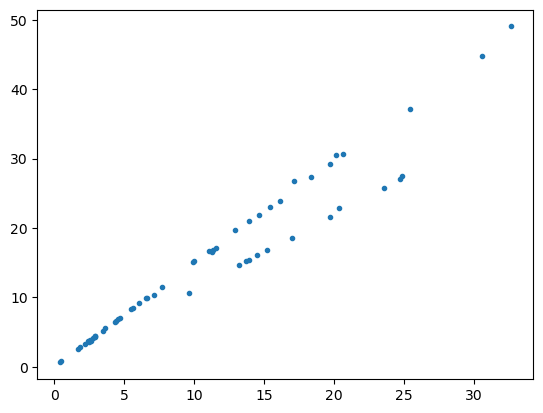

0.9991951001534848
[0.00680438 0.00761115 0.00777648 0.00853925 0.00469274 0.00479813
 0.00858934 0.00578044 0.00938945 0.00755624 0.00852402 0.00823666
 0.0065666  0.01204304 0.00612375 0.00749102 0.00297648 0.00836243
 0.00664747 0.01194611 0.01256517]


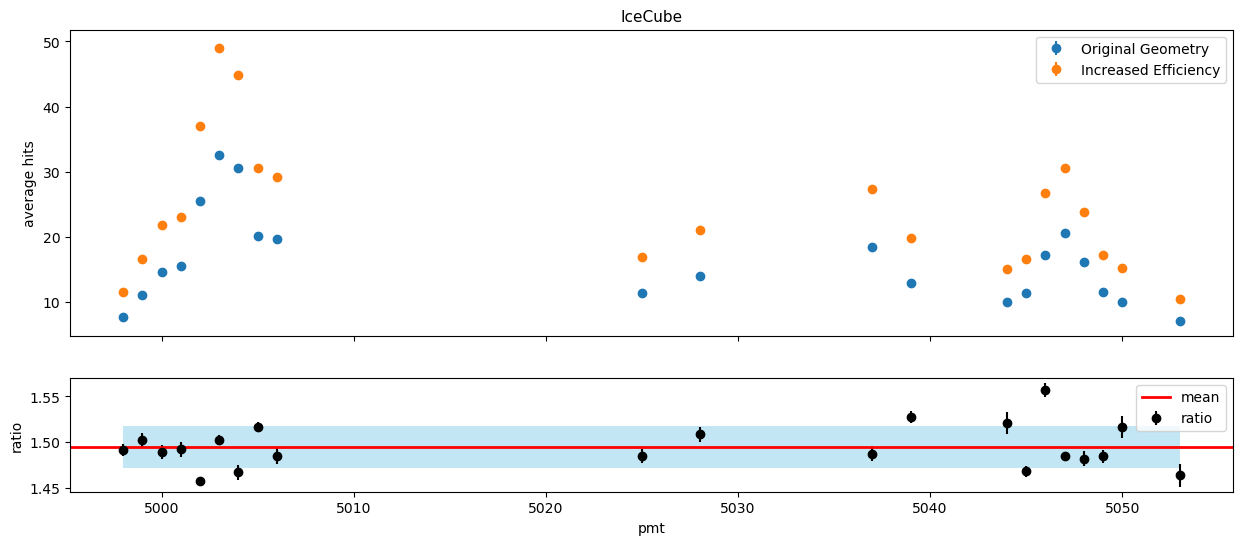

In [11]:
get_plot(icecube_mcpe, icecube_mcpeC, 10, 'IceCube')

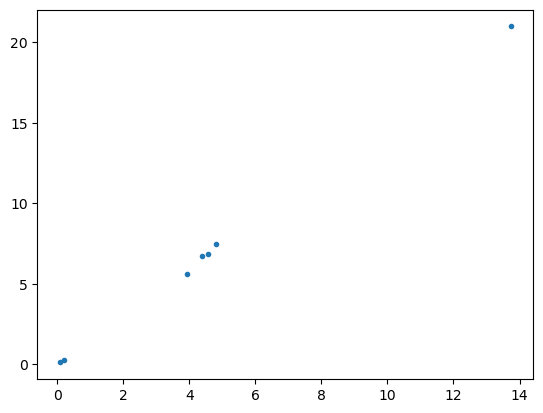

0.9995729645633857
[1.52692868 1.53424658 1.42493639 1.54677755 1.49890591]
[0.04958312 0.0887975  0.09426757 0.08606376 0.08774692]


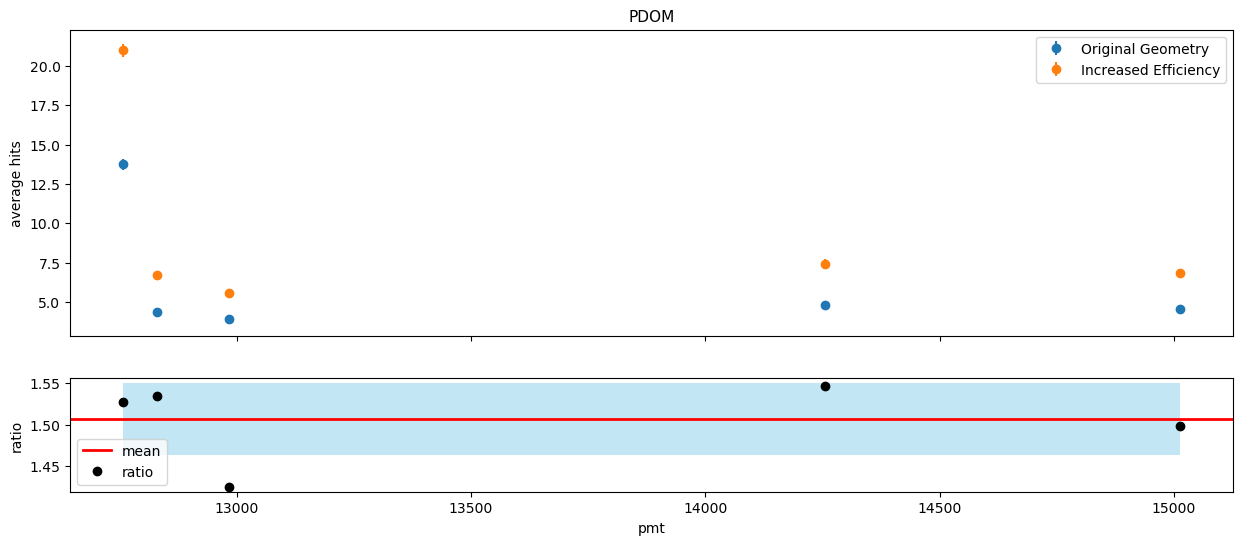

In [12]:
get_plot(pdom_mcpe, pdom_mcpeC, 1, 'PDOM')

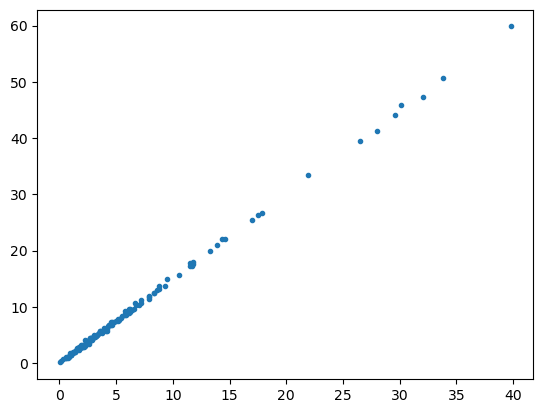

0.9996776178905173
[1.54709141 1.52542373 1.48622754 1.48295455 1.54308094 1.49775785
 1.47458684 1.47670251 1.50228311 1.48040455 1.5349162  1.51261716
 1.52374429 1.50187829 1.51440329 1.48548813 1.50313991 1.48148148
 1.48818366 1.50126904 1.50428327 1.50915432 1.51928783 1.47216274
 1.47480786 1.49234393 1.49748595 1.45489199 1.52292359 1.56363636
 1.47571429 1.5658588  1.52037253 1.50042481 1.49513213 1.58507463]
[0.06722989 0.0574242  0.06014638 0.05981704 0.05650322 0.04163548
 0.03036089 0.06046076 0.06162479 0.06009775 0.04840973 0.05282884
 0.03964745 0.05221895 0.05164868 0.03098009 0.03113043 0.07033452
 0.03230608 0.06492307 0.04095777 0.05686872 0.0674133  0.06378549
 0.0513172  0.04512004 0.03264135 0.06778712 0.03240994 0.06535326
 0.03575938 0.05877815 0.05776259 0.05399366 0.06976409 0.07540453]


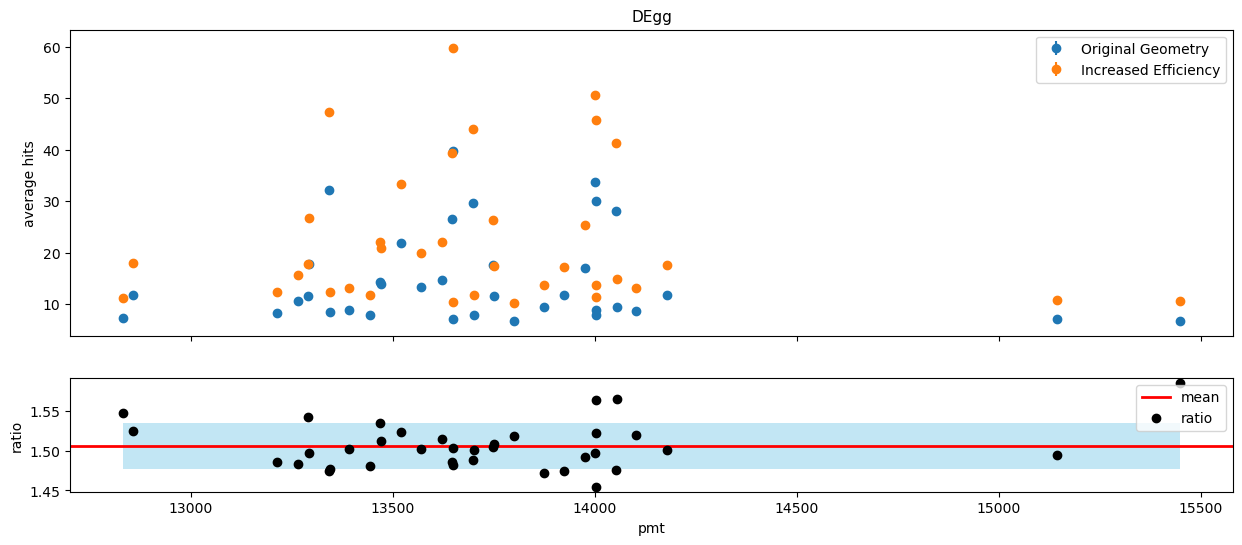

In [13]:
get_plot(degg_mcpe, degg_mcpeC, 10, 'DEgg')

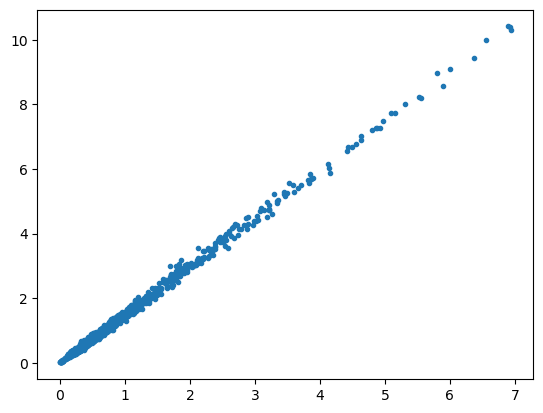

0.9966855523511348
[1.50291262 1.47286822 1.57954545 1.44908616 1.47747748 1.51088534
 1.51453488 1.50299401 1.47261663 1.49702381 1.4851752  1.48552339
 1.49486653 1.50301811 1.51688312 1.45084746 1.50564334 1.45652174
 1.50716332 1.48491379 1.4897541  1.50659134 1.48559078 1.49132948
 1.47668394 1.50416667 1.53488372 1.49005425 1.5007215  1.49271845
 1.46410256 1.58787879 1.53351955 1.48037677 1.54827586 1.515
 1.46944444 1.52366412 1.51403888 1.51764706 1.48571429 1.48190045
 1.48293963 1.48087432 1.41204819]
[0.07274709 0.08619453 0.09598    0.08889294 0.072097   0.05676933
 0.08868363 0.08121779 0.06844557 0.08863996 0.08213766 0.07109835
 0.07916665 0.07282279 0.09384866 0.065491   0.07032916 0.07196061
 0.07865831 0.07606941 0.07245291 0.05783369 0.05845495 0.0893432
 0.07303638 0.07208953 0.09397408 0.05979362 0.05985837 0.08068031
 0.07840074 0.0949961  0.08271853 0.0716228  0.07538423 0.07100063
 0.08022385 0.06652648 0.0733929  0.05592834 0.08083494 0.07604632
 0.08553157 0.

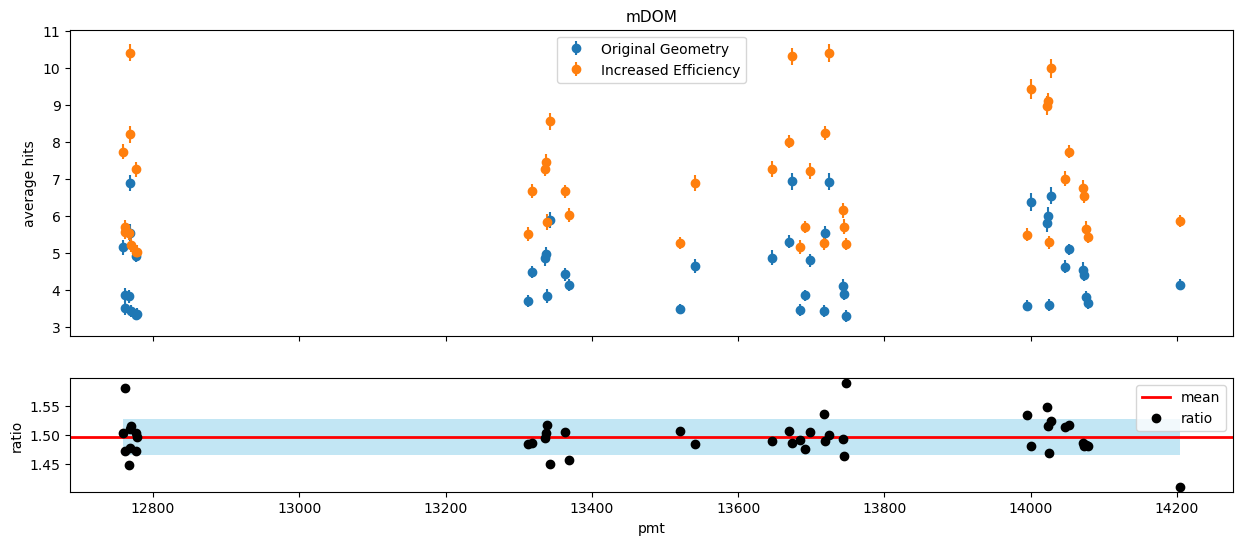

In [14]:
get_plot(mdom_mcpe, mdom_mcpeC, 5, 'mDOM')

In [ ]:
 fig, ax = plt.subplots()#figsize=(9,6))

    ax.errorbar(key_val[mean_valC>=above], mean_val[mean_valC>=above],
                yerr=mean_error_val[mean_valC>=above],
                fmt='o', label = 'Original Geometry')
    
    ax.errorbar(key_valC[mean_valC>=above], mean_valC[mean_valC>=above],
                yerr=mean_error_valC[mean_valC>=above],
                fmt='o', label = 'Increased Efficiency')

    ax.set_xlabel('pmt', fontsize=14)
    ax.set_ylabel('average hits', fontsize=14)
    ax.set_title(str(plt_title), fontsize=16)
    ax.set_aspect(aspect_ratio)
    
    print(f"x limits: {ax.get_xlim()}")
    print(f"y limits: {ax.get_ylim()}")
    print(f"aspect ratio: {ax.get_aspect()}")
    
    
    plt.legend(fontsize=12, loc='best')
    plt.savefig('./average_hits_efficiency_'+str(plt_title)+'.png', dpi = 200, bbox_inches='tight')
    plt.show()
    
    '''
    fig, ax = plt.subplots(figsize=(9,6))

    ax.errorbar(key_val[mean_val>=above], mean_val[mean_val>=above],
                yerr=mean_error_val[mean_val>=above],
                fmt='o', label = 'Original Geometry')
    
    ax.errorbar(key_valC[mean_valC>=above], mean_valC[mean_valC>=above],
                yerr=mean_error_valC[mean_valC>=above],
                fmt='o', label = 'Increased Efficiency')

    ax.set_xlabel('pmt', fontsize=14)
    ax.set_ylabel('average hits', fontsize=14)
    ax.set_title(str(plt_title), fontsize=16)
    ax.set_xlim([12800, 13000])
    
    fig, ax = plt.subplots(figsize=(9,6))

    ax.errorbar(key_val[mean_val>=above], mean_val[mean_val>=above],
                yerr=mean_error_val[mean_val>=above],
                fmt='o', label = 'Original Geometry')
    
    ax.errorbar(key_valC[mean_valC>=above], mean_valC[mean_valC>=above],
                yerr=mean_error_valC[mean_valC>=above],
                fmt='o', label = 'Increased Efficiency')

    ax.set_xlabel('pmt', fontsize=14)
    ax.set_ylabel('average hits', fontsize=14)
    ax.set_title(str(plt_title), fontsize=16)
    ax.set_xlim([13500, 13700])
    
    fig, ax = plt.subplots(figsize=(9,6))

    ax.errorbar(key_val[mean_val>=above], mean_val[mean_val>=above],
                yerr=mean_error_val[mean_val>=above],
                fmt='o', label = 'Original Geometry')
    
    ax.errorbar(key_valC[mean_valC>=above], mean_valC[mean_valC>=above],
                yerr=mean_error_valC[mean_valC>=above],
                fmt='o', label = 'Increased Efficiency')

    ax.set_xlabel('pmt', fontsize=14)
    ax.set_ylabel('average hits', fontsize=14)
    ax.set_title(str(plt_title), fontsize=16)
    ax.set_xlim([13700, 14000])
    plt.show()
    '''
    
    fig, ax = plt.subplots()#figsize=(9,6))

    ax.errorbar(key_val[mean_valC>=above], mean_ratio,
                yerr=mean_ratioErr,
                fmt='o', label = 'ratio')
    
    ax.axhline(y=np.mean(mean_ratio), color ='red', lw = 2, label = 'mean')

    ax.set_xlabel('pmt', fontsize=14)
    ax.set_ylabel('ratio', fontsize=14)
    ax.set_title(str(plt_title)+' Ratio', fontsize=16)
    ax.grid()
    
    plt.legend(fontsize=12, loc='best')
    plt.savefig('./mean_ratio_'+str(plt_title)+'.png', dpi = 200, bbox_inches='tight')
    plt.show()

100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
27 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
27 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
27 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
12 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
27 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
27 100
100 100
100 100
100 100
100 100
100 100
27 100
100 100
100 100
100 100
100 100
100 100
27 100
100 100
100 100
100 100


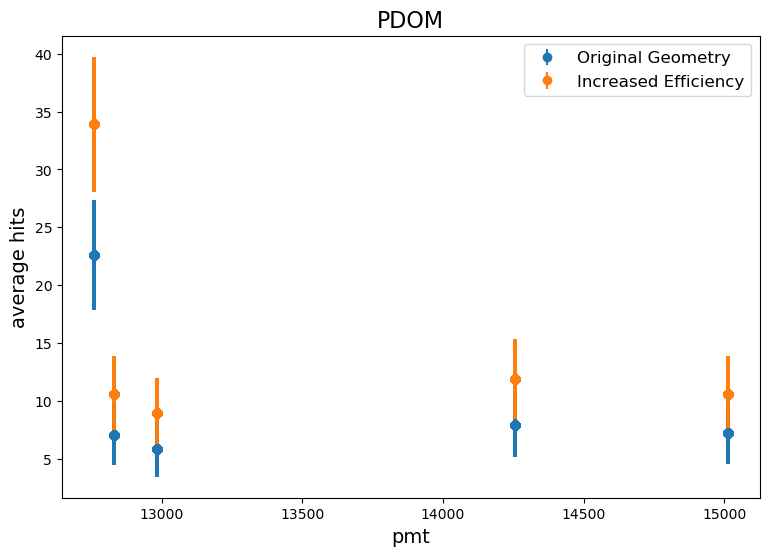

In [39]:
get_plot(pdom_mcpe, pdom_mcpeC, 5, 'PDOM')

100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
62 100
71 100
79 100
52 100
80 100
78 100
61 100
76 100
70 100
93 100
69 100
92 100
84 100
96 100
72 100
99 100
96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 

100 100
96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
79 100
79 100
80 100
78 100
82 100
70 100
93 100
69 100
92 100
96 100
72 100
9

100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
99 100
93 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
79 100
71 100
80 100
78 100
82 100
76 100
70 100
93 100
69 100
92 100
84 100
96 100
99 100
96 1

96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 1

100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
62 100
71 100
79 100
52 100
80 100
78 100
82 100
61 100
76 100
70 100
93 100
69 100
92 100
84 100
96 100
72 100
99 100
96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
29 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100


100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
62 100
79 100
80 100
78 100
82 100
61 100
76 100
70 100
93 100
69 100
92 100
96 100
72 100
99 100
96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 10

100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
79 100
62 100
71 100
79 100
80 100
82 100
61 100
70 100
93 100
92 100
84 100
96 100
72 100
99 100
96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
29 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 10

100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
79 100
79 100
52 100
82 100
61 100
70 100
93 100
92 100
84 100
96 100
72 100
99 100
96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
99 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
1

100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
99 100
93 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
79 100
71 100
80 100
78 100
82 100
76 100
70 100
93 100
69 100
92 100
84 100
96 100
99 100
96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
99 100
100 100
99

97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
79 100
62 100
79 100
80 100
78 100
70 100
93 100
92 100
96 100
72 100
99 100
96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
100 100
97 

100 100
94 100
100 100
98 100
99 100
93 100
100 100
99 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
79 100
71 100
79 100
52 100
80 100
78 100
82 100
61 100
76 100
70 100
93 100
92 100
84 100
96 100
72 100
99 100
96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100

96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
29 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
79 100
62 100
71 100
79 100
80 100
76 100
70

98 100
96 100
97 100
93 100
79 100
71 100
79 100
78 100
82 100
61 100
76 100
93 100
92 100
96 100
72 100
99 100
96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 1

98 100
96 100
97 100
93 100
79 100
62 100
71 100
79 100
80 100
82 100
61 100
76 100
70 100
93 100
69 100
92 100
96 100
72 100
99 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 10

100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
79 100
62 100
71 100
79 100
80 100
82 100
61 100
76 100
70 100
93 100
69 100
92 100
84 100
96 100
72 100
99 100
96 100
100 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
11 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100

100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
79 100
62 100
71 100

100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
79 100
52 100
78 100
82 100
61 100
70 100
93 100
92 100
84 100
96 100
99 100
96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 

99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
79 100
71 100
52 100
80 100
82 100
61 100
76 100
93 100
69 100
92 100
84 100
96 100
72 100
99 100
96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
29 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100

99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
79 100
79 100
52 100
82 100
61 100
70 100
93 100
92 100
84 100
96 100
72 100
99 100
96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
99 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100


100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
79 100
71 100
80 100
78 100
82 100
76 100
70 100
93 100
69 100
92 100
84 100
96 100
99 100
96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
11 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100

100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
79 100
62 100
79 100
52 100
80 100
78 100
82 100
70 100
93 100
69 100
92 100
96 100
72 100
99 100
96 100
100 100
86 100
100 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
10

100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
62 100
71 100
52 100
80 100
78 100
82 100
61 100
76 100
93 100
69 100
92 100
84 100
96 100
72 100
99 100
96 100
100 100
86 100
100 100
97 100
100 100
99 100
100 100
99 100
99 100
98 100
100 100
96 100
100 100
97 100
100 100
93 100
100 100
97 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
80 100
99 100
93

100 100
99 100
100 100
99 100
100 100
97 100
97 100
99 100
98 100
98 100
98 100
86 100
100 100
98 100
100 100
99 100
100 100
97 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
94 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
94 100
100 100
98 100
99 100
93 100
100 100
80 100
99 100
93 100
100 100
99 100
100 100
97 100
100 100
95 100
100 100
99 100
100 100
95 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
99 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
98 100
100 100
98 100
96 100
97 100
93 100
79 100
71 100
52 100
80 100
82 100
61 100
76 100
93 100
69 100
92 100
84 100
96 100
72 100
99 100
96 100
100 100
86 10

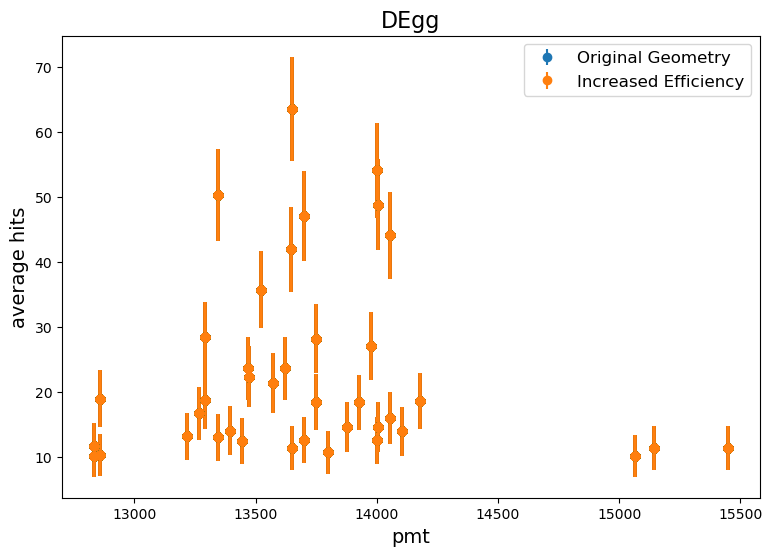

In [40]:
get_plot(degg_mcpe, degg_mcpeC, 10, 'DEgg')

100 100
94 100
100 100
100 100
94 100
79 100
71 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
45 100
43 100
68 100
56 100
86 100
67 100
40 100
99 100
93 100
54 100
31 100
68 100
99 100
100 100
99 100
39 100
96 100
98 100
98 100
86 100
98 100
48 100
71 100
79 100
77 100
72 100
69 100
71 100
58 100
60 100
74 100
57 100
82 100
85 100
41 100
86 100
95 100
46 100
43 100
28 100
37 100
38 100
53 100
85 100
91 100
96 100
65 100
82 100
77 100
58 100
24 100
88 100
96 100
96 100
89 100
91 100
74 100
77 100
96 100
96 100
100 100
42 100
65 100
85 100
54 100
73 100
54 100
83 100
71 100
29 100
73 100
26 100
63 100
88 100
36 100
37 100
34 100
69 100
43 100
53 100
83 100
47 100
67 100
71 100
73 100
40 100
63 100
71 100
80 100
93 100
35 100
72 100
46 100
67 100
36 100
77 100
40 100
33 100
59 100
48 100
59 100
34 100
57 100
65 100
56 100
42 100
98 100
31 100
38 100
98 100
57 100
65 100
41 100
66 100
67 100
73 100
75 100
44 100
14 100
34 100
5

88 100
85 100
92 100
36 100
71 100
60 100
77 100
93 100
61 100
65 100
100 100
83 100
70 100
48 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
66 100
57 100
64 100
45 100
37 100
32 100
51 100
55 100
31 100
72 100
38 100
67 100
55 100
28 100
60 100
38 100
29 100
74 100
73 100
27 100
48 100
35 100
51 100
54 100
80 100
39 100
32 100
48 100
45 100
37 100
54 100
62 100
84 100
50 100
55 100
89 100
44 100
70 100
75 100
34 100
27 100
73 100
35 100
62 100
35 100
46 100
44 100
38 100
48 100
38 100
88 100
42 100
66 100
38 100
49 100
71 100
62 100
90 100
34 100
52 100
76 100
76 100
85 100
83 100
35 100
41 100
50 100
48 100
36 100
50 100
52 100
76 100
81 100
40 100
62 100
26 100
49 100
68 100
39 100
47 100
45 100
67 100
80 100
64 100
54 100
38 100
30 100
64 100
42 100
46 100
47 100
46 100
56 100
45 100
67 100
63 100
35 100
58 100
36 100
89 100
84 100
39 100
34 100
77 100
51 100
57 100
36 100
46 100
82 100
59 100
49 100
28 100
63 100
77 100
85 100
74 100
5 100
30 100
83 100
72 100
41 

54 100
79 100
30 100
64 100
84 100
43 100
83 100
51 100
94 100
44 100
67 100
67 100
73 100
71 100
60 100
38 100
82 100
8 100
61 100
78 100
64 100
82 100
52 100
34 100
79 100
70 100
89 100
80 100
52 100
49 100
66 100
52 100
51 100
36 100
70 100
93 100
32 100
52 100
69 100
62 100
82 100
82 100
81 100
36 100
85 100
60 100
49 100
86 100
94 100
39 100
59 100
36 100
89 100
68 100
40 100
78 100
61 100
43 100
56 100
57 100
83 100
59 100
95 100
67 100
79 100
40 100
48 100
69 100
32 100
99 100
72 100
73 100
89 100
80 100
87 100
32 100
64 100
74 100
65 100
49 100
89 100
65 100
51 100
87 100
86 100
70 100
85 100
43 100
49 100
49 100
35 100
33 100
94 100
41 100
85 100
95 100
68 100
36 100
34 100
80 100
89 100
37 100
35 100
28 100
55 100
36 100
36 100
54 100
56 100
81 100
72 100
45 100
38 100
83 100
31 100
67 100
59 100
35 100
81 100
29 100
82 100
69 100
40 100
100 100
94 100
100 100
100 100
94 100
80 100
100 100
100 100
100 100
100 100
94 100
93 100
100 100
100 100
100 100
75 100
93 100
45 100
45 1

100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
93 100
75 100
100 100
100 100
79 100
59 100
35 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
83 100
87 100
97 100
93 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
51 100
28 100
92 100
30 100
87 100
81 100
99 100
91 100
56 100
39 100
86 100
98 100
91 100
84 100
53 100
99 100
54 100
84 100
82 100
96 100
100 100
58 100
54 100
39 100
97 100
98 100
32 100
98 100
40 100
39 100
65 100
95 100
60 100
86 100
88 100
29 100
64 100
85 100
31 100
28 100
92 100
74 100
71 100
77 100
93 100
24 100
65 100
100 100
58 100
83 100
77 100
70 100
37 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
57 100
64 100
45 100
69 100
37 100
30 100
55 100
72 100
51 100
38 100
67 100
60 100
33 100
74 100
48 100
38 100
51 100
39 100
29 100
54 100
80 100
62 100
59 100
54 100
84 100
50 100
42 100
55 100
89 100
44 100
67 100
34 100
70 100
87 100
34 100
31 100
73 100
33 100
62 100
54 100
56 100
44 100
32 100
3

82 100
99 100
100 100
95 100
40 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
70 100
73 100
63 100
99 100
89 100
62 100
96 100
100 100
91 100
91 100
95 100
61 100
43 100
86 100
74 100
71 100
90 100
63 100
29 100
64 100
31 100
62 100
31 100
51 100
76 100
52 100
81 100
36 100
94 100
67 100
75 100
92 100
81 100
91 100
38 100
64 100
32 100
52 100
61 100
89 100
81 100
66 100
85 100
91 100
78 100
83 100
96 100
61 100
79 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
73 100
35 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
98 100
62 100
55 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
50 100
46 100
86 100
64 100
37 100
27 100
88 100
100 100
87 100
31 100
95 100
99 100
71 100
33 100
89 100
52 100
82 100
39 100
45 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
87 100
50 100
35 100
36 100
41 100
52 100
85 100
59 100
55 100
97 100
91 100
56 100
94 100
93 100
77 100
74 100
45 100
69 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100

54 100
36 100
62 100
84 100
45 100
55 100
89 100
67 100
75 100
87 100
34 100
27 100
31 100
54 100
46 100
44 100
88 100
42 100
61 100
66 100
33 100
64 100
76 100
71 100
36 100
90 100
76 100
85 100
83 100
33 100
30 100
41 100
52 100
81 100
34 100
62 100
31 100
68 100
45 100
67 100
64 100
38 100
30 100
64 100
46 100
56 100
47 100
59 100
37 100
31 100
45 100
67 100
58 100
41 100
89 100
84 100
34 100
73 100
77 100
57 100
46 100
49 100
54 100
77 100
85 100
74 100
54 100
64 100
38 100
83 100
44 100
68 100
29 100
82 100
34 100
92 100
37 100
39 100
28 100
63 100
69 100
71 100
86 100
81 100
93 100
38 100
67 100
73 100
60 100
31 100
35 100
35 100
94 100
48 100
78 100
58 100
44 100
97 100
36 100
52 100
60 100
79 100
47 100
36 100
99 100
96 100
78 100
82 100
65 100
79 100
82 100
92 100
65 100
80 100
34 100
44 100
74 100
92 100
86 100
31 100
59 100
45 100
40 100
76 100
29 100
27 100
75 100
31 100
76 100
28 100
82 100
84 100
98 100
63 100
67 100
70 100
32 100
43 100
38 100
30 100
45 100
83 100
35 100

45 100
32 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
82 100
98 100
100 100
55 100
34 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
71 100
91 100
34 100
86 100
34 100
36 100
87 100
94 100
61 100
38 100
72 100
81 100
52 100
43 100
92 100
79 100
57 100
48 100
36 100
91 100
72 100
84 100
43 100
92 100
54 100
55 100
29 100
46 100
62 100
76 100
64 100
44 100
66 100
74 100
58 100
47 100
70 100
66 100
63 100
54 100
97 100
83 100
27 100
85 100
81 100
76 100
48 100
67 100
74 100
95 100
79 100
66 100
33 100
60 100
95 100
88 100
97 100
84 100
99 100
62 100
89 100
100 100
77 100
37 100
63 100
78 100
65 100
56 100
76 100
73 100
74 100
55 100
38 100
97 100
94 100
87 100
91 100
100 100
37 100
30 100
95 100
79 100
44 100
88 100
63 100
92 100
70 100
89 100
75 100
98 100
100 100
36 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
69 100
83 100
74 100
60 100
91 10

39 100
67 100
72 100
61 100
44 100
67 100
87 100
98 100
33 100
54 100
79 100
30 100
64 100
42 100
84 100
43 100
60 100
51 100
94 100
67 100
44 100
58 100
75 100
76 100
48 100
67 100
67 100
73 100
31 100
71 100
64 100
60 100
42 100
33 100
82 100
61 100
78 100
64 100
82 100
35 100
52 100
38 100
34 100
79 100
70 100
89 100
31 100
19 100
80 100
40 100
41 100
44 100
60 100
52 100
49 100
79 100
38 100
52 100
51 100
42 100
71 100
70 100
93 100
69 100
33 100
82 100
82 100
35 100
81 100
85 100
39 100
60 100
49 100
86 100
94 100
59 100
89 100
68 100
40 100
87 100
61 100
53 100
83 100
95 100
35 100
78 100
79 100
41 100
40 100
73 100
60 100
63 100
48 100
2 100
32 100
99 100
72 100
80 100
87 100
32 100
64 100
62 100
74 100
56 100
66 100
57 100
89 100
65 100
51 100
74 100
86 100
70 100
38 100
85 100
49 100
33 100
32 100
41 100
85 100
95 100
61 100
36 100
89 100
60 100
37 100
61 100
73 100
55 100
36 100
54 100
29 100
39 100
56 100
81 100
72 100
41 100
41 100
28 100
38 100
83 100
67 100
35 100
39 100


100 100
100 100
88 100
45 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
43 100
79 100
47 100
82 100
98 100
100 100
34 100
78 100
92 100
98 100
94 100
100 100
35 100
95 100
94 100
64 100
93 100
87 100
40 100
71 100
95 100
94 100
94 100
42 100
71 100
91 100
34 100
86 100
34 100
87 100
94 100
61 100
81 100
72 100
43 100
92 100
49 100
79 100
43 100
57 100
59 100
36 100
91 100
72 100
94 100
77 100
43 100
92 100
31 100
49 100
62 100
76 100
64 100
68 100
70 100
44 100
40 100
56 100
81 100
44 100
63 100
54 100
47 100
97 100
83 100
85 100
97 100
67 100
53 100
95 100
66 100
88 100
97 100
99 100
62 100
89 100
100 100
77 100
37 100
65 100
75 100
56 100
73 100
74 100
55 100
82 100
97 100
94 100
87 100
80 100
91 100
100 100
59 100
37 100
56 100
48 100
95 100
88 100
79 100
31 100
38 100
88 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
36 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
57 100
100 100
100 100
69 100
67 100
83 100
74 100
91 

90 100
53 100
40 100
93 100
80 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
32 100
47 100
82 100
100 100
83 100
89 100
50 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
82 100
99 100
100 100
95 100
60 100
100 100
100 100
100 100
97 100
100 100
78 100
70 100
73 100
82 100
99 100
89 100
62 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
43 100
86 100
78 100
57 100
62 100
74 100
71 100
90 100
38 100
31 100
51 100
73 100
64 100
52 100
81 100
36 100
45 100
94 100
92 100
91 100
90 100
64 100
32 100
52 100
30 100
61 100
89 100
81 100
66 100
85 100
91 100
78 100
83 100
96 100
28 100
33 100
79 100
66 100
100 100
100 100
98 100
84 100
99 100
97 100
53 100
73 100
35 100
76 100
61 100
29 100
71 100
100 100
97 100
91 100
99 100
89 100
100 100
77 100
98 100
62 100
63 100
55 100
53 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
30 100
86 100
37 100
27 100
88 100
100 100
87 100
73 100
31 100
95 100
99 100
71 100
89 100
98 1

85 100
43 100
49 100
33 100
94 100
41 100
33 100
85 100
95 100
61 100
68 100
80 100
36 100
89 100
61 100
34 100
28 100
55 100
65 100
39 100
56 100
28 100
81 100
41 100
38 100
83 100
20 100
67 100
59 100
35 100
45 100
39 100
81 100
28 100
82 100
60 100
100 100
94 100
100 100
100 100
94 100
79 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
85 100
90 100
32 100
45 100
43 100
43 100
36 100
85 100
56 100
27 100
86 100
67 100
82 100
73 100
51 100
40 100
99 100
93 100
54 100
31 100
99 100
100 100
99 100
96 100
98 100
98 100
86 100
80 100
65 100
98 100
48 100
71 100
79 100
32 100
74 100
77 100
72 100
32 100
76 100
61 100
69 100
71 100
32 100
58 100
74 100
57 100
82 100
85 100
88 100
41 100
86 100
95 100
46 100
43 100
38 100
59 100
53 100
76 100
85 100
91 100
96 100
65 100
75 100
82 100
44 100
77 100
58 100
24 100
88 100
96 100
96 100
61 100
89 100
91 100
74 100
77 100
96 100
96 100
100 100
49 100
41 100
40 100
75 100
42 100
85 100
54 100
54 100
83 100
2

35 100
61 100
52 100
71 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
77 100
98 100
62 100
63 100
55 100
53 100
100 100
88 100
100 100
97 100
93 100
95 100
100 100
50 100
46 100
86 100
64 100
37 100
88 100
100 100
87 100
73 100
95 100
99 100
89 100
82 100
98 100
85 100
87 100
38 100
85 100
50 100
97 100
91 100
56 100
74 100
94 100
49 100
70 100
74 100
45 100
62 100
69 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
84 100
100 100
95 100
78 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
60 100
38 100
99 100
100 100
75 100
91 100
63 100
38 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
31 100
75 100
100 100
99 100
72 100
78 100
36 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
88 100
100 100
100 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
79 100
82 100
98 100
100 100
55 100
55 100
34 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
28 100
64 100
91 10

38 100
83 100
93 100
35 100
43 100
79 100
65 100
34 100
75 100
56 100
43 100
93 100
30 100
75 100
56 100
33 100
64 100
90 100
53 100
54 100
70 100
47 100
53 100
46 100
40 100
84 100
38 100
81 100
87 100
33 100
41 100
83 100
99 100
84 100
79 100
95 100
46 100
48 100
44 100
56 100
83 100
97 100
97 100
87 100
98 100
79 100
67 100
74 100
67 100
87 100
84 100
38 100
39 100
89 100
67 100
72 100
61 100
44 100
67 100
87 100
42 100
77 100
98 100
33 100
30 100
54 100
79 100
64 100
42 100
84 100
60 100
83 100
51 100
94 100
58 100
76 100
67 100
67 100
73 100
31 100
25 100
71 100
64 100
38 100
55 100
82 100
61 100
78 100
36 100
36 100
23 100
64 100
52 100
79 100
70 100
89 100
31 100
19 100
80 100
44 100
60 100
52 100
36 100
79 100
52 100
51 100
71 100
70 100
93 100
42 100
36 100
69 100
33 100
62 100
82 100
36 100
81 100
36 100
49 100
85 100
39 100
60 100
49 100
86 100
94 100
59 100
59 100
83 100
68 100
78 100
87 100
61 100
34 100
52 100
44 100
83 100
95 100
35 100
67 100
78 100
79 100
40 100
73 100

99 100
72 100
78 100
36 100
95 100
100 100
100 100
100 100
99 100
100 100
100 100
52 100
97 100
47 100
88 100
100 100
100 100
88 100
28 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
43 100
79 100
47 100
82 100
98 100
100 100
55 100
55 100
92 100
98 100
94 100
100 100
95 100
94 100
91 100
93 100
87 100
40 100
95 100
94 100
94 100
91 100
49 100
86 100
87 100
94 100
61 100
35 100
38 100
81 100
72 100
52 100
49 100
42 100
79 100
59 100
48 100
91 100
72 100
94 100
84 100
77 100
92 100
54 100
49 100
62 100
76 100
64 100
44 100
66 100
74 100
58 100
44 100
63 100
54 100
39 100
47 100
83 100
97 100
48 100
34 100
67 100
53 100
74 100
95 100
66 100
60 100
95 100
88 100
97 100
84 100
99 100
62 100
89 100
100 100
58 100
63 100
78 100
65 100
56 100
76 100
73 100
74 100
82 100
97 100
94 100
87 100
80 100
91 100
100 100
56 100
48 100
39 100
36 100
95 100
88 100
79 100
44 100
88 100
63 100
92 100
93 100
70 100
89 100
98 100
100 100
29 100
5 100
42 100
68 100
94 100
96 100
86 

76 100
67 100
38 100
82 100
84 100
98 100
63 100
67 100
70 100
45 100
61 100
93 100
41 100
36 100
68 100
63 100
79 100
65 100
24 100
34 100
71 100
75 100
56 100
65 100
38 100
93 100
63 100
88 100
75 100
81 100
56 100
52 100
26 100
64 100
90 100
53 100
70 100
47 100
46 100
84 100
36 100
56 100
81 100
87 100
36 100
41 100
83 100
31 100
68 100
99 100
84 100
20 100
95 100
70 100
41 100
48 100
43 100
56 100
83 100
97 100
97 100
87 100
98 100
67 100
56 100
74 100
67 100
87 100
39 100
67 100
72 100
43 100
61 100
67 100
87 100
37 100
77 100
98 100
79 100
64 100
83 100
94 100
29 100
67 100
75 100
76 100
48 100
67 100
67 100
31 100
71 100
64 100
60 100
38 100
82 100
12 100
78 100
29 100
24 100
64 100
28 100
82 100
37 100
38 100
52 100
79 100
70 100
89 100
80 100
41 100
44 100
60 100
52 100
49 100
66 100
79 100
38 100
36 100
70 100
93 100
32 100
52 100
36 100
69 100
33 100
82 100
35 100
81 100
85 100
82 100
60 100
94 100
39 100
59 100
83 100
89 100
78 100
87 100
52 100
56 100
57 100
83 100
95 100

29 100
73 100
63 100
88 100
53 100
35 100
42 100
69 100
79 100
53 100
83 100
49 100
33 100
67 100
37 100
62 100
71 100
73 100
40 100
71 100
80 100
93 100
72 100
67 100
36 100
26 100
28 100
58 100
59 100
81 100
37 100
52 100
38 100
42 100
98 100
40 100
67 100
27 100
49 100
23 100
98 100
71 100
41 100
66 100
54 100
67 100
73 100
40 100
75 100
44 100
29 100
31 100
59 100
58 100
87 100
59 100
45 100
90 100
48 100
57 100
29 100
46 100
68 100
77 100
55 100
97 100
90 100
80 100
32 100
46 100
28 100
69 100
77 100
79 100
68 100
35 100
96 100
77 100
64 100
31 100
97 100
45 100
34 100
67 100
75 100
89 100
83 100
41 100
77 100
44 100
35 100
74 100
58 100
87 100
69 100
36 100
60 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
53 100
93 100
75 100
80 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
32 100
48 100
60 100
82 100
100 100
89 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
87 100
61 100
99 100
100 100
95 100
36 100
100 100
100 100
100 100
97 10

100 100
57 100
64 100
69 100
63 100
31 100
32 100
51 100
55 100
72 100
51 100
38 100
67 100
56 100
74 100
73 100
45 100
38 100
29 100
54 100
49 100
61 100
45 100
39 100
48 100
27 100
37 100
62 100
59 100
54 100
36 100
62 100
84 100
50 100
55 100
89 100
67 100
70 100
34 100
73 100
35 100
62 100
46 100
44 100
38 100
38 100
88 100
46 100
42 100
66 100
64 100
76 100
71 100
90 100
64 100
52 100
76 100
76 100
85 100
83 100
37 100
35 100
38 100
48 100
30 100
36 100
52 100
76 100
81 100
40 100
55 100
68 100
34 100
67 100
80 100
54 100
30 100
25 100
42 100
46 100
47 100
50 100
56 100
41 100
67 100
63 100
89 100
27 100
84 100
39 100
73 100
30 100
77 100
39 100
46 100
82 100
49 100
54 100
28 100
77 100
85 100
30 100
30 100
64 100
38 100
35 100
83 100
75 100
68 100
61 100
29 100
76 100
34 100
32 100
39 100
63 100
71 100
81 100
93 100
73 100
39 100
31 100
35 100
35 100
94 100
78 100
58 100
32 100
44 100
97 100
60 100
79 100
36 100
99 100
96 100
78 100
82 100
56 100
65 100
39 100
79 100
82 100
92 10

98 100
99 100
100 100
66 100
61 100
82 100
99 100
100 100
95 100
60 100
100 100
100 100
100 100
97 100
94 100
100 100
70 100
73 100
82 100
99 100
89 100
62 100
92 100
96 100
100 100
91 100
91 100
95 100
61 100
86 100
78 100
57 100
90 100
63 100
38 100
64 100
62 100
51 100
73 100
52 100
64 100
76 100
52 100
81 100
45 100
94 100
75 100
92 100
91 100
90 100
38 100
64 100
52 100
30 100
61 100
89 100
81 100
66 100
85 100
91 100
83 100
96 100
40 100
61 100
51 100
79 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
76 100
63 100
71 100
100 100
97 100
91 100
99 100
86 100
100 100
45 100
77 100
98 100
62 100
63 100
55 100
53 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
58 100
30 100
27 100
88 100
100 100
73 100
95 100
99 100
71 100
33 100
89 100
52 100
82 100
41 100
45 100
76 100
87 100
90 100
85 100
87 100
98 100
39 100
87 100
41 100
38 100
85 100
50 100
59 100
55 100
97 100
91 100
74 100
94 100
93 100
70 100
77 100
74 100
69 100
40 100
78 100
100 100
96 100
100 

36 100
66 100
57 100
64 100
37 100
69 100
63 100
31 100
32 100
55 100
31 100
55 100
60 100
38 100
29 100
46 100
39 100
49 100
80 100
61 100
45 100
39 100
45 100
62 100
59 100
84 100
50 100
34 100
89 100
44 100
67 100
70 100
75 100
87 100
34 100
27 100
31 100
73 100
33 100
62 100
35 100
54 100
56 100
46 100
48 100
38 100
88 100
50 100
64 100
76 100
31 100
49 100
71 100
36 100
62 100
52 100
76 100
76 100
85 100
83 100
48 100
33 100
50 100
52 100
38 100
55 100
34 100
62 100
34 100
68 100
39 100
35 100
49 100
34 100
45 100
64 100
54 100
64 100
42 100
42 100
46 100
47 100
30 100
46 100
59 100
50 100
67 100
58 100
25 100
89 100
58 100
27 100
84 100
37 100
39 100
77 100
63 100
50 100
57 100
41 100
36 100
46 100
43 100
82 100
54 100
63 100
77 100
85 100
54 100
30 100
64 100
38 100
83 100
72 100
75 100
68 100
61 100
41 100
76 100
82 100
92 100
37 100
22 100
28 100
69 100
71 100
86 100
81 100
27 100
93 100
31 100
67 100
73 100
60 100
35 100
48 100
78 100
58 100
97 100
52 100
60 100
36 100
99 100

56 100
42 100
81 100
87 100
36 100
83 100
30 100
99 100
84 100
79 100
95 100
41 100
25 100
44 100
56 100
83 100
97 100
97 100
87 100
98 100
79 100
67 100
74 100
71 100
67 100
87 100
84 100
38 100
89 100
67 100
72 100
43 100
87 100
37 100
47 100
77 100
98 100
33 100
13 100
68 100
54 100
79 100
84 100
83 100
51 100
94 100
75 100
48 100
73 100
44 100
71 100
38 100
55 100
82 100
61 100
33 100
78 100
29 100
36 100
82 100
52 100
33 100
79 100
70 100
36 100
38 100
89 100
43 100
60 100
66 100
79 100
38 100
52 100
42 100
71 100
70 100
93 100
52 100
41 100
36 100
69 100
62 100
82 100
82 100
81 100
40 100
37 100
85 100
82 100
39 100
49 100
86 100
94 100
59 100
59 100
83 100
89 100
68 100
78 100
87 100
61 100
43 100
53 100
38 100
52 100
57 100
83 100
59 100
95 100
64 100
78 100
79 100
73 100
24 100
69 100
99 100
72 100
87 100
62 100
65 100
49 100
56 100
66 100
57 100
89 100
51 100
74 100
87 100
86 100
43 100
49 100
35 100
94 100
85 100
95 100
61 100
80 100
36 100
89 100
37 100
61 100
33 100
34 100

58 100
55 100
57 100
65 100
82 100
85 100
88 100
86 100
95 100
33 100
53 100
76 100
91 100
96 100
65 100
75 100
82 100
44 100
77 100
58 100
59 100
88 100
96 100
96 100
89 100
91 100
77 100
57 100
96 100
96 100
100 100
37 100
75 100
42 100
65 100
38 100
85 100
54 100
73 100
54 100
83 100
37 100
55 100
71 100
34 100
29 100
63 100
88 100
53 100
35 100
42 100
40 100
57 100
79 100
83 100
39 100
67 100
47 100
37 100
62 100
71 100
18 100
71 100
80 100
72 100
67 100
40 100
59 100
81 100
43 100
59 100
57 100
65 100
38 100
56 100
42 100
98 100
35 100
27 100
49 100
98 100
64 100
31 100
66 100
67 100
67 100
73 100
40 100
75 100
29 100
38 100
34 100
31 100
59 100
58 100
87 100
59 100
45 100
90 100
30 100
69 100
57 100
62 100
59 100
77 100
97 100
90 100
47 100
80 100
77 100
55 100
39 100
96 100
67 100
77 100
97 100
29 100
33 100
67 100
63 100
75 100
66 100
89 100
83 100
77 100
40 100
44 100
26 100
74 100
72 100
58 100
87 100
69 100
36 100
60 100
38 100
89 100
51 100
94 100
96 100
100 100
100 100
90 

100 100
97 100
91 100
99 100
89 100
86 100
100 100
41 100
45 100
77 100
98 100
62 100
55 100
53 100
100 100
100 100
79 100
97 100
95 100
100 100
50 100
58 100
46 100
30 100
86 100
27 100
88 100
100 100
87 100
95 100
99 100
82 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
39 100
87 100
50 100
52 100
41 100
38 100
85 100
50 100
55 100
97 100
91 100
93 100
23 100
70 100
77 100
62 100
69 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
74 100
78 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
54 100
99 100
100 100
75 100
91 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
100 100
99 100
72 100
36 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
28 100
36 100
100 100
100 100
88 100
45 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
79 100
47 100
82 100
98 100
100 100
55 100
55 100
92 100
98 100
94 100
100 100
95 100
94 100
29 10

83 100
51 100
94 100
29 100
67 100
58 100
75 100
67 100
73 100
71 100
64 100
60 100
42 100
55 100
82 100
36 100
64 100
35 100
52 100
38 100
79 100
36 100
38 100
52 100
89 100
43 100
80 100
41 100
60 100
49 100
66 100
79 100
93 100
32 100
41 100
42 100
69 100
62 100
82 100
82 100
81 100
36 100
40 100
37 100
85 100
82 100
51 100
49 100
86 100
27 100
94 100
59 100
83 100
89 100
68 100
61 100
52 100
56 100
44 100
57 100
83 100
59 100
95 100
35 100
64 100
78 100
79 100
24 100
63 100
69 100
99 100
72 100
73 100
89 100
87 100
64 100
62 100
49 100
66 100
57 100
89 100
65 100
51 100
74 100
87 100
86 100
85 100
43 100
49 100
33 100
32 100
94 100
41 100
85 100
95 100
61 100
68 100
80 100
89 100
37 100
73 100
36 100
54 100
65 100
72 100
41 100
28 100
20 100
59 100
35 100
81 100
82 100
60 100
69 100
59 100
40 100
37 100
100 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
85 100
90 100
93 100
32 100
45 100
43 100
68 100
27 

48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
54 100
99 100
100 100
91 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
72 100
78 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
47 100
88 100
100 100
100 100
88 100
45 100
32 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
47 100
82 100
98 100
100 100
55 100
55 100
34 100
78 100
92 100
98 100
94 100
27 100
100 100
29 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
71 100
91 100
86 100
87 100
94 100
61 100
72 100
81 100
43 100
49 100
57 100
59 100
48 100
91 100
76 100
94 100
84 100
77 100
43 100
92 100
65 100
49 100
46 100
76 100
64 100
44 100
68 100
66 100
74 100
58 100
70 100
31 100
44 100
56 100
66 100
81 100
44 100
63 100
54 100
39 100
47 100
97 100
83 100
54 100
97 100
48 100
67 100
74 100
95 100
79 100
66 100
33 100
95 100
88 100
97 100
84 100
99 100
89 100
100 100
78 100
56 100
7

76 100
83 100
31 100
33 100
50 100
52 100
76 100
81 100
39 100
34 100
39 100
34 100
45 100
67 100
80 100
64 100
35 100
54 100
30 100
64 100
42 100
42 100
56 100
47 100
50 100
54 100
59 100
37 100
45 100
67 100
41 100
36 100
89 100
58 100
84 100
37 100
34 100
73 100
51 100
74 100
50 100
41 100
36 100
39 100
60 100
43 100
59 100
49 100
77 100
85 100
74 100
54 100
64 100
35 100
83 100
75 100
68 100
41 100
32 100
76 100
82 100
92 100
37 100
32 100
39 100
63 100
71 100
86 100
81 100
27 100
93 100
31 100
73 100
60 100
39 100
50 100
31 100
94 100
48 100
78 100
58 100
97 100
52 100
27 100
36 100
79 100
47 100
36 100
99 100
96 100
82 100
65 100
79 100
79 100
82 100
92 100
65 100
80 100
61 100
55 100
74 100
92 100
86 100
16 100
59 100
45 100
76 100
29 100
35 100
36 100
31 100
75 100
31 100
76 100
67 100
82 100
84 100
98 100
63 100
67 100
70 100
32 100
43 100
38 100
61 100
93 100
43 100
83 100
68 100
63 100
38 100
79 100
65 100
71 100
75 100
65 100
43 100
93 100
63 100
88 100
75 100
40 100
81 100

77 100
72 100
32 100
76 100
71 100
32 100
55 100
74 100
57 100
85 100
88 100
41 100
86 100
95 100
46 100
33 100
40 100
38 100
59 100
53 100
76 100
85 100
91 100
96 100
65 100
75 100
82 100
44 100
77 100
58 100
59 100
88 100
96 100
96 100
89 100
91 100
74 100
77 100
96 100
100 100
40 100
42 100
65 100
85 100
54 100
73 100
54 100
83 100
37 100
34 100
29 100
63 100
88 100
36 100
53 100
69 100
79 100
43 100
83 100
67 100
49 100
47 100
67 100
73 100
40 100
40 100
40 100
71 100
93 100
36 100
35 100
72 100
46 100
59 100
34 100
65 100
98 100
41 100
34 100
67 100
98 100
64 100
42 100
57 100
65 100
41 100
66 100
54 100
68 100
67 100
75 100
25 100
29 100
38 100
34 100
31 100
59 100
59 100
72 100
90 100
57 100
62 100
77 100
55 100
97 100
90 100
47 100
80 100
46 100
28 100
69 100
77 100
79 100
55 100
68 100
96 100
67 100
77 100
64 100
31 100
97 100
45 100
34 100
67 100
63 100
66 100
89 100
83 100
77 100
52 100
35 100
26 100
74 100
72 100
87 100
69 100
51 100
94 100
96 100
100 100
100 100
90 100
53 

88 100
100 100
100 100
97 100
36 100
47 100
88 100
100 100
100 100
88 100
28 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
79 100
82 100
98 100
100 100
55 100
78 100
92 100
98 100
94 100
100 100
35 100
95 100
94 100
29 100
28 100
64 100
91 100
93 100
87 100
40 100
71 100
95 100
94 100
94 100
42 100
24 100
91 100
49 100
86 100
36 100
87 100
94 100
61 100
38 100
32 100
72 100
81 100
72 100
92 100
35 100
57 100
59 100
91 100
72 100
76 100
94 100
84 100
77 100
43 100
92 100
54 100
65 100
55 100
29 100
49 100
76 100
66 100
74 100
47 100
70 100
31 100
40 100
56 100
66 100
81 100
63 100
97 100
54 100
85 100
97 100
81 100
76 100
48 100
67 100
53 100
95 100
60 100
95 100
88 100
97 100
84 100
99 100
62 100
89 100
100 100
58 100
37 100
63 100
78 100
65 100
76 100
74 100
55 100
82 100
97 100
94 100
87 100
91 100
100 100
59 100
30 100
56 100
39 100
36 100
95 100
88 100
79 100
44 100
38 100
88 100
63 100
92 100
93 100
89 100
75 100
98 100
100 100
68 100
94 100
96 100
86 100
84 10

67 100
73 100
60 100
50 100
94 100
48 100
78 100
97 100
52 100
27 100
60 100
79 100
99 100
96 100
25 100
78 100
35 100
82 100
56 100
65 100
79 100
79 100
92 100
51 100
80 100
34 100
33 100
61 100
55 100
44 100
74 100
92 100
86 100
31 100
59 100
26 100
35 100
36 100
33 100
31 100
31 100
38 100
82 100
84 100
98 100
27 100
63 100
45 100
61 100
83 100
93 100
35 100
36 100
83 100
68 100
63 100
79 100
65 100
27 100
24 100
71 100
75 100
56 100
38 100
93 100
88 100
75 100
40 100
56 100
52 100
64 100
53 100
41 100
54 100
70 100
47 100
53 100
46 100
40 100
84 100
42 100
38 100
81 100
87 100
83 100
68 100
99 100
84 100
79 100
95 100
70 100
41 100
46 100
48 100
44 100
83 100
97 100
97 100
30 100
98 100
56 100
44 100
74 100
71 100
67 100
84 100
39 100
89 100
67 100
72 100
61 100
44 100
67 100
87 100
47 100
77 100
98 100
30 100
54 100
79 100
64 100
84 100
83 100
51 100
94 100
43 100
67 100
44 100
75 100
76 100
67 100
32 100
73 100
31 100
44 100
64 100
42 100
38 100
61 100
33 100
78 100
29 100
24 100

56 100
42 100
98 100
40 100
31 100
38 100
49 100
98 100
64 100
42 100
57 100
71 100
66 100
35 100
54 100
68 100
67 100
67 100
75 100
44 100
45 100
31 100
58 100
87 100
34 100
72 100
90 100
48 100
69 100
28 100
62 100
46 100
55 100
97 100
46 100
77 100
79 100
55 100
39 100
60 100
68 100
96 100
67 100
77 100
31 100
97 100
40 100
34 100
63 100
75 100
66 100
89 100
83 100
77 100
40 100
52 100
87 100
69 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
53 100
30 100
93 100
80 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
48 100
47 100
60 100
82 100
100 100
83 100
89 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
87 100
82 100
99 100
100 100
95 100
40 100
60 100
100 100
100 100
100 100
97 100
94 100
100 100
78 100
73 100
63 100
82 100
99 100
89 100
62 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
43 100
35 100
86 100
78 100
62 100
71 100
90 100
63 100
38 100
64 100
62 100
51 100
73 100
76 100
81 100
36 100
45 100
94 100
67 100
75 100
92 100
81 

38 100
33 100
29 100
74 100
73 100
46 100
51 100
39 100
40 100
49 100
61 100
39 100
32 100
45 100
37 100
62 100
54 100
34 100
84 100
50 100
34 100
42 100
55 100
89 100
67 100
70 100
75 100
87 100
73 100
33 100
35 100
62 100
54 100
46 100
32 100
28 100
48 100
88 100
50 100
61 100
33 100
64 100
31 100
49 100
71 100
62 100
90 100
52 100
76 100
76 100
85 100
83 100
38 100
30 100
81 100
40 100
54 100
55 100
34 100
39 100
35 100
49 100
34 100
45 100
67 100
41 100
80 100
64 100
35 100
54 100
38 100
42 100
47 100
46 100
41 100
50 100
63 100
41 100
89 100
84 100
73 100
77 100
51 100
74 100
50 100
57 100
39 100
82 100
59 100
54 100
63 100
85 100
74 100
83 100
72 100
75 100
76 100
82 100
34 100
92 100
39 100
28 100
69 100
71 100
86 100
27 100
93 100
38 100
35 100
94 100
58 100
32 100
97 100
36 100
60 100
79 100
99 100
96 100
82 100
65 100
79 100
79 100
82 100
92 100
51 100
65 100
80 100
35 100
55 100
74 100
92 100
86 100
59 100
36 100
38 100
27 100
33 100
27 100
75 100
39 100
31 100
28 100
82 100

77 100
52 100
74 100
72 100
58 100
69 100
60 100
89 100
94 100
96 100
100 100
100 100
53 100
93 100
75 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
48 100
47 100
36 100
100 100
83 100
89 100
54 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
82 100
99 100
100 100
95 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
78 100
70 100
73 100
63 100
82 100
99 100
89 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
43 100
78 100
35 100
74 100
90 100
63 100
38 100
29 100
62 100
52 100
64 100
52 100
81 100
45 100
92 100
81 100
91 100
90 100
64 100
52 100
61 100
89 100
81 100
85 100
91 100
78 100
83 100
96 100
61 100
51 100
79 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
53 100
35 100
76 100
61 100
30 100
100 100
91 100
99 100
89 100
100 100
45 100
77 100
98 100
62 100
55 100
53 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
50 100
58 100
46 100
86 100
88 100
100 100
87 100
73 100
95 100
99 100
71

100 100
100 100
89 100
99 100
100 100
74 100
93 100
75 100
76 100
100 100
100 100
78 100
79 100
36 100
59 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
38 100
83 100
87 100
97 100
93 100
24 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
51 100
92 100
26 100
30 100
87 100
81 100
99 100
91 100
60 100
56 100
86 100
98 100
91 100
84 100
44 100
99 100
79 100
84 100
82 100
96 100
100 100
58 100
39 100
34 100
97 100
98 100
58 100
83 100
98 100
61 100
95 100
60 100
39 100
86 100
70 100
64 100
92 100
61 100
36 100
71 100
77 100
93 100
61 100
65 100
100 100
33 100
42 100
58 100
83 100
70 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
66 100
45 100
69 100
69 100
72 100
38 100
56 100
55 100
60 100
38 100
29 100
74 100
46 100
45 100
38 100
39 100
40 100
54 100
49 100
80 100
35 100
61 100
39 100
27 100
37 100
62 100
59 100
62 100
84 100
50 100
34 100
42 100
89 100
67 100
34 100
70 100
75 100
87 100
34 100
31 100
73 100
54 100
46 100
32 100
88 100
46

40 100
76 100
26 100
29 100
35 100
31 100
75 100
67 100
28 100
82 100
84 100
98 100
67 100
70 100
45 100
61 100
83 100
93 100
83 100
68 100
79 100
65 100
34 100
71 100
75 100
56 100
93 100
63 100
88 100
75 100
29 100
56 100
81 100
64 100
90 100
70 100
53 100
46 100
40 100
36 100
42 100
38 100
81 100
87 100
29 100
83 100
31 100
99 100
84 100
35 100
95 100
70 100
25 100
44 100
56 100
83 100
97 100
97 100
87 100
98 100
79 100
67 100
56 100
30 100
44 100
74 100
67 100
87 100
84 100
31 100
39 100
89 100
67 100
72 100
61 100
44 100
67 100
87 100
42 100
77 100
98 100
68 100
64 100
84 100
43 100
60 100
83 100
94 100
43 100
29 100
67 100
58 100
75 100
48 100
67 100
73 100
31 100
31 100
44 100
64 100
82 100
61 100
33 100
78 100
36 100
24 100
36 100
64 100
82 100
37 100
52 100
38 100
34 100
70 100
52 100
89 100
24 100
43 100
80 100
41 100
52 100
36 100
79 100
36 100
70 100
93 100
33 100
62 100
82 100
82 100
35 100
81 100
37 100
49 100
85 100
82 100
51 100
49 100
94 100
39 100
83 100
89 100
68 100

72 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
43 100
35 100
86 100
78 100
57 100
35 100
74 100
71 100
90 100
31 100
51 100
52 100
76 100
36 100
45 100
94 100
67 100
75 100
92 100
81 100
91 100
68 100
61 100
89 100
81 100
66 100
85 100
91 100
78 100
96 100
61 100
22 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
53 100
73 100
76 100
63 100
52 100
71 100
100 100
97 100
91 100
99 100
86 100
100 100
41 100
45 100
98 100
63 100
55 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
58 100
46 100
31 100
30 100
86 100
64 100
37 100
88 100
100 100
73 100
95 100
99 100
89 100
52 100
41 100
45 100
76 100
98 100
87 100
90 100
87 100
98 100
87 100
50 100
50 100
59 100
55 100
97 100
91 100
74 100
94 100
49 100
70 100
74 100
62 100
69 100
40 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
74 100
78 100
40 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
99 100
100 100
75 100


45 100
43 100
68 100
85 100
56 100
82 100
73 100
51 100
40 100
99 100
93 100
54 100
99 100
100 100
99 100
96 100
98 100
98 100
86 100
80 100
55 100
98 100
39 100
37 100
79 100
74 100
77 100
32 100
33 100
69 100
71 100
58 100
60 100
74 100
57 100
65 100
85 100
88 100
86 100
95 100
46 100
33 100
40 100
43 100
28 100
59 100
53 100
76 100
85 100
91 100
96 100
75 100
82 100
59 100
88 100
96 100
96 100
61 100
77 100
57 100
96 100
96 100
100 100
75 100
42 100
65 100
85 100
83 100
71 100
73 100
88 100
79 100
43 100
83 100
67 100
39 100
67 100
37 100
62 100
73 100
40 100
40 100
38 100
18 100
63 100
71 100
80 100
93 100
67 100
36 100
77 100
40 100
33 100
59 100
81 100
43 100
48 100
59 100
57 100
65 100
56 100
42 100
98 100
34 100
67 100
27 100
49 100
98 100
64 100
57 100
71 100
65 100
66 100
35 100
54 100
68 100
67 100
67 100
73 100
75 100
44 100
34 100
59 100
87 100
59 100
34 100
72 100
90 100
57 100
68 100
77 100
55 100
97 100
90 100
32 100
69 100
77 100
79 100
55 100
60 100
68 100
96 100
67 1

98 100
63 100
53 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
58 100
86 100
64 100
37 100
88 100
100 100
87 100
95 100
99 100
71 100
89 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
87 100
36 100
41 100
97 100
91 100
74 100
94 100
93 100
49 100
26 100
74 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
100 100
95 100
74 100
78 100
48 100
94 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
45 100
54 100
99 100
100 100
91 100
63 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
78 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
28 100
47 100
88 100
100 100
100 100
88 100
45 100
95 100
100 100
100 100
100 100
100 100
100 100
100 100
43 100
41 100
79 100
82 100
98 100
100 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
71 100
91 100
49 100
86 100
36 100
94 100
61 100
32 100
72 100
52 100
42 100
79 100


89 100
34 100
37 100
73 100
55 100
36 100
47 100
65 100
29 100
56 100
28 100
72 100
39 100
41 100
41 100
45 100
83 100
67 100
39 100
81 100
28 100
82 100
36 100
60 100
69 100
59 100
40 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
32 100
45 100
85 100
27 100
86 100
67 100
82 100
73 100
99 100
93 100
68 100
99 100
100 100
99 100
39 100
40 100
98 100
86 100
55 100
98 100
48 100
37 100
71 100
79 100
74 100
77 100
33 100
76 100
61 100
69 100
71 100
60 100
38 100
57 100
65 100
82 100
88 100
41 100
86 100
95 100
40 100
28 100
37 100
38 100
59 100
76 100
85 100
91 100
96 100
75 100
58 100
59 100
88 100
96 100
96 100
61 100
89 100
91 100
74 100
77 100
57 100
96 100
96 100
100 100
75 100
42 100
65 100
38 100
35 100
85 100
73 100
37 100
73 100
63 100
88 100
40 100
69 100
53 100
83 100
39 100
32 100
49 100
67 100
62 100
71 100
40 100
38 100
63 100
71 100
80 100
93 100
72 100
67 100
7

89 100
86 100
100 100
98 100
63 100
55 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
58 100
46 100
31 100
30 100
86 100
100 100
87 100
73 100
95 100
99 100
82 100
39 100
76 100
98 100
90 100
87 100
98 100
87 100
50 100
36 100
41 100
85 100
59 100
97 100
91 100
74 100
94 100
93 100
23 100
70 100
74 100
45 100
62 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
32 100
84 100
100 100
95 100
74 100
78 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
38 100
54 100
99 100
100 100
75 100
91 100
63 100
38 100
96 100
100 100
100 100
99 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
72 100
78 100
36 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
28 100
88 100
100 100
100 100
88 100
45 100
28 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
41 100
79 100
47 100
82 100
98 100
100 100
55 100
55 100
34 100
78 100
98 100
94 100
100 100
95 100
94 100
64 100
91 100
93 100
87 100

64 100
34 100
52 100
76 100
85 100
83 100
31 100
37 100
38 100
41 100
50 100
81 100
40 100
54 100
39 100
38 100
34 100
26 100
49 100
34 100
68 100
39 100
47 100
49 100
41 100
80 100
64 100
31 100
54 100
47 100
50 100
47 100
46 100
56 100
59 100
50 100
45 100
63 100
58 100
41 100
25 100
89 100
58 100
37 100
39 100
73 100
39 100
46 100
59 100
28 100
63 100
77 100
85 100
74 100
30 100
38 100
83 100
72 100
75 100
41 100
44 100
68 100
61 100
41 100
76 100
82 100
92 100
37 100
22 100
63 100
69 100
86 100
81 100
93 100
31 100
73 100
60 100
35 100
94 100
48 100
78 100
33 100
97 100
52 100
60 100
36 100
79 100
47 100
36 100
99 100
78 100
82 100
56 100
65 100
79 100
82 100
92 100
51 100
80 100
61 100
55 100
92 100
86 100
76 100
35 100
75 100
39 100
38 100
28 100
29 100
28 100
82 100
84 100
98 100
27 100
63 100
70 100
43 100
38 100
30 100
61 100
83 100
93 100
41 100
83 100
63 100
65 100
24 100
44 100
75 100
65 100
36 100
43 100
93 100
63 100
88 100
33 100
75 100
40 100
56 100
81 100
52 100
33 100

77 100
64 100
97 100
29 100
67 100
75 100
66 100
89 100
83 100
41 100
77 100
40 100
35 100
74 100
58 100
87 100
69 100
51 100
94 100
96 100
100 100
100 100
30 100
90 100
80 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
100 100
32 100
47 100
100 100
83 100
89 100
54 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
61 100
82 100
99 100
100 100
95 100
40 100
60 100
100 100
100 100
100 100
97 100
94 100
100 100
78 100
70 100
73 100
99 100
72 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
43 100
86 100
78 100
57 100
62 100
74 100
90 100
63 100
29 100
64 100
62 100
64 100
81 100
94 100
75 100
92 100
91 100
90 100
64 100
61 100
89 100
81 100
66 100
85 100
91 100
78 100
83 100
96 100
40 100
51 100
22 100
79 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
76 100
63 100
52 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
77 100
98 100
62 100
63 100
100 100
88 100
100 100
79 100
93 100
95 100
100 100
50 100
58 100
86 100
64 

88 100
100 100
94 100
100 100
99 100
57 100
100 100
100 100
69 100
67 100
83 100
74 100
60 100
91 100
99 100
92 100
92 100
36 100
98 100
100 100
100 100
100 100
100 100
99 100
100 100
74 100
55 100
93 100
75 100
76 100
100 100
100 100
78 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
38 100
83 100
97 100
93 100
24 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
51 100
92 100
30 100
99 100
91 100
60 100
39 100
86 100
98 100
91 100
84 100
53 100
99 100
54 100
79 100
84 100
82 100
96 100
100 100
54 100
39 100
34 100
97 100
98 100
83 100
53 100
40 100
37 100
65 100
95 100
60 100
39 100
91 100
70 100
88 100
64 100
85 100
28 100
92 100
61 100
74 100
60 100
77 100
93 100
61 100
65 100
100 100
33 100
58 100
83 100
77 100
70 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
64 100
69 100
69 100
63 100
31 100
51 100
31 100
67 100
56 100
60 100
38 100
33 100
74 100
27 100
48 100
51 100
39 100
54 100
80 100
45 100
27 100
45 100
62 100
34 100
36 

100 100
55 100
55 100
34 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
28 100
93 100
87 100
40 100
71 100
95 100
94 100
94 100
42 100
24 100
91 100
34 100
86 100
94 100
61 100
35 100
38 100
72 100
81 100
72 100
52 100
18 100
92 100
49 100
35 100
79 100
57 100
48 100
91 100
72 100
76 100
94 100
84 100
77 100
92 100
54 100
31 100
46 100
44 100
68 100
66 100
74 100
47 100
70 100
31 100
66 100
81 100
54 100
39 100
47 100
97 100
83 100
85 100
97 100
81 100
76 100
34 100
74 100
95 100
79 100
66 100
95 100
88 100
97 100
84 100
99 100
89 100
100 100
58 100
37 100
78 100
75 100
73 100
55 100
82 100
97 100
94 100
87 100
80 100
91 100
100 100
59 100
37 100
95 100
88 100
79 100
88 100
63 100
92 100
93 100
89 100
75 100
98 100
100 100
29 100
36 100
68 100
94 100
96 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
69 100
67 100
83 100
51 100
91 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
93 100
75 100
100 100
100 1

100 100
91 100
99 100
100 100
36 100
66 100
64 100
37 100
69 100
37 100
69 100
63 100
31 100
51 100
55 100
31 100
72 100
38 100
60 100
74 100
73 100
46 100
45 100
40 100
49 100
80 100
35 100
48 100
37 100
59 100
54 100
34 100
36 100
45 100
50 100
34 100
42 100
55 100
89 100
75 100
34 100
27 100
73 100
62 100
54 100
56 100
46 100
44 100
38 100
48 100
88 100
42 100
64 100
76 100
71 100
62 100
90 100
64 100
76 100
76 100
85 100
83 100
35 100
31 100
37 100
41 100
19 100
41 100
29 100
76 100
81 100
39 100
38 100
55 100
34 100
47 100
34 100
80 100
35 100
54 100
38 100
30 100
64 100
42 100
56 100
30 100
54 100
59 100
37 100
67 100
63 100
41 100
89 100
58 100
27 100
84 100
30 100
51 100
63 100
74 100
57 100
41 100
36 100
60 100
46 100
59 100
77 100
85 100
74 100
64 100
35 100
83 100
72 100
75 100
32 100
76 100
82 100
92 100
28 100
63 100
69 100
71 100
86 100
81 100
93 100
38 100
31 100
67 100
50 100
35 100
94 100
48 100
78 100
58 100
33 100
97 100
60 100
79 100
99 100
96 100
78 100
35 100
82 1

69 100
62 100
82 100
36 100
82 100
81 100
37 100
82 100
60 100
49 100
86 100
94 100
36 100
83 100
89 100
40 100
78 100
87 100
61 100
53 100
38 100
52 100
56 100
2 100
83 100
59 100
95 100
64 100
78 100
60 100
99 100
72 100
89 100
80 100
87 100
64 100
74 100
65 100
49 100
56 100
57 100
89 100
65 100
51 100
74 100
87 100
70 100
85 100
43 100
33 100
94 100
33 100
95 100
68 100
36 100
80 100
89 100
60 100
34 100
61 100
33 100
35 100
23 100
73 100
29 100
56 100
81 100
72 100
41 100
41 100
45 100
83 100
67 100
59 100
45 100
39 100
81 100
65 100
82 100
36 100
40 100
37 100
100 100
94 100
100 100
100 100
94 100
79 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
45 100
23 100
36 100
85 100
27 100
86 100
82 100
73 100
51 100
99 100
93 100
54 100
68 100
99 100
100 100
99 100
96 100
98 100
98 100
80 100
98 100
39 100
35 100
37 100
71 100
79 100
74 100
77 100
72 100
32 100
61 100
71 100
32 100
58 100
60 100
38 100
74 100
82 100
88 

91 100
87 100
40 100
71 100
95 100
94 100
94 100
42 100
71 100
91 100
49 100
86 100
34 100
87 100
94 100
61 100
38 100
32 100
81 100
72 100
92 100
35 100
79 100
59 100
91 100
72 100
94 100
84 100
77 100
92 100
31 100
65 100
49 100
46 100
62 100
76 100
64 100
68 100
74 100
70 100
31 100
44 100
40 100
56 100
66 100
81 100
44 100
63 100
54 100
97 100
83 100
85 100
97 100
81 100
76 100
67 100
53 100
74 100
66 100
60 100
95 100
88 100
97 100
99 100
62 100
89 100
100 100
58 100
63 100
78 100
65 100
75 100
56 100
82 100
97 100
94 100
80 100
91 100
100 100
30 100
95 100
88 100
88 100
63 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
29 100
36 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
83 100
74 100
60 100
51 100
91 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
93 100
75 100
76 100
100 100
100 100
78 100
79 100
36 100
35 100
98 100
99 100
100 100
100 100
100 100
82 100
97 

81 100
37 100
43 100
34 100
38 100
98 100
35 100
31 100
27 100
49 100
98 100
64 100
71 100
65 100
27 100
66 100
54 100
68 100
67 100
40 100
75 100
44 100
47 100
87 100
59 100
72 100
90 100
48 100
69 100
28 100
62 100
59 100
46 100
68 100
77 100
97 100
90 100
47 100
80 100
69 100
79 100
55 100
35 100
96 100
67 100
97 100
63 100
83 100
52 100
35 100
26 100
74 100
87 100
69 100
38 100
89 100
94 100
96 100
100 100
100 100
90 100
30 100
40 100
93 100
75 100
27 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
48 100
60 100
82 100
100 100
83 100
89 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
61 100
82 100
99 100
100 100
95 100
100 100
100 100
100 100
97 100
94 100
100 100
78 100
70 100
73 100
63 100
82 100
99 100
89 100
62 100
72 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
86 100
78 100
57 100
62 100
90 100
63 100
29 100
64 100
51 100
52 100
64 100
76 100
52 100
81 100
36 100
94 100
67 100
92 100
91 100
90 100
68 100
64 100
30 

100 100
100 100
97 100
88 100
100 100
100 100
88 100
45 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
79 100
82 100
98 100
100 100
55 100
55 100
34 100
78 100
92 100
98 100
94 100
27 100
100 100
95 100
94 100
29 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
42 100
71 100
91 100
34 100
94 100
61 100
81 100
72 100
92 100
42 100
35 100
79 100
43 100
59 100
48 100
91 100
72 100
76 100
94 100
84 100
77 100
43 100
92 100
54 100
65 100
55 100
29 100
62 100
76 100
64 100
68 100
74 100
58 100
70 100
31 100
56 100
81 100
63 100
54 100
47 100
97 100
83 100
27 100
85 100
97 100
76 100
67 100
74 100
95 100
79 100
33 100
60 100
95 100
88 100
97 100
84 100
99 100
62 100
89 100
100 100
58 100
77 100
78 100
75 100
56 100
55 100
38 100
97 100
94 100
87 100
91 100
100 100
37 100
39 100
95 100
88 100
63 100
92 100
93 100
70 100
89 100
98 100
100 100
42 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
69 100
67 100
7

82 100
51 100
99 100
93 100
27 100
54 100
31 100
68 100
99 100
100 100
99 100
40 100
96 100
98 100
98 100
86 100
65 100
55 100
98 100
48 100
35 100
37 100
32 100
72 100
32 100
71 100
58 100
60 100
55 100
74 100
57 100
82 100
85 100
88 100
41 100
86 100
95 100
43 100
28 100
53 100
76 100
85 100
91 100
96 100
75 100
82 100
77 100
58 100
59 100
88 100
96 100
96 100
61 100
89 100
91 100
74 100
77 100
96 100
96 100
100 100
49 100
41 100
65 100
54 100
73 100
54 100
83 100
37 100
55 100
71 100
34 100
73 100
63 100
88 100
57 100
79 100
43 100
53 100
83 100
67 100
47 100
67 100
40 100
40 100
38 100
40 100
63 100
80 100
93 100
27 100
46 100
36 100
77 100
40 100
59 100
81 100
43 100
59 100
57 100
98 100
40 100
31 100
67 100
27 100
49 100
98 100
64 100
71 100
65 100
31 100
54 100
67 100
67 100
73 100
75 100
25 100
31 100
59 100
90 100
57 100
46 100
77 100
55 100
97 100
90 100
80 100
32 100
77 100
79 100
55 100
35 100
96 100
77 100
97 100
34 100
29 100
33 100
75 100
66 100
89 100
83 100
41 100
77 1

100 100
52 100
97 100
88 100
100 100
100 100
88 100
32 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
79 100
82 100
98 100
100 100
55 100
55 100
34 100
78 100
92 100
98 100
94 100
27 100
100 100
35 100
95 100
94 100
28 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
71 100
91 100
86 100
36 100
87 100
94 100
81 100
72 100
52 100
92 100
49 100
79 100
43 100
59 100
48 100
36 100
91 100
72 100
76 100
94 100
84 100
77 100
43 100
92 100
46 100
76 100
44 100
68 100
58 100
47 100
70 100
40 100
66 100
63 100
39 100
47 100
97 100
83 100
54 100
85 100
97 100
81 100
76 100
48 100
67 100
53 100
95 100
79 100
66 100
33 100
95 100
88 100
97 100
84 100
99 100
62 100
89 100
100 100
58 100
77 100
37 100
63 100
78 100
65 100
75 100
56 100
76 100
73 100
74 100
82 100
97 100
87 100
80 100
91 100
100 100
56 100
39 100
95 100
88 100
79 100
44 100
31 100
88 100
63 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
36 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 1

36 100
49 100
85 100
60 100
86 100
94 100
39 100
59 100
89 100
68 100
23 100
40 100
78 100
87 100
43 100
38 100
57 100
83 100
59 100
95 100
64 100
67 100
78 100
79 100
40 100
73 100
60 100
24 100
48 100
69 100
72 100
73 100
89 100
80 100
74 100
65 100
49 100
56 100
89 100
65 100
74 100
86 100
70 100
85 100
43 100
49 100
35 100
33 100
32 100
94 100
41 100
95 100
61 100
80 100
89 100
37 100
61 100
23 100
73 100
36 100
54 100
65 100
43 100
29 100
39 100
81 100
72 100
38 100
20 100
67 100
59 100
35 100
45 100
81 100
60 100
69 100
59 100
40 100
40 100
37 100
100 100
94 100
100 100
100 100
94 100
71 100
100 100
100 100
100 100
100 100
94 100
67 100
16 100
23 100
93 100
100 100
100 100
100 100
90 100
75 100
93 100
45 100
36 100
68 100
85 100
56 100
32 100
86 100
67 100
82 100
73 100
51 100
99 100
93 100
99 100
100 100
99 100
96 100
98 100
98 100
80 100
55 100
98 100
48 100
37 100
71 100
74 100
77 100
32 100
76 100
61 100
71 100
55 100
74 100
57 100
65 100
82 100
85 100
88 100
86 100
95 100
46

32 100
44 100
97 100
36 100
60 100
79 100
99 100
96 100
78 100
82 100
65 100
41 100
79 100
79 100
82 100
92 100
51 100
65 100
80 100
35 100
34 100
33 100
44 100
92 100
86 100
31 100
59 100
75 100
39 100
76 100
67 100
29 100
82 100
84 100
98 100
27 100
63 100
67 100
70 100
32 100
45 100
83 100
83 100
68 100
79 100
65 100
27 100
34 100
44 100
71 100
75 100
93 100
63 100
88 100
33 100
30 100
75 100
29 100
40 100
81 100
41 100
52 100
90 100
41 100
40 100
84 100
36 100
42 100
38 100
81 100
33 100
41 100
31 100
30 100
68 100
99 100
84 100
79 100
35 100
95 100
70 100
43 100
44 100
56 100
83 100
97 100
97 100
87 100
98 100
30 100
74 100
71 100
87 100
89 100
67 100
67 100
87 100
37 100
77 100
98 100
68 100
79 100
30 100
42 100
84 100
83 100
94 100
43 100
67 100
4 100
75 100
76 100
48 100
67 100
67 100
31 100
31 100
44 100
64 100
42 100
82 100
61 100
78 100
29 100
24 100
36 100
23 100
82 100
37 100
52 100
38 100
52 100
33 100
79 100
70 100
52 100
89 100
24 100
31 100
40 100
44 100
60 100
52 100


97 100
91 100
56 100
74 100
94 100
93 100
70 100
77 100
45 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
78 100
40 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
60 100
54 100
99 100
100 100
75 100
91 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
31 100
70 100
75 100
100 100
99 100
72 100
78 100
36 100
95 100
100 100
100 100
100 100
99 100
100 100
100 100
97 100
88 100
100 100
100 100
88 100
32 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
41 100
43 100
79 100
82 100
98 100
100 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
28 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
24 100
91 100
34 100
49 100
86 100
36 100
87 100
94 100
61 100
72 100
81 100
72 100
43 100
92 100
49 100
42 100
35 100
79 100
43 100
59 100
36 100
91 100
94 100
77 100
92 100
54 100
55 100
49 100
76 100
64 100
44 100
66 100
74 100
58 100
47 100
70 100
44 100
40 100
66 100
81 1

58 100
34 100
97 100
98 100
58 100
83 100
98 100
53 100
61 100
40 100
39 100
34 100
65 100
95 100
39 100
91 100
86 100
70 100
88 100
64 100
85 100
31 100
92 100
74 100
77 100
93 100
61 100
65 100
100 100
58 100
83 100
77 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
36 100
66 100
57 100
64 100
45 100
37 100
69 100
69 100
63 100
55 100
31 100
72 100
56 100
55 100
60 100
74 100
73 100
54 100
49 100
80 100
35 100
39 100
62 100
54 100
34 100
62 100
84 100
42 100
89 100
44 100
67 100
34 100
70 100
75 100
87 100
73 100
54 100
46 100
32 100
88 100
42 100
50 100
66 100
33 100
64 100
76 100
38 100
71 100
36 100
90 100
64 100
34 100
52 100
76 100
85 100
83 100
48 100
30 100
50 100
52 100
76 100
81 100
39 100
55 100
62 100
49 100
68 100
47 100
49 100
34 100
45 100
80 100
64 100
31 100
35 100
54 100
38 100
25 100
42 100
46 100
47 100
54 100
37 100
41 100
67 100
58 100
30 100
36 100
89 100
84 100
37 100
39 100
34 100
73 100
30 100
51 100
63 100
74 100
50 100
57 100
41 100
36 100
46 100
82

75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
93 100
75 100
76 100
100 100
100 100
79 100
36 100
59 100
35 100
98 100
99 100
100 100
100 100
100 100
97 100
100 100
87 100
97 100
93 100
93 100
100 100
100 100
95 100
100 100
97 100
100 100
72 100
92 100
87 100
81 100
99 100
91 100
60 100
33 100
56 100
86 100
98 100
91 100
84 100
53 100
44 100
99 100
79 100
84 100
82 100
96 100
100 100
54 100
39 100
97 100
98 100
58 100
83 100
98 100
40 100
53 100
61 100
65 100
95 100
60 100
86 100
70 100
29 100
64 100
85 100
31 100
92 100
61 100
74 100
71 100
93 100
61 100
65 100
100 100
42 100
83 100
77 100
70 100
48 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
36 100
57 100
64 100
37 100
69 100
69 100
63 100
30 100
31 100
32 100
55 100
31 100
72 100
51 100
38 100
67 100
55 100
60 100
74 100
73 100
51 100
40 100
80 100
35 100
61 100
45 100
32 100
27 100
45 100
59 100
54 100
34 100
36 100
62 100
84 100
45 100
50 100
34 100
89 100
44 100
67 100
75 100


79 100
70 100
36 100
89 100
80 100
40 100
41 100
60 100
36 100
66 100
79 100
51 100
42 100
36 100
70 100
93 100
32 100
52 100
42 100
69 100
62 100
82 100
35 100
81 100
37 100
49 100
85 100
82 100
49 100
86 100
94 100
39 100
59 100
83 100
89 100
68 100
78 100
87 100
61 100
34 100
53 100
38 100
56 100
57 100
83 100
59 100
95 100
64 100
67 100
78 100
79 100
41 100
40 100
73 100
63 100
48 100
69 100
99 100
72 100
73 100
89 100
80 100
87 100
64 100
74 100
65 100
49 100
56 100
66 100
57 100
89 100
65 100
74 100
87 100
86 100
70 100
38 100
85 100
49 100
94 100
85 100
95 100
61 100
80 100
36 100
89 100
60 100
37 100
28 100
36 100
65 100
43 100
56 100
72 100
28 100
45 100
38 100
83 100
59 100
45 100
82 100
36 100
60 100
69 100
40 100
40 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
45 100
45 100
43 100
43 100
68 100
85 100
86 100
67 100
82 100
73 100
51 100
99 100
93 100
68 

100 100
59 100
30 100
56 100
36 100
95 100
88 100
79 100
88 100
63 100
92 100
93 100
89 100
98 100
100 100
42 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
69 100
67 100
83 100
51 100
36 100
91 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
75 100
76 100
100 100
100 100
78 100
79 100
36 100
35 100
98 100
99 100
100 100
100 100
100 100
97 100
100 100
83 100
43 100
45 100
87 100
97 100
93 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
92 100
26 100
87 100
81 100
99 100
91 100
60 100
86 100
91 100
84 100
44 100
99 100
79 100
84 100
82 100
33 100
96 100
100 100
39 100
97 100
98 100
58 100
83 100
98 100
53 100
61 100
40 100
39 100
65 100
95 100
40 100
91 100
86 100
70 100
88 100
31 100
92 100
74 100
36 100
71 100
77 100
93 100
100 100
33 100
58 100
83 100
77 100
70 100
48 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
57 100
64 100
69 100
6

73 100
30 100
77 100
51 100
63 100
74 100
57 100
41 100
39 100
46 100
82 100
59 100
49 100
54 100
28 100
63 100
85 100
74 100
30 100
33 100
30 100
83 100
72 100
75 100
41 100
61 100
29 100
76 100
82 100
92 100
37 100
63 100
69 100
71 100
81 100
93 100
73 100
60 100
50 100
35 100
35 100
94 100
78 100
33 100
32 100
97 100
27 100
79 100
99 100
96 100
82 100
56 100
65 100
41 100
79 100
79 100
82 100
92 100
51 100
65 100
27 100
80 100
35 100
61 100
55 100
44 100
54 100
74 100
92 100
86 100
76 100
35 100
36 100
27 100
39 100
38 100
82 100
84 100
98 100
63 100
67 100
70 100
43 100
30 100
45 100
61 100
83 100
93 100
35 100
43 100
83 100
38 100
79 100
65 100
24 100
44 100
56 100
65 100
38 100
36 100
93 100
63 100
88 100
75 100
40 100
81 100
56 100
41 100
33 100
90 100
53 100
53 100
40 100
36 100
56 100
81 100
87 100
29 100
41 100
30 100
68 100
99 100
79 100
95 100
41 100
48 100
44 100
56 100
83 100
97 100
97 100
87 100
30 100
98 100
79 100
56 100
74 100
71 100
67 100
87 100
84 100
89 100
72 100

31 100
76 100
67 100
38 100
15 100
29 100
82 100
84 100
98 100
63 100
70 100
32 100
30 100
45 100
93 100
43 100
83 100
68 100
79 100
24 100
44 100
75 100
56 100
65 100
38 100
36 100
93 100
63 100
88 100
30 100
29 100
40 100
52 100
90 100
53 100
54 100
70 100
46 100
84 100
56 100
42 100
81 100
87 100
36 100
41 100
83 100
31 100
68 100
99 100
84 100
35 100
95 100
70 100
41 100
83 100
97 100
97 100
98 100
79 100
67 100
74 100
71 100
67 100
87 100
84 100
39 100
89 100
67 100
43 100
61 100
67 100
87 100
37 100
47 100
77 100
98 100
33 100
68 100
30 100
64 100
84 100
60 100
83 100
51 100
94 100
29 100
67 100
44 100
58 100
75 100
67 100
73 100
31 100
31 100
38 100
55 100
82 100
78 100
24 100
64 100
82 100
52 100
34 100
79 100
38 100
89 100
31 100
80 100
44 100
60 100
52 100
38 100
70 100
93 100
52 100
62 100
82 100
82 100
35 100
40 100
49 100
82 100
49 100
86 100
94 100
59 100
83 100
89 100
78 100
87 100
61 100
43 100
38 100
52 100
56 100
44 100
83 100
95 100
67 100
79 100
73 100
60 100
69 100

94 100
67 100
75 100
81 100
91 100
90 100
68 100
64 100
32 100
89 100
81 100
66 100
91 100
78 100
96 100
40 100
61 100
51 100
28 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
73 100
35 100
76 100
63 100
61 100
52 100
71 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
41 100
98 100
63 100
55 100
53 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
50 100
46 100
86 100
88 100
100 100
87 100
73 100
95 100
99 100
71 100
33 100
89 100
52 100
82 100
98 100
87 100
90 100
85 100
87 100
98 100
87 100
50 100
36 100
52 100
85 100
50 100
59 100
55 100
97 100
91 100
56 100
94 100
93 100
32 100
74 100
62 100
69 100
40 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
74 100
78 100
40 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
60 100
99 100
100 100
75 100
91 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
72 100
78 100
44 100
95 1

46 100
27 100
45 100
48 100
38 100
35 100
39 100
29 100
80 100
35 100
61 100
45 100
45 100
62 100
59 100
36 100
62 100
50 100
55 100
89 100
44 100
67 100
70 100
75 100
87 100
73 100
62 100
54 100
56 100
44 100
88 100
61 100
66 100
76 100
38 100
49 100
71 100
90 100
64 100
85 100
37 100
50 100
33 100
19 100
50 100
52 100
29 100
76 100
81 100
39 100
55 100
34 100
62 100
49 100
35 100
80 100
64 100
35 100
30 100
42 100
46 100
56 100
59 100
41 100
31 100
21 100
45 100
67 100
35 100
30 100
36 100
89 100
84 100
39 100
34 100
63 100
74 100
50 100
57 100
60 100
43 100
82 100
59 100
77 100
74 100
83 100
72 100
75 100
76 100
82 100
92 100
37 100
32 100
39 100
63 100
71 100
86 100
81 100
27 100
93 100
31 100
73 100
39 100
31 100
94 100
48 100
32 100
97 100
52 100
60 100
99 100
96 100
78 100
35 100
82 100
56 100
65 100
79 100
79 100
82 100
92 100
51 100
65 100
80 100
61 100
55 100
74 100
92 100
86 100
16 100
31 100
76 100
35 100
38 100
27 100
27 100
75 100
39 100
31 100
67 100
38 100
28 100
82 100

98 100
64 100
65 100
66 100
67 100
67 100
73 100
75 100
45 100
58 100
87 100
72 100
90 100
69 100
57 100
62 100
59 100
68 100
77 100
97 100
90 100
47 100
80 100
46 100
69 100
77 100
79 100
55 100
39 100
68 100
96 100
77 100
31 100
97 100
40 100
49 100
67 100
63 100
75 100
66 100
89 100
83 100
41 100
52 100
26 100
74 100
87 100
69 100
60 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
40 100
93 100
75 100
80 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
48 100
60 100
82 100
100 100
83 100
89 100
54 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
61 100
82 100
99 100
100 100
95 100
36 100
60 100
100 100
100 100
100 100
97 100
55 100
100 100
70 100
29 100
63 100
99 100
89 100
72 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
43 100
35 100
86 100
78 100
57 100
62 100
74 100
71 100
90 100
62 100
73 100
76 100
81 100
94 100
75 100
92 100
81 100
91 100
32 100
52 100
30 100
61 100
89 100
81 100
85 100
83 100
96 100
51 

30 100
87 100
99 100
91 100
86 100
98 100
91 100
84 100
53 100
99 100
54 100
84 100
82 100
96 100
100 100
58 100
17 100
39 100
98 100
58 100
44 100
98 100
53 100
40 100
34 100
65 100
95 100
60 100
40 100
39 100
91 100
86 100
70 100
88 100
64 100
85 100
31 100
28 100
92 100
61 100
36 100
77 100
93 100
61 100
65 100
100 100
33 100
42 100
58 100
83 100
77 100
70 100
48 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
36 100
64 100
45 100
69 100
69 100
63 100
51 100
55 100
31 100
72 100
51 100
56 100
55 100
60 100
38 100
29 100
74 100
51 100
29 100
54 100
49 100
80 100
35 100
45 100
62 100
54 100
36 100
62 100
84 100
45 100
50 100
42 100
55 100
89 100
70 100
87 100
73 100
35 100
46 100
44 100
38 100
28 100
48 100
38 100
88 100
42 100
64 100
76 100
49 100
90 100
64 100
76 100
76 100
85 100
83 100
35 100
31 100
38 100
41 100
50 100
48 100
19 100
41 100
52 100
29 100
76 100
81 100
54 100
55 100
62 100
26 100
68 100
49 100
67 100
41 100
80 100
64 100
64 100
42 100
56 100
50 100
4

33 100
54 100
79 100
42 100
43 100
83 100
94 100
67 100
75 100
48 100
25 100
71 100
60 100
82 100
61 100
78 100
36 100
36 100
64 100
82 100
33 100
80 100
40 100
60 100
66 100
79 100
52 100
51 100
93 100
33 100
82 100
82 100
35 100
40 100
37 100
49 100
85 100
60 100
49 100
86 100
94 100
36 100
83 100
89 100
40 100
78 100
87 100
56 100
44 100
57 100
83 100
59 100
35 100
64 100
67 100
79 100
60 100
24 100
69 100
32 100
99 100
72 100
73 100
89 100
80 100
87 100
32 100
64 100
74 100
65 100
56 100
57 100
65 100
51 100
74 100
87 100
86 100
85 100
43 100
49 100
49 100
35 100
94 100
41 100
95 100
61 100
68 100
36 100
34 100
80 100
36 100
89 100
61 100
35 100
28 100
23 100
55 100
36 100
47 100
54 100
81 100
72 100
39 100
41 100
41 100
41 100
83 100
20 100
67 100
45 100
81 100
28 100
65 100
82 100
69 100
59 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
100 100
100 100
100 100
100 100
94 100
67 100
16 100
23 100
100 100
100 100
100 100
85 100
90 100
93 100
85 100
56 100
27 100
86 100
67 

44 100
38 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
72 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
36 100
88 100
100 100
100 100
88 100
45 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
98 100
100 100
55 100
55 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
64 100
93 100
87 100
71 100
95 100
94 100
94 100
71 100
91 100
86 100
34 100
94 100
38 100
32 100
72 100
81 100
49 100
42 100
35 100
79 100
43 100
91 100
72 100
76 100
94 100
84 100
77 100
43 100
92 100
65 100
55 100
62 100
76 100
64 100
44 100
68 100
66 100
74 100
58 100
47 100
44 100
40 100
56 100
81 100
47 100
97 100
83 100
85 100
97 100
81 100
76 100
74 100
95 100
66 100
33 100
60 100
95 100
97 100
84 100
99 100
62 100
89 100
100 100
63 100
65 100
76 100
73 100
55 100
38 100
82 100
97 100
94 100
87 100
91 100
100 100
59 100
37 100
30 100
56 100
48 100
39 100
36 100
95 100
88 100
79 100
44 100
38 100
63 100
92 100

100 100
67 100
97 100
100 100
72 100
51 100
28 100
92 100
87 100
81 100
91 100
60 100
33 100
56 100
86 100
98 100
91 100
84 100
44 100
99 100
54 100
79 100
84 100
82 100
33 100
96 100
100 100
97 100
98 100
58 100
44 100
98 100
40 100
61 100
40 100
39 100
34 100
95 100
60 100
91 100
88 100
64 100
85 100
31 100
92 100
61 100
77 100
93 100
100 100
58 100
83 100
77 100
37 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
36 100
66 100
64 100
45 100
37 100
30 100
32 100
51 100
38 100
67 100
33 100
74 100
46 100
27 100
45 100
39 100
40 100
29 100
54 100
80 100
35 100
61 100
27 100
34 100
36 100
62 100
84 100
50 100
42 100
55 100
89 100
44 100
67 100
70 100
87 100
73 100
62 100
54 100
44 100
38 100
38 100
88 100
50 100
61 100
66 100
64 100
76 100
38 100
31 100
49 100
71 100
36 100
62 100
90 100
64 100
34 100
52 100
76 100
76 100
83 100
35 100
41 100
50 100
33 100
50 100
41 100
76 100
81 100
40 100
54 100
38 100
49 100
47 100
49 100
34 100
45 100
67 100
64 100
31 100
64 100
46 100

88 100
36 100
53 100
35 100
37 100
42 100
57 100
79 100
43 100
41 100
53 100
83 100
67 100
49 100
47 100
33 100
36 100
62 100
71 100
73 100
40 100
63 100
71 100
80 100
93 100
36 100
35 100
72 100
58 100
59 100
48 100
52 100
42 100
98 100
31 100
38 100
67 100
49 100
98 100
71 100
27 100
66 100
68 100
67 100
73 100
40 100
75 100
38 100
59 100
58 100
87 100
45 100
72 100
90 100
48 100
69 100
57 100
62 100
59 100
46 100
68 100
77 100
55 100
97 100
90 100
46 100
69 100
77 100
79 100
55 100
39 100
60 100
68 100
35 100
96 100
77 100
64 100
97 100
45 100
49 100
89 100
83 100
41 100
77 100
44 100
58 100
87 100
60 100
38 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
93 100
75 100
80 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
32 100
47 100
36 100
60 100
100 100
83 100
89 100
54 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
61 100
82 100
99 100
100 100
95 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
70 100
73 100
29 100
82 100
99 1

99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
94 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
99 100
100 100
75 100
91 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
75 100
100 100
99 100
72 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
88 100
100 100
100 100
45 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
41 100
43 100
47 100
82 100
98 100
100 100
55 100
78 100
92 100
98 100
94 100
27 100
100 100
95 100
29 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
42 100
71 100
91 100
49 100
87 100
94 100
61 100
38 100
32 100
81 100
72 100
92 100
49 100
79 100
59 100
36 100
91 100
72 100
94 100
84 100
77 100
43 100
92 100
54 100
55 100
49 100
62 100
76 100
44 100
68 100
58 100
70 100
66 100
44 100
54 100
47 100
97 100
83 100
54 100
85 100
97 100
81 100
76 100
74 100
95 100
66 100
60 100
95 100
88 100
97 100
84 100
99 100
62 100
89 100
100 100
58 100
63 100
78 100
56 100
76 100
73 10

82 100
44 100
58 100
59 100
88 100
96 100
96 100
89 100
91 100
77 100
96 100
96 100
100 100
41 100
37 100
75 100
65 100
85 100
54 100
54 100
55 100
71 100
34 100
34 100
63 100
88 100
53 100
35 100
40 100
69 100
57 100
79 100
43 100
67 100
49 100
47 100
67 100
36 100
62 100
71 100
73 100
71 100
80 100
93 100
46 100
67 100
36 100
77 100
26 100
40 100
58 100
59 100
81 100
37 100
43 100
52 100
38 100
56 100
98 100
41 100
31 100
34 100
67 100
98 100
64 100
57 100
71 100
65 100
54 100
68 100
67 100
67 100
73 100
40 100
75 100
25 100
45 100
31 100
47 100
38 100
58 100
87 100
59 100
72 100
90 100
48 100
30 100
69 100
62 100
59 100
46 100
68 100
77 100
55 100
97 100
90 100
47 100
80 100
46 100
69 100
77 100
55 100
39 100
68 100
96 100
77 100
97 100
40 100
45 100
67 100
66 100
89 100
44 100
74 100
72 100
58 100
87 100
36 100
38 100
89 100
51 100
94 100
96 100
100 100
100 100
93 100
75 100
80 100
72 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
48 100
82 100
100 100
83 100
89 100
54 100

88 100
29 100
64 100
31 100
61 100
74 100
36 100
71 100
60 100
77 100
93 100
61 100
24 100
65 100
100 100
58 100
83 100
70 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
64 100
45 100
37 100
69 100
30 100
51 100
55 100
31 100
51 100
67 100
56 100
28 100
60 100
73 100
46 100
27 100
38 100
54 100
61 100
48 100
37 100
59 100
34 100
36 100
84 100
45 100
55 100
89 100
67 100
34 100
75 100
87 100
34 100
27 100
33 100
62 100
54 100
56 100
46 100
44 100
38 100
48 100
88 100
42 100
64 100
76 100
38 100
31 100
71 100
62 100
90 100
52 100
76 100
76 100
85 100
83 100
38 100
50 100
48 100
50 100
41 100
76 100
81 100
40 100
54 100
39 100
62 100
26 100
31 100
68 100
39 100
47 100
80 100
30 100
64 100
25 100
46 100
56 100
47 100
50 100
54 100
59 100
41 100
21 100
63 100
89 100
27 100
84 100
39 100
26 100
74 100
50 100
57 100
60 100
82 100
59 100
49 100
28 100
74 100
30 100
64 100
83 100
72 100
75 100
44 100
68 100
61 100
29 100
41 100
76 100
82 100
92 100
37 100
22 100
28 100
63 100
69

100 100
75 100
91 100
44 100
63 100
38 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
72 100
78 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
36 100
100 100
100 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
41 100
79 100
47 100
82 100
98 100
100 100
55 100
55 100
78 100
92 100
98 100
94 100
100 100
35 100
95 100
94 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
71 100
91 100
49 100
86 100
34 100
36 100
87 100
94 100
72 100
92 100
49 100
42 100
35 100
43 100
57 100
48 100
91 100
76 100
94 100
84 100
77 100
43 100
92 100
55 100
62 100
76 100
68 100
66 100
74 100
58 100
47 100
70 100
40 100
56 100
66 100
81 100
97 100
83 100
85 100
97 100
81 100
76 100
48 100
67 100
53 100
74 100
95 100
79 100
66 100
88 100
97 100
84 100
99 100
89 100
100 100
58 100
77 100
63 100
78 100
65 100
75 100
56 100
76 100
73 100
74 100
82 100
97 100
94 100
87 100
80 100
91 100
100 100
37 10

86 100
27 100
94 100
59 100
89 100
68 100
78 100
87 100
61 100
43 100
34 100
53 100
38 100
52 100
44 100
83 100
59 100
95 100
35 100
64 100
67 100
79 100
60 100
63 100
69 100
99 100
72 100
73 100
89 100
80 100
87 100
62 100
65 100
66 100
89 100
65 100
51 100
74 100
87 100
86 100
70 100
38 100
85 100
49 100
94 100
33 100
85 100
95 100
61 100
68 100
80 100
89 100
34 100
37 100
33 100
28 100
73 100
55 100
47 100
54 100
65 100
56 100
81 100
72 100
41 100
41 100
28 100
45 100
38 100
83 100
59 100
35 100
81 100
28 100
65 100
82 100
69 100
40 100
37 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
90 100
75 100
93 100
32 100
43 100
68 100
85 100
86 100
67 100
82 100
40 100
99 100
93 100
68 100
99 100
100 100
99 100
39 100
96 100
98 100
98 100
86 100
80 100
65 100
55 100
98 100
48 100
35 100
71 100
79 100
72 100
76 100
61 100
71 100
58 100
74 100
57 100
65 100
82 100
85 100
88 100
95 100
28 100
37 100
38

87 100
98 100
87 100
50 100
35 100
41 100
50 100
55 100
97 100
91 100
74 100
94 100
93 100
49 100
77 100
69 100
40 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
32 100
84 100
100 100
95 100
74 100
78 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
38 100
54 100
99 100
100 100
75 100
44 100
38 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
31 100
100 100
99 100
36 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
88 100
100 100
100 100
88 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
41 100
43 100
79 100
47 100
98 100
100 100
55 100
78 100
98 100
94 100
100 100
95 100
94 100
91 100
93 100
87 100
40 100
71 100
95 100
94 100
94 100
24 100
91 100
86 100
87 100
94 100
35 100
72 100
81 100
52 100
43 100
92 100
42 100
35 100
79 100
59 100
91 100
72 100
76 100
94 100
84 100
77 100
92 100
54 100
65 100
49 100
76 100
64 100
44 100
68 100
74 100
44 100
66 100
81 100
44 1

57 100
89 100
65 100
74 100
87 100
70 100
85 100
43 100
49 100
32 100
94 100
41 100
33 100
85 100
95 100
68 100
36 100
80 100
89 100
60 100
34 100
23 100
73 100
47 100
54 100
65 100
39 100
28 100
81 100
72 100
39 100
41 100
38 100
83 100
31 100
67 100
59 100
45 100
81 100
65 100
82 100
36 100
60 100
59 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
45 100
43 100
23 100
43 100
85 100
56 100
32 100
86 100
82 100
73 100
51 100
40 100
99 100
93 100
54 100
68 100
99 100
100 100
99 100
96 100
98 100
98 100
86 100
80 100
65 100
98 100
39 100
35 100
79 100
77 100
76 100
61 100
69 100
32 100
58 100
55 100
74 100
82 100
85 100
88 100
41 100
86 100
95 100
40 100
43 100
38 100
76 100
85 100
91 100
96 100
65 100
82 100
44 100
77 100
88 100
96 100
96 100
61 100
89 100
91 100
77 100
57 100
96 100
96 100
100 100
37 100
75 100
65 100
38 100
85 100
54 100
73 100
54 100
83 100
55 100
7

87 100
72 100
90 100
48 100
30 100
69 100
28 100
29 100
62 100
59 100
46 100
68 100
97 100
90 100
46 100
28 100
79 100
60 100
35 100
96 100
67 100
77 100
64 100
97 100
45 100
67 100
75 100
89 100
83 100
41 100
40 100
44 100
52 100
74 100
72 100
58 100
87 100
36 100
38 100
94 100
96 100
100 100
100 100
30 100
90 100
93 100
75 100
80 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
32 100
48 100
47 100
60 100
82 100
100 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
61 100
82 100
99 100
100 100
95 100
36 100
60 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
78 100
73 100
63 100
82 100
99 100
62 100
72 100
92 100
96 100
100 100
91 100
91 100
95 100
86 100
78 100
35 100
71 100
90 100
63 100
64 100
62 100
73 100
52 100
64 100
76 100
52 100
81 100
45 100
94 100
67 100
92 100
81 100
91 100
90 100
68 100
38 100
32 100
61 100
81 100
66 100
85 100
91 100
78 100
96 100
61 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
76 100
3

46 100
50 100
61 100
76 100
38 100
49 100
71 100
62 100
52 100
76 100
85 100
83 100
35 100
37 100
35 100
41 100
50 100
48 100
36 100
41 100
52 100
40 100
54 100
38 100
34 100
62 100
34 100
68 100
39 100
35 100
47 100
49 100
67 100
41 100
80 100
64 100
38 100
64 100
42 100
46 100
30 100
54 100
56 100
37 100
67 100
58 100
41 100
89 100
58 100
27 100
84 100
39 100
73 100
77 100
63 100
50 100
57 100
41 100
36 100
39 100
60 100
43 100
82 100
59 100
54 100
63 100
74 100
30 100
54 100
64 100
35 100
83 100
72 100
75 100
41 100
61 100
82 100
92 100
32 100
39 100
28 100
63 100
69 100
71 100
86 100
27 100
93 100
67 100
73 100
39 100
50 100
35 100
94 100
78 100
97 100
52 100
27 100
60 100
79 100
47 100
36 100
99 100
96 100
78 100
82 100
56 100
65 100
79 100
82 100
92 100
51 100
65 100
80 100
61 100
74 100
92 100
86 100
59 100
31 100
38 100
27 100
33 100
27 100
75 100
76 100
84 100
98 100
27 100
63 100
70 100
83 100
93 100
41 100
35 100
83 100
68 100
63 100
79 100
65 100
24 100
34 100
71 100
75 100

94 100
100 100
95 100
94 100
28 100
64 100
91 100
93 100
87 100
40 100
71 100
95 100
94 100
94 100
42 100
71 100
91 100
49 100
86 100
34 100
36 100
87 100
94 100
61 100
35 100
81 100
72 100
43 100
92 100
49 100
79 100
91 100
72 100
94 100
84 100
77 100
43 100
92 100
54 100
65 100
55 100
29 100
62 100
76 100
64 100
44 100
68 100
66 100
58 100
47 100
44 100
56 100
66 100
81 100
39 100
97 100
83 100
54 100
97 100
81 100
76 100
53 100
95 100
66 100
33 100
60 100
95 100
88 100
97 100
99 100
62 100
89 100
100 100
77 100
63 100
78 100
75 100
56 100
73 100
74 100
55 100
82 100
94 100
87 100
91 100
100 100
59 100
56 100
48 100
39 100
95 100
88 100
79 100
44 100
88 100
63 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
94 100
96 100
86 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
83 100
74 100
60 100
51 100
91 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
93 100
76 100
100 100
100 100
78 100
79 100
36 100
99 100
100 1

44 100
36 100
52 100
71 100
36 100
70 100
93 100
36 100
69 100
62 100
82 100
36 100
82 100
81 100
40 100
49 100
85 100
82 100
51 100
86 100
27 100
94 100
83 100
89 100
68 100
78 100
87 100
53 100
52 100
83 100
95 100
67 100
79 100
41 100
40 100
73 100
24 100
63 100
69 100
99 100
72 100
73 100
89 100
80 100
87 100
32 100
64 100
74 100
56 100
66 100
57 100
89 100
87 100
70 100
85 100
49 100
41 100
85 100
95 100
68 100
80 100
36 100
89 100
60 100
34 100
61 100
73 100
54 100
65 100
56 100
28 100
81 100
72 100
41 100
41 100
83 100
31 100
67 100
59 100
81 100
65 100
82 100
36 100
60 100
40 100
100 100
94 100
100 100
100 100
94 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
32 100
45 100
36 100
68 100
85 100
86 100
67 100
82 100
51 100
99 100
93 100
54 100
99 100
100 100
99 100
39 100
96 100
98 100
98 100
86 100
80 100
65 100
98 100
39 100
37 100
71 100
79 100
77 100
72 100
76 100
69 100
71 100
32 100
58 100
60 100
55

82 100
96 100
100 100
58 100
97 100
98 100
58 100
44 100
32 100
83 100
98 100
40 100
61 100
39 100
95 100
39 100
91 100
86 100
70 100
88 100
28 100
30 100
74 100
71 100
60 100
77 100
93 100
61 100
65 100
100 100
83 100
77 100
37 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
66 100
57 100
69 100
69 100
63 100
55 100
72 100
51 100
38 100
67 100
56 100
28 100
33 100
74 100
73 100
46 100
38 100
35 100
39 100
54 100
49 100
80 100
35 100
61 100
45 100
45 100
62 100
54 100
34 100
62 100
84 100
34 100
42 100
89 100
34 100
75 100
27 100
35 100
35 100
54 100
56 100
44 100
38 100
28 100
88 100
42 100
50 100
64 100
71 100
62 100
90 100
64 100
52 100
83 100
38 100
41 100
48 100
50 100
52 100
29 100
76 100
81 100
40 100
54 100
62 100
31 100
47 100
67 100
80 100
64 100
35 100
30 100
64 100
46 100
56 100
50 100
47 100
56 100
59 100
37 100
41 100
50 100
63 100
35 100
41 100
89 100
58 100
84 100
39 100
26 100
73 100
77 100
51 100
57 100
41 100
46 100
49 100
54 100
28 100
63 100
77 100
85 100
7

77 100
96 100
96 100
100 100
49 100
41 100
40 100
75 100
42 100
85 100
54 100
54 100
83 100
29 100
73 100
88 100
36 100
37 100
42 100
69 100
79 100
43 100
83 100
39 100
67 100
39 100
32 100
49 100
47 100
62 100
71 100
40 100
38 100
63 100
71 100
80 100
93 100
36 100
35 100
72 100
67 100
77 100
28 100
59 100
81 100
37 100
43 100
48 100
59 100
98 100
41 100
31 100
67 100
98 100
64 100
71 100
65 100
31 100
41 100
66 100
35 100
68 100
67 100
67 100
73 100
40 100
75 100
44 100
31 100
31 100
59 100
58 100
87 100
59 100
72 100
90 100
30 100
69 100
62 100
77 100
97 100
90 100
80 100
32 100
77 100
79 100
55 100
68 100
96 100
67 100
77 100
97 100
63 100
75 100
66 100
89 100
83 100
77 100
44 100
35 100
26 100
74 100
72 100
58 100
87 100
69 100
60 100
38 100
51 100
94 100
96 100
100 100
100 100
90 100
93 100
75 100
80 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
60 100
82 100
100 100
83 100
54 100
50 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
87 100
9

100 100
99 100
100 100
48 100
60 100
38 100
99 100
100 100
75 100
91 100
63 100
38 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
31 100
75 100
100 100
99 100
72 100
78 100
36 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
88 100
100 100
100 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
79 100
82 100
98 100
100 100
55 100
55 100
34 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
28 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
42 100
91 100
34 100
49 100
86 100
34 100
36 100
87 100
94 100
61 100
72 100
81 100
72 100
92 100
49 100
79 100
57 100
59 100
91 100
72 100
94 100
84 100
77 100
43 100
92 100
65 100
29 100
62 100
44 100
74 100
47 100
40 100
56 100
81 100
63 100
54 100
47 100
97 100
83 100
54 100
85 100
97 100
81 100
67 100
95 100
66 100
60 100
95 100
88 100
97 100
84 100
99 100
62 100
89 100
100 100
58 100
77 100
37 100
63 100
78 100
65 100
75 100
76 100
74 100
55 100
38 100
82 100
97 1

81 100
93 100
38 100
67 100
73 100
35 100
94 100
48 100
78 100
44 100
97 100
60 100
36 100
79 100
47 100
36 100
99 100
96 100
78 100
35 100
56 100
65 100
41 100
79 100
79 100
82 100
92 100
51 100
80 100
34 100
61 100
55 100
44 100
54 100
16 100
45 100
40 100
75 100
76 100
67 100
38 100
29 100
82 100
84 100
98 100
67 100
38 100
83 100
93 100
35 100
43 100
79 100
65 100
34 100
75 100
56 100
43 100
93 100
30 100
75 100
56 100
33 100
64 100
90 100
53 100
54 100
70 100
47 100
53 100
46 100
40 100
84 100
38 100
81 100
87 100
33 100
41 100
83 100
99 100
84 100
79 100
95 100
46 100
48 100
44 100
56 100
83 100
97 100
97 100
87 100
98 100
79 100
67 100
74 100
67 100
87 100
84 100
38 100
39 100
89 100
67 100
72 100
61 100
44 100
67 100
87 100
42 100
77 100
98 100
33 100
30 100
54 100
79 100
64 100
42 100
84 100
60 100
83 100
51 100
94 100
58 100
76 100
67 100
67 100
73 100
31 100
25 100
71 100
64 100
38 100
55 100
82 100
61 100
78 100
36 100
36 100
23 100
64 100
52 100
79 100
70 100
89 100
31 100

71 100
36 100
62 100
90 100
52 100
76 100
76 100
85 100
83 100
38 100
50 100
48 100
19 100
50 100
29 100
76 100
81 100
55 100
62 100
49 100
68 100
35 100
67 100
41 100
80 100
64 100
54 100
64 100
42 100
56 100
47 100
47 100
54 100
56 100
59 100
45 100
67 100
63 100
35 100
58 100
41 100
25 100
89 100
12 100
26 100
73 100
77 100
51 100
63 100
74 100
50 100
57 100
60 100
46 100
43 100
59 100
49 100
54 100
77 100
85 100
74 100
33 100
54 100
64 100
38 100
83 100
72 100
75 100
68 100
29 100
76 100
82 100
92 100
63 100
71 100
86 100
81 100
93 100
35 100
94 100
78 100
97 100
52 100
79 100
47 100
99 100
96 100
78 100
82 100
65 100
79 100
79 100
82 100
92 100
51 100
65 100
35 100
61 100
55 100
74 100
92 100
59 100
45 100
76 100
26 100
39 100
76 100
67 100
38 100
29 100
82 100
84 100
98 100
67 100
70 100
43 100
45 100
61 100
83 100
93 100
83 100
68 100
38 100
79 100
65 100
44 100
71 100
75 100
56 100
65 100
43 100
93 100
63 100
33 100
75 100
29 100
40 100
81 100
56 100
41 100
90 100
47 100
40 100

85 100
59 100
97 100
91 100
74 100
93 100
26 100
77 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
23 100
84 100
100 100
95 100
74 100
78 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
45 100
38 100
99 100
100 100
75 100
91 100
38 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
75 100
100 100
99 100
72 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
36 100
88 100
100 100
100 100
88 100
95 100
100 100
100 100
100 100
100 100
100 100
100 100
41 100
79 100
98 100
100 100
55 100
34 100
78 100
98 100
94 100
100 100
95 100
94 100
91 100
93 100
87 100
95 100
94 100
94 100
91 100
34 100
86 100
34 100
87 100
94 100
61 100
72 100
81 100
72 100
92 100
49 100
42 100
79 100
43 100
59 100
48 100
36 100
76 100
94 100
84 100
77 100
92 100
31 100
55 100
62 100
76 100
64 100
44 100
68 100
66 100
74 100
47 100
70 100
31 100
44 100
81 100
44 100
97 100
83 100
54 100
85 100
97 100
81 100
53 100
95 100
79 1

38 100
83 100
20 100
67 100
59 100
39 100
29 100
65 100
69 100
59 100
40 100
100 100
94 100
100 100
100 100
94 100
79 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
23 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
45 100
45 100
23 100
43 100
85 100
56 100
86 100
67 100
51 100
40 100
99 100
93 100
68 100
99 100
100 100
99 100
96 100
98 100
98 100
86 100
80 100
65 100
55 100
98 100
39 100
48 100
71 100
77 100
72 100
76 100
61 100
69 100
71 100
58 100
65 100
82 100
86 100
95 100
46 100
33 100
43 100
59 100
53 100
76 100
85 100
91 100
96 100
65 100
75 100
82 100
77 100
58 100
59 100
88 100
96 100
89 100
91 100
96 100
96 100
100 100
49 100
40 100
65 100
38 100
85 100
54 100
73 100
54 100
83 100
37 100
55 100
71 100
73 100
26 100
63 100
88 100
36 100
37 100
40 100
43 100
83 100
39 100
67 100
62 100
71 100
73 100
40 100
40 100
71 100
80 100
93 100
35 100
72 100
46 100
67 100
77 100
58 100
59 100
81 100
37 100
48 100
59 100
31 100
57 100
65 100
98 100
41 100
27 100
98 100
6

85 100
83 100
35 100
38 100
30 100
76 100
81 100
39 100
55 100
34 100
62 100
26 100
31 100
68 100
35 100
47 100
34 100
45 100
41 100
80 100
35 100
54 100
38 100
64 100
56 100
47 100
47 100
56 100
59 100
37 100
41 100
63 100
89 100
84 100
37 100
30 100
77 100
51 100
63 100
74 100
50 100
57 100
41 100
60 100
46 100
43 100
82 100
59 100
49 100
54 100
63 100
77 100
85 100
74 100
54 100
30 100
64 100
83 100
72 100
68 100
32 100
76 100
82 100
92 100
39 100
63 100
69 100
86 100
93 100
60 100
39 100
31 100
35 100
94 100
78 100
58 100
97 100
36 100
52 100
79 100
47 100
36 100
99 100
96 100
25 100
78 100
82 100
56 100
65 100
41 100
79 100
82 100
65 100
80 100
35 100
33 100
61 100
55 100
74 100
92 100
86 100
59 100
26 100
35 100
31 100
38 100
75 100
31 100
76 100
67 100
29 100
82 100
98 100
63 100
67 100
70 100
32 100
43 100
45 100
61 100
83 100
41 100
36 100
43 100
83 100
68 100
63 100
38 100
34 100
71 100
56 100
36 100
43 100
93 100
63 100
88 100
33 100
81 100
56 100
41 100
64 100
90 100
41 100

52 100
38 100
52 100
33 100
79 100
36 100
38 100
89 100
19 100
43 100
41 100
44 100
60 100
79 100
38 100
51 100
71 100
70 100
93 100
52 100
36 100
62 100
82 100
36 100
82 100
37 100
49 100
82 100
60 100
49 100
86 100
94 100
39 100
59 100
83 100
89 100
68 100
78 100
87 100
43 100
38 100
52 100
56 100
44 100
57 100
83 100
59 100
95 100
35 100
64 100
67 100
78 100
79 100
41 100
73 100
60 100
63 100
69 100
99 100
73 100
89 100
80 100
32 100
64 100
62 100
74 100
49 100
56 100
66 100
57 100
89 100
65 100
74 100
87 100
86 100
70 100
49 100
33 100
94 100
33 100
85 100
95 100
36 100
89 100
60 100
61 100
35 100
34 100
28 100
73 100
36 100
43 100
81 100
72 100
41 100
45 100
83 100
31 100
59 100
45 100
39 100
81 100
29 100
65 100
82 100
69 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
32 100
43 100
68 100
85 100
32 100
27 100
86 100
67 100
73 100
51 100
40 100
99 100
93 100
54 

46 100
86 100
64 100
37 100
88 100
100 100
87 100
73 100
95 100
99 100
71 100
89 100
39 100
76 100
98 100
87 100
85 100
87 100
98 100
39 100
87 100
50 100
36 100
41 100
85 100
59 100
55 100
97 100
91 100
56 100
94 100
93 100
32 100
70 100
77 100
74 100
45 100
69 100
40 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
100 100
95 100
78 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
38 100
99 100
100 100
75 100
91 100
44 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
31 100
70 100
100 100
99 100
72 100
36 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
28 100
47 100
88 100
100 100
100 100
45 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
79 100
47 100
82 100
98 100
100 100
55 100
55 100
78 100
92 100
98 100
94 100
100 100
35 100
95 100
94 100
91 100
93 100
95 100
94 100
94 100
42 100
91 100
49 100
34 100
87 100
94 100
61 100
72 100
72 100
43 100
92 100
79 100
43 100
59 100
36 100
94 100
84 100
77 

37 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
36 100
64 100
45 100
37 100
63 100
30 100
51 100
31 100
72 100
51 100
38 100
67 100
56 100
33 100
29 100
46 100
45 100
51 100
39 100
40 100
80 100
61 100
39 100
48 100
59 100
36 100
84 100
50 100
34 100
55 100
89 100
44 100
75 100
87 100
34 100
73 100
62 100
35 100
56 100
38 100
88 100
46 100
50 100
66 100
64 100
38 100
71 100
62 100
90 100
34 100
76 100
76 100
85 100
83 100
38 100
48 100
76 100
81 100
54 100
55 100
26 100
47 100
49 100
45 100
67 100
80 100
42 100
47 100
54 100
67 100
63 100
58 100
89 100
58 100
27 100
37 100
26 100
34 100
73 100
77 100
63 100
74 100
50 100
46 100
43 100
59 100
49 100
77 100
85 100
54 100
64 100
38 100
35 100
83 100
72 100
75 100
41 100
61 100
29 100
41 100
32 100
76 100
82 100
34 100
92 100
32 100
22 100
71 100
86 100
81 100
27 100
93 100
73 100
50 100
35 100
94 100
48 100
58 100
44 100
97 100
27 100
60 100
79 100
99 100
96 100
25 100
78 100
35 100
82 100
56 100
41 100
82 100
92 100
65 

100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
28 100
36 100
100 100
100 100
88 100
45 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
79 100
47 100
82 100
98 100
100 100
55 100
55 100
92 100
98 100
94 100
100 100
95 100
94 100
29 100
64 100
91 100
93 100
87 100
95 100
94 100
94 100
71 100
24 100
91 100
49 100
86 100
36 100
87 100
94 100
38 100
81 100
72 100
52 100
43 100
92 100
49 100
35 100
79 100
59 100
48 100
36 100
91 100
76 100
94 100
84 100
77 100
92 100
54 100
55 100
49 100
76 100
64 100
44 100
68 100
66 100
74 100
70 100
40 100
66 100
44 100
63 100
54 100
97 100
83 100
27 100
54 100
85 100
97 100
81 100
76 100
53 100
74 100
95 100
79 100
66 100
33 100
88 100
97 100
99 100
89 100
100 100
77 100
37 100
78 100
65 100
75 100
76 100
73 100
74 100
55 100
97 100
94 100
87 100
80 100
91 100
100 100
59 100
39 100
95 100
88 100
31 100
88 100
92 100
93 100
70 100
89 100
100 100
29 100
36 100
94 100
96 100
84 100
88 100
100 100
94 100
100 100
99 100
9

93 100
24 100
65 100
100 100
42 100
77 100
70 100
48 100
37 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
69 100
69 100
63 100
31 100
51 100
55 100
51 100
67 100
55 100
60 100
38 100
74 100
73 100
45 100
48 100
51 100
40 100
29 100
54 100
80 100
35 100
32 100
27 100
37 100
62 100
59 100
84 100
50 100
34 100
89 100
67 100
75 100
87 100
27 100
31 100
73 100
33 100
35 100
62 100
35 100
54 100
56 100
46 100
44 100
38 100
38 100
38 100
88 100
46 100
61 100
66 100
64 100
76 100
49 100
36 100
62 100
90 100
64 100
34 100
52 100
76 100
76 100
85 100
83 100
31 100
35 100
50 100
48 100
30 100
50 100
76 100
81 100
54 100
39 100
38 100
34 100
62 100
26 100
34 100
31 100
68 100
35 100
45 100
41 100
80 100
31 100
54 100
64 100
25 100
42 100
46 100
56 100
50 100
37 100
31 100
50 100
45 100
67 100
58 100
41 100
89 100
84 100
26 100
73 100
77 100
63 100
50 100
57 100
43 100
82 100
59 100
54 100
77 100
85 100
74 100
33 100
38 100
35 100
72 100
44 100
68 100
76 100
82 100
34 100
92 100
32

63 100
82 100
99 100
89 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
32 100
43 100
35 100
86 100
78 100
57 100
35 100
74 100
71 100
90 100
63 100
38 100
29 100
31 100
31 100
73 100
52 100
76 100
52 100
81 100
94 100
75 100
81 100
91 100
90 100
68 100
38 100
64 100
61 100
89 100
81 100
66 100
85 100
91 100
78 100
83 100
96 100
61 100
28 100
79 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
73 100
35 100
76 100
63 100
30 100
52 100
71 100
100 100
97 100
89 100
86 100
100 100
77 100
98 100
63 100
55 100
53 100
100 100
88 100
100 100
79 100
97 100
95 100
100 100
50 100
58 100
46 100
31 100
30 100
86 100
88 100
100 100
87 100
73 100
31 100
95 100
99 100
71 100
33 100
89 100
82 100
39 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
39 100
87 100
50 100
41 100
38 100
85 100
55 100
97 100
91 100
74 100
94 100
93 100
49 100
70 100
77 100
74 100
45 100
62 100
69 100
40 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
74 100

83 100
31 100
33 100
50 100
52 100
76 100
81 100
39 100
34 100
39 100
34 100
45 100
67 100
80 100
64 100
35 100
54 100
30 100
64 100
42 100
42 100
56 100
47 100
50 100
54 100
59 100
37 100
45 100
67 100
41 100
36 100
89 100
58 100
84 100
37 100
34 100
73 100
51 100
74 100
50 100
41 100
36 100
39 100
60 100
43 100
59 100
49 100
77 100
85 100
74 100
54 100
64 100
35 100
83 100
75 100
68 100
41 100
32 100
76 100
82 100
92 100
37 100
32 100
39 100
63 100
71 100
86 100
81 100
27 100
93 100
31 100
73 100
60 100
39 100
50 100
31 100
94 100
48 100
78 100
58 100
97 100
52 100
27 100
36 100
79 100
47 100
36 100
99 100
96 100
82 100
65 100
79 100
79 100
82 100
92 100
65 100
80 100
61 100
55 100
74 100
92 100
86 100
16 100
59 100
45 100
76 100
29 100
35 100
36 100
31 100
75 100
31 100
76 100
67 100
82 100
84 100
98 100
63 100
67 100
70 100
32 100
43 100
38 100
61 100
93 100
43 100
83 100
68 100
63 100
38 100
79 100
65 100
71 100
75 100
65 100
43 100
93 100
63 100
88 100
75 100
40 100
81 100
52 100

36 100
53 100
69 100
79 100
43 100
83 100
67 100
49 100
47 100
67 100
73 100
40 100
40 100
40 100
71 100
93 100
36 100
35 100
72 100
46 100
59 100
34 100
65 100
98 100
41 100
34 100
67 100
98 100
64 100
42 100
57 100
65 100
41 100
66 100
54 100
68 100
67 100
75 100
25 100
29 100
38 100
34 100
31 100
59 100
59 100
72 100
90 100
57 100
62 100
77 100
55 100
97 100
90 100
47 100
80 100
46 100
28 100
69 100
77 100
79 100
55 100
68 100
96 100
67 100
77 100
64 100
31 100
97 100
45 100
34 100
67 100
63 100
66 100
89 100
83 100
77 100
52 100
35 100
26 100
74 100
72 100
87 100
69 100
51 100
94 100
96 100
100 100
100 100
90 100
53 100
30 100
75 100
80 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
48 100
36 100
82 100
100 100
83 100
89 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
61 100
82 100
99 100
100 100
95 100
40 100
36 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
78 100
70 100
63 100
82 100
99 100
89 100
92 100
96 100
100 

50 100
35 100
52 100
38 100
85 100
55 100
97 100
91 100
74 100
94 100
93 100
23 100
32 100
77 100
74 100
62 100
69 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
100 100
95 100
74 100
78 100
40 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
45 100
54 100
99 100
100 100
91 100
44 100
63 100
38 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
78 100
36 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
36 100
47 100
88 100
100 100
100 100
88 100
28 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
79 100
82 100
98 100
100 100
55 100
78 100
92 100
98 100
94 100
100 100
35 100
95 100
94 100
29 100
28 100
64 100
91 100
93 100
87 100
40 100
71 100
95 100
94 100
94 100
42 100
24 100
91 100
49 100
86 100
36 100
87 100
94 100
61 100
38 100
32 100
72 100
81 100
72 100
92 100
35 100
57 100
59 100
91 100
72 100
76 100
94 100
84 100
77 100
43 100
92 100
54 1

95 100
88 100
79 100
31 100
88 100
92 100
93 100
89 100
75 100
98 100
100 100
68 100
94 100
96 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
67 100
91 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
93 100
75 100
100 100
100 100
78 100
79 100
59 100
35 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
83 100
45 100
87 100
97 100
93 100
34 100
24 100
100 100
100 100
95 100
100 100
97 100
100 100
72 100
92 100
30 100
99 100
91 100
33 100
86 100
98 100
91 100
84 100
53 100
99 100
54 100
79 100
84 100
82 100
96 100
100 100
58 100
54 100
97 100
98 100
58 100
44 100
83 100
98 100
40 100
61 100
65 100
95 100
60 100
40 100
39 100
91 100
86 100
88 100
64 100
85 100
31 100
92 100
61 100
36 100
71 100
60 100
77 100
93 100
100 100
58 100
83 100
70 100
90 100
97 100
100 100
100 100
91 100
99 100
100 100
66 100
57 100
64 100
45 100
69 100
69 100
51 100
55 100
31 100
51 100
33 100
73 100
38 100
51 100
54 100
80 100
61

93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
48 100
47 100
60 100
82 100
100 100
83 100
89 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
87 100
82 100
99 100
100 100
95 100
40 100
60 100
100 100
100 100
100 100
97 100
94 100
100 100
78 100
73 100
63 100
82 100
99 100
89 100
62 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
43 100
35 100
86 100
78 100
62 100
71 100
90 100
63 100
38 100
64 100
62 100
51 100
73 100
76 100
81 100
36 100
45 100
94 100
67 100
75 100
92 100
81 100
91 100
90 100
68 100
32 100
52 100
89 100
81 100
66 100
91 100
78 100
83 100
96 100
61 100
51 100
28 100
79 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
73 100
35 100
76 100
61 100
71 100
100 100
97 100
91 100
99 100
86 100
100 100
41 100
77 100
98 100
62 100
55 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
58 100
46 100
31 100
86 100
88 100
100 100
87 100
73 100
95 100
99 100
89 100
52 100
41 100
76 100
98 100
87 100
90 100
85 100
87 100
98 1

84 100
89 100
61 100
44 100
87 100
98 100
54 100
79 100
64 100
84 100
60 100
94 100
67 100
44 100
58 100
67 100
32 100
73 100
31 100
71 100
64 100
60 100
33 100
55 100
82 100
61 100
33 100
78 100
64 100
82 100
37 100
35 100
52 100
34 100
36 100
89 100
19 100
80 100
40 100
60 100
38 100
51 100
71 100
4 100
70 100
93 100
69 100
82 100
82 100
35 100
81 100
37 100
49 100
85 100
82 100
51 100
39 100
60 100
86 100
94 100
59 100
83 100
89 100
40 100
61 100
43 100
56 100
83 100
95 100
35 100
79 100
73 100
48 100
69 100
2 100
99 100
72 100
73 100
89 100
87 100
64 100
62 100
74 100
49 100
56 100
66 100
57 100
89 100
51 100
87 100
86 100
70 100
85 100
43 100
94 100
85 100
95 100
68 100
36 100
80 100
89 100
37 100
61 100
33 100
35 100
73 100
55 100
36 100
47 100
54 100
56 100
81 100
41 100
41 100
28 100
83 100
35 100
81 100
82 100
36 100
40 100
40 100
100 100
94 100
100 100
100 100
94 100
79 100
80 100
100 100
100 100
100 100
100 100
94 100
93 100
100 100
100 100
100 100
85 100
90 100
93 100
45 10

100 100
50 100
58 100
46 100
86 100
88 100
100 100
87 100
73 100
95 100
99 100
71 100
82 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
87 100
50 100
41 100
38 100
85 100
50 100
59 100
55 100
97 100
91 100
56 100
74 100
94 100
93 100
77 100
62 100
69 100
40 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
32 100
84 100
100 100
95 100
40 100
48 100
94 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
45 100
99 100
100 100
91 100
44 100
63 100
38 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
100 100
99 100
72 100
78 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
88 100
100 100
100 100
88 100
28 100
32 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
41 100
79 100
82 100
98 100
100 100
55 100
55 100
78 100
92 100
98 100
94 100
27 100
100 100
35 100
95 100
94 100
64 100
87 100
40 100
71 100
95 100
94 100
94 100
71 100
86 100
87 100
94 100
35 100
32 100
72 100
52 100
92 100
49

82 100
65 100
79 100
79 100
82 100
92 100
65 100
80 100
61 100
55 100
54 100
74 100
92 100
86 100
59 100
45 100
29 100
31 100
27 100
33 100
27 100
75 100
39 100
76 100
28 100
29 100
28 100
82 100
84 100
98 100
67 100
70 100
38 100
61 100
83 100
93 100
41 100
83 100
63 100
38 100
79 100
65 100
75 100
56 100
65 100
38 100
36 100
93 100
63 100
88 100
33 100
75 100
29 100
56 100
81 100
33 100
64 100
90 100
53 100
54 100
70 100
46 100
40 100
84 100
56 100
81 100
87 100
33 100
36 100
83 100
68 100
99 100
84 100
79 100
35 100
95 100
70 100
41 100
56 100
97 100
97 100
87 100
98 100
79 100
74 100
71 100
87 100
38 100
89 100
67 100
72 100
61 100
67 100
87 100
77 100
98 100
30 100
68 100
54 100
79 100
30 100
84 100
83 100
94 100
29 100
67 100
58 100
75 100
67 100
67 100
32 100
73 100
71 100
55 100
82 100
8 100
61 100
33 100
36 100
82 100
34 100
36 100
52 100
89 100
24 100
31 100
43 100
80 100
41 100
60 100
36 100
66 100
79 100
51 100
42 100
71 100
36 100
70 100
93 100
32 100
52 100
42 100
33 100


65 100
85 100
73 100
83 100
71 100
63 100
88 100
40 100
57 100
79 100
43 100
41 100
53 100
83 100
67 100
32 100
49 100
47 100
33 100
67 100
37 100
71 100
38 100
18 100
71 100
93 100
27 100
77 100
40 100
58 100
81 100
37 100
52 100
65 100
38 100
98 100
98 100
64 100
42 100
71 100
65 100
27 100
41 100
66 100
67 100
73 100
75 100
25 100
44 100
31 100
47 100
59 100
58 100
87 100
59 100
72 100
90 100
30 100
57 100
46 100
77 100
55 100
97 100
90 100
47 100
80 100
32 100
69 100
77 100
79 100
55 100
60 100
68 100
96 100
67 100
64 100
97 100
67 100
63 100
75 100
66 100
89 100
83 100
77 100
40 100
44 100
52 100
35 100
26 100
72 100
58 100
87 100
69 100
60 100
38 100
89 100
94 100
96 100
100 100
100 100
90 100
53 100
30 100
40 100
75 100
80 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
36 100
60 100
82 100
100 100
50 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
82 100
99 100
100 100
95 100
40 100
36 100
60 100
100 100
100 100
100 100
97 100
55 10

69 100
40 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
74 100
78 100
40 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
99 100
100 100
75 100
91 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
72 100
78 100
95 100
100 100
100 100
100 100
99 100
100 100
100 100
52 100
97 100
47 100
100 100
100 100
88 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
41 100
43 100
79 100
47 100
98 100
100 100
34 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
42 100
71 100
91 100
49 100
34 100
87 100
72 100
81 100
52 100
43 100
92 100
49 100
42 100
79 100
57 100
48 100
91 100
72 100
76 100
94 100
84 100
77 100
92 100
54 100
29 100
49 100
46 100
76 100
68 100
66 100
31 100
44 100
66 100
81 100
63 100
54 100
47 100
97 100
83 100
85 100
97 100
81 100
34 100
53 100
74 100
95 100
60 100
95 1

100 100
37 100
36 100
95 100
88 100
79 100
44 100
88 100
63 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
29 100
36 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
69 100
83 100
74 100
51 100
91 100
99 100
92 100
92 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
93 100
75 100
100 100
100 100
78 100
79 100
36 100
59 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
38 100
43 100
45 100
87 100
97 100
93 100
34 100
24 100
93 100
100 100
100 100
95 100
100 100
97 100
100 100
72 100
51 100
87 100
81 100
99 100
91 100
39 100
86 100
98 100
91 100
84 100
42 100
53 100
44 100
99 100
54 100
79 100
84 100
82 100
96 100
100 100
58 100
54 100
39 100
34 100
97 100
98 100
58 100
98 100
40 100
53 100
95 100
39 100
91 100
86 100
70 100
88 100
29 100
64 100
85 100
92 100
61 100
74 100
71 100
60 100
77 100
93 100
65 100
100 100
42 100
58 100
83 100
77 100
70 100
48 100
37 100
90 100
97 100
100 

73 100
33 100
35 100
54 100
32 100
28 100
88 100
46 100
50 100
61 100
66 100
64 100
76 100
62 100
90 100
64 100
76 100
85 100
30 100
36 100
29 100
76 100
81 100
40 100
54 100
55 100
34 100
62 100
34 100
45 100
67 100
80 100
31 100
35 100
30 100
64 100
42 100
46 100
54 100
59 100
41 100
31 100
50 100
45 100
67 100
63 100
35 100
58 100
30 100
36 100
89 100
27 100
39 100
30 100
77 100
63 100
74 100
57 100
36 100
43 100
82 100
59 100
77 100
85 100
74 100
33 100
64 100
83 100
75 100
41 100
68 100
61 100
76 100
82 100
34 100
92 100
39 100
69 100
86 100
81 100
93 100
38 100
67 100
73 100
39 100
50 100
31 100
35 100
94 100
48 100
78 100
58 100
33 100
32 100
44 100
97 100
52 100
60 100
36 100
79 100
47 100
36 100
99 100
96 100
25 100
78 100
35 100
56 100
79 100
79 100
82 100
92 100
65 100
27 100
34 100
33 100
61 100
74 100
92 100
86 100
16 100
59 100
40 100
76 100
38 100
33 100
31 100
75 100
39 100
76 100
28 100
84 100
98 100
67 100
32 100
38 100
30 100
45 100
61 100
83 100
93 100
41 100
43 100

77 100
98 100
62 100
63 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
50 100
31 100
30 100
86 100
64 100
88 100
100 100
73 100
95 100
99 100
71 100
89 100
52 100
82 100
39 100
98 100
87 100
85 100
87 100
98 100
87 100
50 100
35 100
41 100
41 100
85 100
50 100
59 100
97 100
91 100
94 100
93 100
49 100
26 100
70 100
77 100
45 100
62 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
32 100
23 100
84 100
100 100
95 100
74 100
48 100
94 100
100 100
100 100
100 100
100 100
99 100
100 100
38 100
54 100
99 100
100 100
91 100
44 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
100 100
99 100
78 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
88 100
100 100
100 100
88 100
45 100
32 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
41 100
43 100
79 100
47 100
82 100
98 100
100 100
55 100
34 100
78 100
98 100
94 100
100 100
95 100
94 100
64 100
91 100
93 100
87 100
40 100
71 100


98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
93 100
75 100
76 100
100 100
100 100
78 100
59 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
38 100
83 100
45 100
87 100
97 100
93 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
92 100
87 100
81 100
99 100
91 100
86 100
98 100
91 100
84 100
53 100
99 100
54 100
79 100
82 100
33 100
96 100
100 100
58 100
54 100
97 100
98 100
58 100
44 100
83 100
98 100
53 100
61 100
37 100
65 100
95 100
40 100
91 100
86 100
70 100
88 100
28 100
92 100
61 100
30 100
74 100
36 100
71 100
60 100
77 100
93 100
61 100
65 100
100 100
42 100
58 100
77 100
70 100
37 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
36 100
57 100
64 100
45 100
69 100
63 100
51 100
51 100
67 100
55 100
60 100
74 100
73 100
46 100
27 100
45 100
38 100
29 100
54 100
49 100
80 100
61 100
45 100
32 100
48 100
27 100
36 100
84 100
45 100
50 100
34 100
89 100
67 100
70 100
75 100
87 100
46 100
32 100
38 100
38 100
48 100


43 100
56 100
83 100
97 100
97 100
98 100
79 100
30 100
74 100
71 100
67 100
87 100
84 100
39 100
67 100
72 100
43 100
44 100
67 100
87 100
47 100
77 100
98 100
33 100
30 100
68 100
54 100
79 100
64 100
42 100
84 100
60 100
83 100
51 100
94 100
67 100
75 100
76 100
48 100
67 100
44 100
64 100
55 100
12 100
61 100
78 100
23 100
64 100
82 100
35 100
52 100
33 100
79 100
70 100
36 100
38 100
52 100
89 100
80 100
60 100
49 100
66 100
79 100
36 100
70 100
93 100
52 100
41 100
69 100
62 100
82 100
82 100
81 100
36 100
40 100
37 100
85 100
82 100
51 100
49 100
86 100
27 100
94 100
59 100
83 100
89 100
78 100
87 100
61 100
53 100
38 100
56 100
57 100
95 100
35 100
67 100
78 100
79 100
41 100
40 100
73 100
60 100
63 100
48 100
32 100
99 100
73 100
89 100
80 100
87 100
64 100
62 100
74 100
65 100
49 100
56 100
65 100
74 100
87 100
86 100
70 100
38 100
85 100
49 100
49 100
94 100
95 100
61 100
68 100
34 100
80 100
89 100
60 100
61 100
33 100
35 100
73 100
36 100
47 100
54 100
28 100
72 100
41 100

44 100
4 100
58 100
76 100
48 100
67 100
67 100
71 100
64 100
33 100
55 100
82 100
61 100
36 100
36 100
64 100
28 100
82 100
35 100
38 100
79 100
38 100
89 100
31 100
60 100
66 100
79 100
51 100
36 100
70 100
93 100
32 100
41 100
42 100
36 100
69 100
82 100
81 100
49 100
85 100
82 100
60 100
86 100
27 100
94 100
39 100
36 100
83 100
68 100
40 100
78 100
43 100
52 100
57 100
83 100
95 100
64 100
78 100
79 100
73 100
60 100
24 100
63 100
48 100
69 100
32 100
99 100
72 100
73 100
89 100
80 100
87 100
64 100
62 100
74 100
65 100
66 100
89 100
65 100
38 100
85 100
85 100
95 100
61 100
68 100
80 100
89 100
60 100
37 100
61 100
33 100
34 100
36 100
43 100
56 100
28 100
81 100
41 100
45 100
38 100
83 100
67 100
59 100
45 100
28 100
29 100
65 100
82 100
36 100
60 100
69 100
59 100
40 100
37 100
100 100
94 100
100 100
100 100
94 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
32 100
68 100
85 100
56 100
27 100
86 100
67 1

31 100
57 100
65 100
98 100
40 100
10 100
49 100
98 100
42 100
57 100
71 100
65 100
54 100
68 100
67 100
67 100
73 100
75 100
44 100
47 100
14 100
38 100
59 100
58 100
87 100
59 100
72 100
90 100
48 100
69 100
57 100
59 100
68 100
77 100
55 100
97 100
90 100
80 100
32 100
69 100
79 100
60 100
68 100
35 100
96 100
67 100
64 100
31 100
97 100
29 100
49 100
67 100
63 100
75 100
66 100
89 100
83 100
35 100
74 100
72 100
58 100
87 100
38 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
53 100
93 100
75 100
80 100
27 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
48 100
47 100
82 100
100 100
83 100
89 100
54 100
100 100
100 100
100 100
100 100
99 100
100 100
66 100
87 100
61 100
99 100
100 100
95 100
100 100
100 100
100 100
97 100
94 100
100 100
78 100
70 100
73 100
63 100
82 100
99 100
89 100
62 100
72 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
32 100
43 100
86 100
78 100
57 100
62 100
35 100
74 100
71 100
90 100
63 100
38 100
29 100
64 100
31 100
62 

84 100
73 100
51 100
63 100
57 100
41 100
36 100
39 100
60 100
46 100
43 100
82 100
49 100
54 100
28 100
63 100
77 100
85 100
74 100
33 100
30 100
64 100
83 100
72 100
75 100
44 100
68 100
61 100
41 100
76 100
82 100
92 100
37 100
32 100
22 100
39 100
28 100
69 100
81 100
93 100
67 100
73 100
39 100
31 100
35 100
94 100
78 100
58 100
33 100
44 100
97 100
27 100
36 100
79 100
47 100
36 100
99 100
96 100
78 100
35 100
82 100
39 100
41 100
79 100
79 100
92 100
65 100
27 100
34 100
61 100
55 100
44 100
54 100
74 100
92 100
86 100
59 100
45 100
40 100
76 100
29 100
31 100
33 100
27 100
75 100
31 100
67 100
82 100
84 100
98 100
67 100
70 100
45 100
61 100
83 100
93 100
35 100
43 100
68 100
63 100
65 100
34 100
44 100
71 100
75 100
56 100
65 100
36 100
93 100
63 100
88 100
30 100
75 100
56 100
41 100
64 100
90 100
53 100
41 100
54 100
70 100
47 100
53 100
46 100
40 100
84 100
38 100
87 100
36 100
41 100
31 100
30 100
68 100
99 100
84 100
95 100
70 100
41 100
25 100
83 100
97 100
97 100
87 100

91 100
96 100
65 100
82 100
44 100
77 100
59 100
88 100
96 100
96 100
61 100
89 100
91 100
74 100
77 100
96 100
96 100
100 100
37 100
75 100
42 100
65 100
54 100
83 100
55 100
53 100
37 100
69 100
79 100
83 100
32 100
49 100
47 100
37 100
62 100
71 100
73 100
40 100
40 100
38 100
18 100
71 100
80 100
93 100
72 100
46 100
67 100
77 100
26 100
40 100
58 100
37 100
48 100
59 100
57 100
65 100
38 100
56 100
98 100
40 100
35 100
23 100
98 100
64 100
42 100
57 100
71 100
65 100
66 100
35 100
67 100
73 100
40 100
44 100
38 100
87 100
34 100
48 100
62 100
59 100
68 100
77 100
55 100
97 100
90 100
47 100
80 100
69 100
77 100
79 100
55 100
39 100
60 100
68 100
35 100
96 100
67 100
97 100
49 100
63 100
89 100
83 100
77 100
44 100
26 100
72 100
87 100
69 100
36 100
38 100
89 100
94 100
96 100
100 100
100 100
30 100
90 100
40 100
93 100
80 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
60 100
82 100
100 100
83 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
6

60 100
35 100
35 100
94 100
78 100
44 100
97 100
52 100
60 100
47 100
99 100
96 100
25 100
78 100
56 100
79 100
79 100
82 100
92 100
65 100
27 100
80 100
61 100
74 100
92 100
59 100
45 100
76 100
29 100
38 100
27 100
31 100
76 100
67 100
28 100
82 100
84 100
67 100
43 100
38 100
45 100
83 100
93 100
41 100
36 100
43 100
83 100
38 100
65 100
24 100
44 100
38 100
36 100
43 100
93 100
88 100
33 100
30 100
75 100
29 100
81 100
56 100
52 100
33 100
90 100
41 100
54 100
70 100
53 100
42 100
87 100
41 100
83 100
99 100
84 100
79 100
20 100
95 100
48 100
43 100
25 100
56 100
83 100
97 100
97 100
87 100
30 100
98 100
79 100
56 100
30 100
74 100
71 100
87 100
84 100
89 100
67 100
72 100
61 100
67 100
87 100
42 100
77 100
98 100
68 100
79 100
42 100
84 100
60 100
51 100
94 100
43 100
29 100
67 100
75 100
76 100
48 100
67 100
67 100
32 100
73 100
31 100
71 100
64 100
60 100
33 100
55 100
82 100
33 100
36 100
64 100
82 100
37 100
34 100
79 100
70 100
52 100
43 100
80 100
40 100
41 100
52 100
79 100

72 100
92 100
35 100
79 100
59 100
91 100
72 100
94 100
84 100
77 100
92 100
31 100
65 100
49 100
46 100
62 100
76 100
64 100
68 100
74 100
70 100
31 100
44 100
40 100
56 100
66 100
81 100
44 100
63 100
54 100
97 100
83 100
85 100
97 100
81 100
76 100
67 100
53 100
74 100
66 100
60 100
95 100
88 100
97 100
99 100
62 100
89 100
100 100
58 100
63 100
78 100
65 100
75 100
56 100
82 100
97 100
94 100
80 100
91 100
100 100
30 100
95 100
88 100
88 100
63 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
29 100
36 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
83 100
74 100
60 100
51 100
91 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
93 100
75 100
76 100
100 100
100 100
78 100
79 100
36 100
35 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
38 100
83 100
45 100
87 100
97 100
93 100
40 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
51 10

77 100
85 100
33 100
64 100
38 100
72 100
41 100
68 100
61 100
29 100
41 100
76 100
34 100
92 100
63 100
86 100
81 100
93 100
73 100
60 100
50 100
35 100
94 100
78 100
58 100
32 100
97 100
79 100
47 100
99 100
96 100
25 100
35 100
82 100
65 100
79 100
79 100
82 100
92 100
51 100
65 100
27 100
80 100
35 100
61 100
44 100
54 100
92 100
86 100
76 100
29 100
35 100
31 100
38 100
75 100
76 100
38 100
28 100
29 100
82 100
84 100
98 100
27 100
63 100
67 100
32 100
43 100
30 100
61 100
83 100
93 100
41 100
35 100
83 100
68 100
63 100
79 100
65 100
34 100
71 100
75 100
56 100
65 100
38 100
43 100
93 100
63 100
88 100
29 100
40 100
56 100
56 100
41 100
52 100
64 100
90 100
54 100
70 100
47 100
53 100
46 100
40 100
84 100
36 100
42 100
81 100
33 100
29 100
36 100
41 100
83 100
68 100
99 100
84 100
79 100
95 100
46 100
48 100
56 100
83 100
97 100
97 100
87 100
98 100
79 100
67 100
44 100
71 100
67 100
87 100
39 100
89 100
67 100
72 100
61 100
67 100
87 100
37 100
98 100
30 100
79 100
84 100
43 100

60 100
45 100
54 100
99 100
100 100
91 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
31 100
70 100
75 100
100 100
99 100
72 100
78 100
36 100
44 100
95 100
100 100
100 100
100 100
99 100
100 100
100 100
97 100
88 100
100 100
100 100
88 100
45 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
79 100
82 100
98 100
100 100
55 100
55 100
34 100
78 100
92 100
98 100
94 100
27 100
100 100
95 100
94 100
29 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
42 100
71 100
91 100
34 100
94 100
61 100
81 100
72 100
92 100
42 100
35 100
79 100
43 100
59 100
48 100
91 100
72 100
76 100
94 100
84 100
77 100
43 100
92 100
54 100
65 100
55 100
29 100
62 100
76 100
64 100
68 100
74 100
58 100
70 100
31 100
56 100
81 100
63 100
54 100
47 100
97 100
83 100
27 100
85 100
97 100
76 100
67 100
74 100
95 100
79 100
33 100
60 100
95 100
88 100
97 100
84 100
99 100
62 100
89 100
100 100
58 100
77 100
78 100
75 100
56 100
55 100
38 100
97 100
94 100
87 100

100 100
100 100
85 100
93 100
45 100
23 100
68 100
85 100
56 100
86 100
82 100
51 100
99 100
93 100
27 100
54 100
31 100
68 100
99 100
100 100
99 100
40 100
96 100
98 100
98 100
86 100
65 100
55 100
98 100
48 100
35 100
37 100
32 100
72 100
32 100
71 100
58 100
60 100
55 100
74 100
57 100
82 100
85 100
88 100
41 100
86 100
95 100
43 100
28 100
53 100
76 100
85 100
91 100
96 100
75 100
82 100
77 100
58 100
59 100
88 100
96 100
96 100
61 100
89 100
91 100
74 100
77 100
96 100
96 100
100 100
49 100
41 100
65 100
54 100
73 100
54 100
83 100
37 100
55 100
71 100
34 100
73 100
63 100
88 100
57 100
79 100
43 100
53 100
83 100
67 100
47 100
67 100
40 100
40 100
38 100
40 100
63 100
80 100
93 100
27 100
46 100
36 100
77 100
40 100
59 100
81 100
43 100
59 100
57 100
98 100
40 100
31 100
67 100
27 100
49 100
98 100
64 100
71 100
65 100
31 100
54 100
67 100
67 100
73 100
75 100
25 100
31 100
59 100
90 100
57 100
46 100
77 100
55 100
97 100
90 100
80 100
32 100
77 100
79 100
55 100
35 100
96 100
77

99 100
94 100
57 100
100 100
100 100
67 100
74 100
60 100
51 100
91 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
93 100
75 100
76 100
100 100
100 100
78 100
79 100
36 100
35 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
83 100
87 100
97 100
93 100
40 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
92 100
26 100
30 100
87 100
81 100
99 100
91 100
60 100
33 100
86 100
98 100
91 100
84 100
42 100
53 100
99 100
79 100
84 100
82 100
33 100
96 100
100 100
17 100
97 100
98 100
58 100
44 100
83 100
98 100
40 100
53 100
61 100
40 100
39 100
34 100
37 100
95 100
60 100
39 100
91 100
88 100
29 100
64 100
85 100
31 100
92 100
61 100
74 100
71 100
60 100
65 100
100 100
33 100
58 100
77 100
48 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
66 100
57 100
64 100
45 100
37 100
37 100
69 100
63 100
31 100
32 100
32 100
55 100
31 100
72 100
51 100
67 100
56 100
60 100
38 100
33 100
29 10

48 100
37 100
71 100
74 100
77 100
32 100
76 100
61 100
71 100
55 100
74 100
57 100
65 100
82 100
85 100
88 100
86 100
95 100
46 100
37 100
76 100
85 100
91 100
96 100
65 100
82 100
44 100
77 100
88 100
96 100
89 100
91 100
77 100
57 100
96 100
96 100
100 100
49 100
41 100
40 100
75 100
38 100
85 100
28 100
83 100
71 100
34 100
73 100
36 100
37 100
69 100
79 100
41 100
83 100
67 100
49 100
33 100
67 100
37 100
62 100
71 100
40 100
40 100
63 100
80 100
93 100
27 100
36 100
72 100
46 100
67 100
81 100
48 100
52 100
59 100
57 100
65 100
38 100
56 100
42 100
98 100
41 100
40 100
31 100
98 100
64 100
42 100
71 100
65 100
41 100
66 100
68 100
67 100
73 100
75 100
45 100
47 100
14 100
87 100
59 100
45 100
72 100
90 100
69 100
29 100
62 100
46 100
77 100
97 100
90 100
47 100
80 100
28 100
77 100
79 100
60 100
68 100
96 100
67 100
77 100
64 100
97 100
29 100
33 100
63 100
75 100
66 100
89 100
83 100
41 100
77 100
52 100
35 100
74 100
72 100
58 100
87 100
69 100
60 100
89 100
94 100
96 100
100 1

33 100
29 100
74 100
46 100
27 100
45 100
38 100
35 100
51 100
40 100
29 100
49 100
61 100
45 100
39 100
48 100
7 100
59 100
26 100
34 100
62 100
84 100
45 100
50 100
89 100
67 100
34 100
70 100
75 100
87 100
73 100
33 100
35 100
46 100
44 100
32 100
38 100
38 100
48 100
38 100
88 100
42 100
50 100
61 100
66 100
76 100
49 100
71 100
90 100
64 100
76 100
76 100
85 100
83 100
41 100
50 100
30 100
76 100
81 100
40 100
54 100
39 100
62 100
49 100
68 100
39 100
49 100
67 100
41 100
80 100
64 100
30 100
64 100
25 100
42 100
30 100
56 100
41 100
45 100
63 100
58 100
41 100
36 100
89 100
58 100
27 100
84 100
26 100
73 100
77 100
63 100
74 100
50 100
57 100
60 100
82 100
49 100
54 100
63 100
77 100
85 100
30 100
54 100
64 100
35 100
83 100
41 100
82 100
34 100
37 100
39 100
28 100
69 100
86 100
81 100
93 100
31 100
73 100
60 100
50 100
35 100
94 100
78 100
58 100
33 100
32 100
44 100
97 100
36 100
60 100
79 100
99 100
96 100
78 100
82 100
65 100
41 100
79 100
79 100
82 100
92 100
51 100
65 100


36 100
70 100
93 100
32 100
52 100
36 100
69 100
82 100
82 100
81 100
40 100
37 100
85 100
51 100
39 100
60 100
86 100
27 100
59 100
36 100
83 100
78 100
87 100
61 100
34 100
56 100
57 100
83 100
95 100
67 100
78 100
73 100
60 100
24 100
63 100
48 100
69 100
32 100
99 100
72 100
73 100
89 100
80 100
87 100
32 100
62 100
74 100
65 100
56 100
65 100
51 100
87 100
86 100
70 100
85 100
94 100
85 100
95 100
68 100
80 100
37 100
61 100
35 100
55 100
65 100
43 100
39 100
56 100
81 100
72 100
41 100
41 100
45 100
83 100
67 100
39 100
81 100
28 100
65 100
82 100
36 100
60 100
69 100
59 100
100 100
100 100
100 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
45 100
43 100
68 100
56 100
67 100
82 100
40 100
99 100
93 100
54 100
31 100
68 100
99 100
100 100
99 100
96 100
98 100
98 100
86 100
80 100
65 100
98 100
39 100
48 100
35 100
37 100
71 100
74 100
77 100
72 100
76 100
61 100
71 100
32 100
60 100
74 100
57 100
65 100
85

92 100
98 100
94 100
100 100
35 100
95 100
94 100
64 100
91 100
93 100
40 100
71 100
95 100
94 100
94 100
71 100
34 100
86 100
36 100
87 100
94 100
72 100
81 100
52 100
92 100
42 100
79 100
43 100
57 100
91 100
72 100
94 100
84 100
43 100
92 100
31 100
65 100
46 100
62 100
76 100
64 100
68 100
74 100
58 100
47 100
70 100
44 100
66 100
63 100
39 100
97 100
83 100
27 100
54 100
85 100
97 100
81 100
48 100
74 100
95 100
79 100
66 100
60 100
95 100
88 100
84 100
99 100
89 100
100 100
58 100
77 100
37 100
63 100
78 100
65 100
56 100
76 100
73 100
55 100
82 100
97 100
94 100
87 100
80 100
91 100
100 100
59 100
56 100
95 100
88 100
79 100
44 100
31 100
88 100
63 100
92 100
70 100
98 100
100 100
29 100
42 100
94 100
96 100
86 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
67 100
83 100
74 100
36 100
99 100
92 100
75 100
36 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
93 100
75 100
76 100
100 100
100 100
78 100
79 100
36 100
35 100
98 100
99 10

67 100
87 100
31 100
38 100
39 100
89 100
67 100
72 100
43 100
61 100
44 100
67 100
87 100
37 100
47 100
77 100
98 100
13 100
68 100
54 100
79 100
64 100
42 100
84 100
60 100
83 100
51 100
94 100
58 100
75 100
76 100
67 100
32 100
73 100
31 100
44 100
25 100
71 100
64 100
42 100
38 100
33 100
82 100
61 100
33 100
78 100
29 100
36 100
23 100
82 100
37 100
38 100
79 100
70 100
36 100
52 100
89 100
24 100
43 100
80 100
40 100
41 100
49 100
66 100
71 100
93 100
42 100
69 100
62 100
82 100
82 100
35 100
81 100
40 100
37 100
49 100
85 100
82 100
51 100
49 100
94 100
59 100
83 100
89 100
68 100
78 100
87 100
61 100
34 100
56 100
59 100
95 100
64 100
67 100
78 100
79 100
41 100
40 100
73 100
24 100
63 100
69 100
99 100
72 100
73 100
89 100
80 100
87 100
32 100
64 100
49 100
56 100
66 100
89 100
65 100
74 100
87 100
86 100
38 100
49 100
94 100
85 100
95 100
61 100
68 100
36 100
80 100
89 100
60 100
37 100
61 100
73 100
55 100
47 100
54 100
65 100
29 100
39 100
56 100
28 100
81 100
72 100
41 100

74 100
55 100
38 100
82 100
97 100
94 100
87 100
80 100
91 100
100 100
30 100
39 100
36 100
95 100
88 100
79 100
44 100
88 100
63 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
36 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
67 100
83 100
60 100
36 100
91 100
99 100
92 100
92 100
75 100
36 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
93 100
75 100
76 100
100 100
100 100
78 100
79 100
36 100
59 100
98 100
99 100
100 100
100 100
100 100
97 100
100 100
38 100
83 100
43 100
45 100
87 100
97 100
93 100
34 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
51 100
92 100
87 100
81 100
99 100
91 100
56 100
86 100
98 100
91 100
84 100
53 100
99 100
79 100
84 100
82 100
96 100
100 100
58 100
97 100
98 100
83 100
98 100
34 100
65 100
95 100
91 100
86 100
29 100
64 100
85 100
61 100
74 100
71 100
60 100
77 100
93 100
61 100
65 100
100 100
77 100
48 100
97 100
100 100
95 100
100 100
91

47 100
50 100
47 100
30 100
46 100
56 100
50 100
45 100
67 100
63 100
58 100
30 100
89 100
58 100
12 100
84 100
73 100
77 100
74 100
50 100
39 100
60 100
43 100
82 100
63 100
77 100
30 100
54 100
38 100
35 100
83 100
68 100
61 100
41 100
76 100
82 100
34 100
92 100
69 100
71 100
86 100
81 100
93 100
31 100
60 100
94 100
48 100
78 100
58 100
44 100
97 100
36 100
52 100
60 100
79 100
47 100
36 100
99 100
96 100
25 100
78 100
56 100
65 100
82 100
92 100
65 100
80 100
33 100
61 100
55 100
44 100
54 100
74 100
92 100
86 100
45 100
40 100
76 100
75 100
76 100
67 100
82 100
84 100
98 100
63 100
70 100
32 100
38 100
30 100
45 100
61 100
83 100
93 100
35 100
68 100
63 100
38 100
79 100
71 100
75 100
65 100
43 100
93 100
63 100
88 100
33 100
75 100
40 100
56 100
81 100
56 100
52 100
64 100
90 100
41 100
70 100
47 100
53 100
46 100
40 100
84 100
36 100
56 100
38 100
81 100
83 100
30 100
99 100
84 100
35 100
95 100
41 100
46 100
44 100
56 100
83 100
97 100
87 100
98 100
79 100
44 100
71 100
67 100

80 100
91 100
100 100
59 100
30 100
56 100
95 100
88 100
79 100
44 100
38 100
88 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
36 100
42 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
69 100
67 100
83 100
74 100
51 100
91 100
99 100
92 100
92 100
36 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
93 100
75 100
76 100
100 100
100 100
79 100
35 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
45 100
30 100
97 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
28 100
92 100
30 100
87 100
81 100
99 100
91 100
33 100
39 100
86 100
98 100
91 100
44 100
99 100
79 100
82 100
33 100
96 100
100 100
34 100
97 100
98 100
32 100
83 100
98 100
53 100
65 100
95 100
60 100
40 100
91 100
86 100
70 100
88 100
29 100
64 100
85 100
92 100
61 100
74 100
77 100
93 100
61 100
65 100
100 100
58 100
83 100
77 100
70 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
36 100
57 100
4

87 100
37 100
98 100
33 100
30 100
68 100
54 100
79 100
64 100
42 100
84 100
60 100
83 100
51 100
94 100
43 100
67 100
44 100
75 100
76 100
67 100
32 100
73 100
31 100
71 100
42 100
55 100
82 100
61 100
29 100
36 100
64 100
82 100
37 100
35 100
52 100
38 100
52 100
79 100
70 100
36 100
52 100
89 100
31 100
40 100
41 100
60 100
52 100
49 100
79 100
38 100
42 100
71 100
4 100
70 100
93 100
42 100
36 100
69 100
62 100
82 100
36 100
82 100
81 100
49 100
85 100
82 100
51 100
39 100
94 100
39 100
59 100
83 100
68 100
40 100
78 100
87 100
61 100
43 100
53 100
56 100
44 100
57 100
95 100
64 100
67 100
78 100
41 100
40 100
73 100
60 100
63 100
99 100
72 100
73 100
89 100
80 100
87 100
64 100
62 100
74 100
65 100
49 100
56 100
57 100
89 100
65 100
74 100
87 100
86 100
70 100
38 100
85 100
49 100
49 100
33 100
94 100
85 100
95 100
61 100
68 100
80 100
89 100
37 100
35 100
73 100
55 100
54 100
65 100
56 100
81 100
72 100
41 100
83 100
67 100
35 100
39 100
81 100
28 100
29 100
65 100
60 100
69 100


78 100
83 100
96 100
61 100
51 100
28 100
79 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
53 100
73 100
35 100
76 100
61 100
30 100
71 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
45 100
77 100
98 100
63 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
86 100
64 100
37 100
88 100
100 100
87 100
73 100
31 100
95 100
99 100
71 100
33 100
89 100
52 100
82 100
76 100
98 100
87 100
90 100
87 100
98 100
87 100
35 100
36 100
41 100
52 100
85 100
59 100
55 100
97 100
91 100
74 100
94 100
93 100
70 100
77 100
74 100
62 100
69 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
78 100
40 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
99 100
100 100
75 100
91 100
44 100
63 100
38 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
31 100
70 100
75 100
100 100
99 100
72 100
78 100
44 100
95 100
100 100
100 100
100 100
99 100
100 100
100 100
97 100
28 100
88 100
100 100
100 100
88 1

64 100
44 100
68 100
66 100
74 100
47 100
44 100
81 100
44 100
63 100
97 100
83 100
27 100
85 100
97 100
81 100
76 100
53 100
74 100
95 100
79 100
66 100
33 100
60 100
95 100
88 100
97 100
84 100
99 100
62 100
89 100
100 100
77 100
78 100
65 100
75 100
76 100
73 100
74 100
82 100
97 100
94 100
80 100
91 100
100 100
59 100
56 100
48 100
95 100
88 100
79 100
44 100
31 100
88 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
29 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
69 100
83 100
74 100
60 100
36 100
91 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
55 100
76 100
100 100
100 100
78 100
79 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
83 100
87 100
97 100
93 100
34 100
24 100
93 100
100 100
100 100
95 100
100 100
97 100
100 100
72 100
51 100
92 100
87 100
81 100
99 100
91 100
33 100
56 100
39 100
86 100
98 100
91 100
99 100
79 100
84 100
82 100
96 100
100 1

29 100
80 100
35 100
61 100
45 100
45 100
62 100
59 100
36 100
62 100
50 100
55 100
89 100
44 100
67 100
70 100
75 100
87 100
73 100
62 100
54 100
56 100
44 100
88 100
61 100
66 100
76 100
38 100
49 100
71 100
90 100
64 100
85 100
37 100
50 100
33 100
19 100
50 100
52 100
29 100
76 100
81 100
39 100
55 100
34 100
62 100
49 100
35 100
80 100
64 100
35 100
30 100
42 100
46 100
56 100
59 100
41 100
31 100
21 100
45 100
67 100
35 100
30 100
36 100
89 100
84 100
39 100
34 100
63 100
74 100
50 100
57 100
60 100
43 100
82 100
59 100
77 100
74 100
83 100
72 100
75 100
76 100
82 100
92 100
37 100
32 100
39 100
63 100
71 100
86 100
81 100
27 100
93 100
31 100
73 100
39 100
31 100
94 100
48 100
32 100
97 100
52 100
60 100
99 100
96 100
78 100
35 100
82 100
56 100
65 100
79 100
79 100
82 100
92 100
51 100
65 100
80 100
61 100
55 100
74 100
92 100
86 100
16 100
31 100
76 100
35 100
38 100
27 100
27 100
75 100
39 100
31 100
67 100
38 100
28 100
82 100
84 100
98 100
63 100
67 100
70 100
32 100
43 100

60 100
82 100
100 100
83 100
89 100
54 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
61 100
82 100
99 100
100 100
95 100
36 100
60 100
100 100
100 100
100 100
97 100
55 100
100 100
70 100
29 100
63 100
99 100
89 100
72 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
43 100
35 100
86 100
78 100
57 100
62 100
74 100
71 100
90 100
62 100
73 100
76 100
81 100
94 100
75 100
92 100
81 100
91 100
32 100
52 100
30 100
61 100
89 100
81 100
85 100
83 100
96 100
51 100
28 100
31 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
73 100
76 100
63 100
61 100
30 100
52 100
71 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
41 100
45 100
77 100
98 100
62 100
63 100
55 100
53 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
58 100
86 100
88 100
100 100
87 100
73 100
31 100
95 100
99 100
71 100
33 100
89 100
82 100
39 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
87 100
35 100
41 100
52 100
41 100
85 100
59 100
97 100


79 100
99 100
96 100
78 100
82 100
65 100
79 100
82 100
92 100
51 100
80 100
33 100
61 100
55 100
54 100
74 100
92 100
86 100
76 100
38 100
27 100
33 100
75 100
76 100
67 100
15 100
28 100
82 100
98 100
67 100
43 100
38 100
83 100
93 100
43 100
68 100
63 100
79 100
27 100
12 100
44 100
75 100
65 100
36 100
93 100
88 100
75 100
29 100
40 100
56 100
81 100
56 100
41 100
64 100
90 100
53 100
70 100
47 100
53 100
84 100
56 100
42 100
38 100
81 100
87 100
29 100
30 100
68 100
99 100
84 100
79 100
95 100
41 100
46 100
44 100
56 100
83 100
97 100
97 100
87 100
98 100
67 100
56 100
30 100
44 100
74 100
71 100
87 100
84 100
38 100
39 100
89 100
72 100
67 100
87 100
98 100
30 100
64 100
84 100
43 100
60 100
51 100
94 100
43 100
44 100
75 100
76 100
67 100
67 100
32 100
73 100
44 100
71 100
60 100
55 100
12 100
33 100
78 100
36 100
64 100
82 100
35 100
79 100
70 100
36 100
89 100
31 100
60 100
66 100
79 100
38 100
42 100
71 100
70 100
93 100
52 100
82 100
82 100
35 100
81 100
40 100
49 100
85 100

39 100
48 100
35 100
71 100
79 100
74 100
77 100
76 100
61 100
69 100
71 100
32 100
38 100
74 100
57 100
65 100
85 100
88 100
41 100
95 100
33 100
40 100
43 100
38 100
59 100
85 100
91 100
96 100
65 100
75 100
82 100
44 100
58 100
88 100
96 100
96 100
61 100
89 100
74 100
77 100
57 100
96 100
96 100
100 100
37 100
75 100
42 100
35 100
85 100
73 100
83 100
71 100
34 100
73 100
26 100
63 100
88 100
36 100
53 100
37 100
42 100
34 100
43 100
83 100
67 100
39 100
32 100
49 100
67 100
37 100
71 100
73 100
40 100
63 100
71 100
80 100
93 100
72 100
46 100
77 100
58 100
59 100
81 100
43 100
52 100
59 100
31 100
57 100
65 100
38 100
98 100
41 100
31 100
38 100
67 100
27 100
49 100
98 100
42 100
71 100
31 100
41 100
66 100
54 100
68 100
67 100
67 100
40 100
44 100
31 100
38 100
58 100
87 100
59 100
34 100
72 100
90 100
57 100
29 100
62 100
59 100
55 100
97 100
90 100
47 100
80 100
46 100
77 100
79 100
55 100
39 100
60 100
35 100
96 100
67 100
97 100
33 100
63 100
75 100
66 100
89 100
83 100
41 10

74 100
73 100
46 100
27 100
45 100
48 100
38 100
51 100
39 100
54 100
49 100
80 100
35 100
32 100
45 100
26 100
54 100
36 100
84 100
42 100
55 100
89 100
67 100
75 100
87 100
73 100
62 100
44 100
38 100
38 100
38 100
48 100
88 100
46 100
42 100
61 100
66 100
64 100
76 100
31 100
49 100
62 100
90 100
64 100
34 100
52 100
76 100
85 100
83 100
31 100
35 100
50 100
33 100
50 100
41 100
29 100
81 100
40 100
54 100
26 100
49 100
31 100
68 100
49 100
45 100
67 100
41 100
80 100
64 100
35 100
54 100
38 100
64 100
25 100
46 100
56 100
46 100
54 100
56 100
67 100
63 100
35 100
58 100
30 100
25 100
89 100
27 100
84 100
34 100
73 100
63 100
57 100
39 100
82 100
59 100
63 100
77 100
85 100
74 100
33 100
38 100
35 100
75 100
41 100
44 100
68 100
92 100
37 100
22 100
39 100
71 100
86 100
81 100
93 100
67 100
35 100
94 100
78 100
58 100
97 100
52 100
60 100
36 100
47 100
36 100
99 100
96 100
25 100
78 100
35 100
82 100
39 100
79 100
82 100
92 100
65 100
80 100
34 100
61 100
44 100
54 100
74 100
92 100

65 100
98 100
37 100
79 100
74 100
77 100
33 100
61 100
69 100
71 100
60 100
55 100
74 100
57 100
82 100
85 100
88 100
86 100
95 100
33 100
43 100
59 100
76 100
91 100
96 100
75 100
82 100
77 100
88 100
96 100
96 100
61 100
89 100
91 100
74 100
77 100
57 100
96 100
96 100
100 100
37 100
75 100
22 100
65 100
85 100
54 100
83 100
55 100
71 100
34 100
29 100
73 100
88 100
36 100
53 100
69 100
79 100
41 100
83 100
67 100
39 100
32 100
49 100
37 100
62 100
73 100
38 100
63 100
71 100
80 100
93 100
72 100
40 100
33 100
59 100
81 100
48 100
52 100
34 100
56 100
98 100
41 100
40 100
34 100
38 100
67 100
98 100
71 100
41 100
66 100
35 100
68 100
67 100
75 100
31 100
47 100
34 100
58 100
87 100
59 100
34 100
72 100
90 100
48 100
30 100
69 100
59 100
68 100
97 100
90 100
80 100
28 100
69 100
77 100
79 100
55 100
96 100
67 100
77 100
64 100
31 100
97 100
40 100
49 100
33 100
67 100
63 100
89 100
83 100
41 100
77 100
44 100
72 100
58 100
87 100
60 100
38 100
89 100
96 100
100 100
100 100
90 100
53 

98 100
58 100
44 100
83 100
98 100
53 100
61 100
39 100
34 100
37 100
65 100
60 100
91 100
86 100
70 100
88 100
85 100
31 100
28 100
92 100
61 100
30 100
74 100
36 100
71 100
61 100
65 100
100 100
42 100
58 100
83 100
90 100
97 100
100 100
95 100
100 100
99 100
100 100
36 100
66 100
57 100
64 100
45 100
69 100
69 100
32 100
55 100
72 100
51 100
56 100
55 100
28 100
60 100
74 100
48 100
51 100
40 100
54 100
49 100
80 100
39 100
32 100
45 100
37 100
62 100
59 100
26 100
54 100
62 100
45 100
50 100
34 100
42 100
89 100
67 100
70 100
87 100
27 100
73 100
33 100
35 100
62 100
35 100
56 100
28 100
38 100
88 100
50 100
61 100
33 100
76 100
90 100
64 100
76 100
76 100
85 100
83 100
50 100
48 100
33 100
50 100
41 100
52 100
29 100
76 100
81 100
34 100
62 100
49 100
68 100
39 100
35 100
47 100
49 100
34 100
45 100
41 100
80 100
35 100
54 100
25 100
42 100
56 100
46 100
54 100
56 100
59 100
37 100
41 100
31 100
21 100
45 100
67 100
63 100
58 100
36 100
89 100
84 100
37 100
73 100
30 100
77 100
51

39 100
60 100
86 100
94 100
59 100
83 100
89 100
68 100
23 100
40 100
78 100
87 100
61 100
34 100
52 100
57 100
59 100
95 100
64 100
78 100
79 100
73 100
48 100
32 100
99 100
73 100
89 100
80 100
87 100
32 100
62 100
74 100
49 100
57 100
89 100
65 100
74 100
6 100
86 100
85 100
49 100
49 100
33 100
94 100
85 100
95 100
61 100
36 100
80 100
89 100
60 100
61 100
28 100
73 100
55 100
54 100
65 100
39 100
56 100
81 100
41 100
67 100
59 100
81 100
69 100
40 100
40 100
37 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
93 100
100 100
100 100
100 100
90 100
75 100
93 100
45 100
68 100
85 100
32 100
86 100
67 100
82 100
73 100
40 100
99 100
93 100
54 100
68 100
99 100
100 100
99 100
39 100
40 100
98 100
98 100
86 100
80 100
65 100
55 100
98 100
48 100
35 100
37 100
79 100
32 100
74 100
77 100
32 100
33 100
76 100
61 100
69 100
60 100
57 100
85 100
88 100
86 100
95 100
46 100
40 100
43 100
28 100
37 100
59 100
76 100
85 100
91 100
96 100
65 

80 100
64 100
31 100
35 100
54 100
64 100
42 100
56 100
50 100
47 100
59 100
31 100
50 100
67 100
35 100
58 100
89 100
58 100
84 100
39 100
26 100
73 100
30 100
77 100
51 100
74 100
50 100
41 100
39 100
43 100
82 100
59 100
54 100
63 100
77 100
85 100
64 100
83 100
72 100
75 100
61 100
76 100
82 100
34 100
28 100
63 100
86 100
93 100
31 100
67 100
73 100
94 100
48 100
78 100
58 100
32 100
97 100
27 100
47 100
36 100
99 100
78 100
35 100
82 100
56 100
39 100
79 100
79 100
82 100
92 100
51 100
65 100
80 100
35 100
34 100
33 100
61 100
74 100
92 100
86 100
16 100
59 100
40 100
76 100
29 100
36 100
33 100
76 100
67 100
38 100
15 100
29 100
84 100
98 100
27 100
63 100
67 100
70 100
61 100
83 100
93 100
35 100
83 100
68 100
63 100
79 100
65 100
27 100
24 100
34 100
71 100
75 100
56 100
43 100
93 100
63 100
88 100
56 100
81 100
56 100
52 100
64 100
90 100
54 100
70 100
53 100
46 100
84 100
36 100
56 100
42 100
38 100
87 100
33 100
41 100
83 100
99 100
84 100
35 100
95 100
70 100
41 100
48 100

88 100
97 100
84 100
99 100
62 100
89 100
100 100
58 100
77 100
37 100
63 100
75 100
56 100
76 100
74 100
55 100
38 100
82 100
97 100
94 100
87 100
91 100
100 100
30 100
95 100
88 100
79 100
44 100
88 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
42 100
68 100
94 100
96 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
69 100
67 100
83 100
74 100
99 100
92 100
92 100
75 100
36 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
93 100
100 100
100 100
78 100
79 100
59 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
83 100
43 100
87 100
97 100
93 100
40 100
93 100
100 100
100 100
95 100
100 100
97 100
100 100
28 100
92 100
30 100
87 100
81 100
99 100
91 100
60 100
33 100
98 100
84 100
42 100
53 100
44 100
99 100
54 100
79 100
84 100
82 100
33 100
96 100
100 100
58 100
54 100
97 100
98 100
83 100
98 100
61 100
40 100
60 100
39 100
91 100
86 100
70 100
88 100
85 100
92 100
36 100
71 100
60 100
77 100
93 100
61 1

97 100
87 100
98 100
79 100
67 100
56 100
74 100
71 100
67 100
87 100
84 100
89 100
67 100
72 100
61 100
87 100
77 100
98 100
33 100
68 100
54 100
79 100
30 100
64 100
84 100
43 100
83 100
51 100
94 100
44 100
67 100
67 100
73 100
71 100
60 100
38 100
82 100
8 100
61 100
78 100
64 100
82 100
52 100
34 100
79 100
70 100
89 100
80 100
52 100
49 100
66 100
52 100
51 100
36 100
70 100
93 100
32 100
52 100
69 100
62 100
82 100
82 100
81 100
36 100
85 100
60 100
49 100
86 100
94 100
39 100
59 100
36 100
89 100
68 100
40 100
78 100
61 100
43 100
56 100
57 100
83 100
59 100
95 100
67 100
79 100
40 100
48 100
69 100
32 100
99 100
72 100
73 100
89 100
80 100
87 100
32 100
64 100
74 100
65 100
49 100
89 100
65 100
51 100
87 100
86 100
70 100
85 100
43 100
49 100
49 100
35 100
33 100
94 100
41 100
85 100
95 100
68 100
36 100
34 100
80 100
89 100
37 100
35 100
28 100
55 100
36 100
36 100
54 100
56 100
81 100
72 100
45 100
38 100
83 100
31 100
67 100
59 100
35 100
81 100
29 100
82 100
69 100
40 100


100 100
55 100
34 100
92 100
98 100
94 100
27 100
100 100
95 100
94 100
29 100
28 100
64 100
91 100
93 100
71 100
95 100
94 100
94 100
42 100
71 100
91 100
86 100
36 100
87 100
94 100
72 100
81 100
72 100
52 100
43 100
92 100
49 100
43 100
91 100
94 100
84 100
77 100
43 100
92 100
29 100
46 100
62 100
76 100
44 100
74 100
58 100
31 100
44 100
40 100
66 100
81 100
97 100
27 100
85 100
97 100
81 100
76 100
34 100
74 100
95 100
79 100
66 100
60 100
95 100
88 100
97 100
84 100
99 100
89 100
100 100
77 100
37 100
63 100
78 100
65 100
75 100
56 100
73 100
74 100
82 100
97 100
94 100
87 100
80 100
91 100
100 100
37 100
56 100
48 100
95 100
79 100
44 100
31 100
38 100
88 100
92 100
93 100
89 100
75 100
98 100
100 100
29 100
36 100
68 100
94 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
67 100
74 100
60 100
91 100
99 100
92 100
92 100
75 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
93 100
75 100
100 100
100 100
79 100
59 100
35 100
98 100
99 1

88 100
33 100
29 100
40 100
81 100
56 100
41 100
52 100
26 100
64 100
90 100
40 100
84 100
36 100
87 100
41 100
83 100
99 100
84 100
79 100
95 100
41 100
83 100
97 100
97 100
87 100
98 100
79 100
56 100
71 100
67 100
87 100
84 100
31 100
39 100
89 100
67 100
72 100
43 100
61 100
67 100
42 100
77 100
98 100
33 100
30 100
68 100
54 100
79 100
64 100
42 100
84 100
60 100
83 100
94 100
29 100
44 100
67 100
67 100
73 100
44 100
64 100
60 100
55 100
82 100
61 100
78 100
29 100
36 100
64 100
82 100
35 100
38 100
52 100
33 100
34 100
79 100
70 100
52 100
89 100
43 100
44 100
60 100
66 100
79 100
38 100
71 100
70 100
93 100
32 100
42 100
69 100
62 100
82 100
82 100
35 100
81 100
37 100
49 100
85 100
82 100
51 100
60 100
86 100
94 100
39 100
59 100
59 100
83 100
89 100
68 100
40 100
78 100
87 100
34 100
38 100
56 100
57 100
83 100
59 100
95 100
35 100
64 100
78 100
79 100
73 100
63 100
48 100
32 100
99 100
72 100
89 100
80 100
87 100
64 100
62 100
74 100
56 100
66 100
89 100
65 100
51 100
87 100

56 100
48 100
39 100
36 100
95 100
88 100
79 100
44 100
38 100
88 100
93 100
70 100
89 100
75 100
98 100
100 100
29 100
36 100
42 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
69 100
83 100
74 100
60 100
91 100
92 100
75 100
36 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
93 100
100 100
100 100
78 100
79 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
38 100
45 100
87 100
97 100
93 100
40 100
34 100
93 100
100 100
100 100
95 100
100 100
97 100
100 100
92 100
87 100
99 100
91 100
60 100
56 100
39 100
86 100
98 100
91 100
84 100
53 100
99 100
79 100
84 100
82 100
96 100
100 100
54 100
39 100
34 100
97 100
98 100
58 100
44 100
32 100
83 100
98 100
40 100
34 100
95 100
91 100
86 100
88 100
85 100
31 100
28 100
92 100
30 100
71 100
60 100
77 100
93 100
61 100
24 100
65 100
100 100
33 100
42 100
58 100
83 100
77 100
48 100
37 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
66

84 100
99 100
73 100
76 100
63 100
61 100
71 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
45 100
98 100
62 100
63 100
55 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
50 100
46 100
31 100
86 100
64 100
37 100
88 100
100 100
87 100
73 100
95 100
99 100
71 100
89 100
82 100
39 100
45 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
87 100
35 100
41 100
52 100
41 100
85 100
50 100
55 100
97 100
91 100
56 100
74 100
94 100
93 100
49 100
23 100
32 100
70 100
77 100
74 100
62 100
69 100
78 100
100 100
96 100
100 100
99 100
100 100
100 100
81 100
32 100
84 100
100 100
95 100
40 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
38 100
99 100
100 100
91 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
31 100
70 100
75 100
100 100
99 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
28 100
88 100
100 100
100 100
88 100
45 100
32 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
1

60 100
52 100
49 100
79 100
38 100
52 100
51 100
42 100
71 100
70 100
93 100
69 100
33 100
82 100
82 100
35 100
81 100
85 100
39 100
60 100
49 100
86 100
94 100
59 100
89 100
68 100
40 100
87 100
61 100
53 100
83 100
95 100
35 100
78 100
79 100
41 100
40 100
73 100
60 100
63 100
48 100
2 100
32 100
99 100
72 100
80 100
87 100
32 100
64 100
62 100
74 100
56 100
66 100
57 100
89 100
65 100
51 100
74 100
86 100
70 100
38 100
85 100
49 100
33 100
32 100
41 100
85 100
95 100
61 100
36 100
89 100
60 100
37 100
61 100
73 100
55 100
36 100
54 100
29 100
39 100
56 100
81 100
72 100
41 100
41 100
28 100
38 100
83 100
67 100
35 100
39 100
81 100
82 100
60 100
69 100
40 100
40 100
100 100
94 100
100 100
100 100
94 100
79 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
90 100
75 100
93 100
32 100
43 100
43 100
68 100
85 100
56 100
86 100
67 100
82 100
51 100
40 100
99 100
93 100
27 100
54 100
68 100
99 100
100 100
99 100
96 100
98 100
98 100
86 100
80 100
65 

28 100
84 100
98 100
67 100
70 100
43 100
30 100
83 100
93 100
35 100
83 100
63 100
65 100
27 100
71 100
75 100
65 100
36 100
93 100
88 100
33 100
75 100
56 100
81 100
56 100
41 100
52 100
26 100
64 100
90 100
54 100
70 100
84 100
42 100
81 100
87 100
36 100
83 100
30 100
68 100
99 100
79 100
20 100
95 100
70 100
41 100
46 100
25 100
56 100
97 100
97 100
87 100
98 100
79 100
67 100
56 100
44 100
71 100
87 100
84 100
89 100
67 100
72 100
43 100
87 100
37 100
47 100
98 100
33 100
13 100
30 100
68 100
79 100
64 100
60 100
83 100
43 100
67 100
44 100
58 100
67 100
31 100
25 100
71 100
64 100
33 100
55 100
82 100
61 100
36 100
36 100
23 100
64 100
52 100
52 100
33 100
79 100
70 100
38 100
89 100
19 100
40 100
44 100
36 100
52 100
71 100
36 100
70 100
93 100
36 100
69 100
62 100
82 100
36 100
82 100
81 100
40 100
49 100
85 100
82 100
51 100
86 100
27 100
94 100
83 100
89 100
68 100
78 100
87 100
53 100
52 100
83 100
95 100
67 100
79 100
41 100
40 100
73 100
24 100
63 100
69 100
99 100
72 100

69 100
40 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
78 100
40 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
45 100
99 100
100 100
91 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
100 100
99 100
72 100
78 100
36 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
36 100
88 100
100 100
100 100
88 100
45 100
32 100
95 100
100 100
100 100
100 100
100 100
100 100
100 100
43 100
79 100
47 100
98 100
100 100
55 100
92 100
98 100
94 100
27 100
100 100
35 100
95 100
94 100
28 100
64 100
91 100
93 100
87 100
40 100
71 100
95 100
94 100
94 100
71 100
91 100
34 100
86 100
36 100
87 100
94 100
61 100
35 100
38 100
32 100
72 100
81 100
72 100
52 100
92 100
49 100
42 100
35 100
57 100
59 100
48 100
36 100
91 100
72 100
76 100
94 100
84 100
77 100
43 100
92 100
55 100
29 100
46 100
76 100
64 100
44 100
66 100
74 100
58 100
47 100
70 100
44 100
40 100
81 100
44 100
63 1

61 100
43 100
56 100
57 100
83 100
95 100
64 100
67 100
78 100
41 100
40 100
60 100
48 100
69 100
32 100
99 100
72 100
73 100
89 100
80 100
87 100
32 100
62 100
65 100
56 100
66 100
89 100
51 100
74 100
87 100
86 100
38 100
85 100
43 100
49 100
33 100
94 100
41 100
33 100
85 100
95 100
61 100
68 100
80 100
36 100
89 100
61 100
34 100
28 100
55 100
65 100
39 100
56 100
28 100
81 100
41 100
38 100
83 100
20 100
67 100
59 100
35 100
45 100
39 100
81 100
28 100
82 100
60 100
100 100
94 100
100 100
100 100
94 100
79 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
85 100
90 100
32 100
45 100
43 100
43 100
36 100
85 100
56 100
27 100
86 100
67 100
82 100
73 100
51 100
40 100
99 100
93 100
54 100
31 100
99 100
100 100
99 100
96 100
98 100
98 100
86 100
80 100
65 100
98 100
48 100
71 100
79 100
32 100
74 100
77 100
72 100
32 100
76 100
61 100
69 100
71 100
32 100
58 100
74 100
57 100
82 100
85 100
88 100
41 100
86 100
95 100
46 100
43 100
38 100
59 100
53

100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
88 100
100 100
100 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
79 100
82 100
98 100
100 100
55 100
55 100
34 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
28 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
42 100
91 100
34 100
49 100
86 100
34 100
36 100
87 100
94 100
61 100
72 100
81 100
72 100
92 100
49 100
79 100
57 100
59 100
91 100
72 100
94 100
84 100
77 100
43 100
92 100
65 100
29 100
62 100
44 100
74 100
47 100
40 100
56 100
81 100
63 100
54 100
47 100
97 100
83 100
54 100
85 100
97 100
81 100
67 100
95 100
66 100
60 100
95 100
88 100
97 100
84 100
99 100
62 100
89 100
100 100
58 100
77 100
37 100
63 100
78 100
65 100
75 100
76 100
74 100
55 100
38 100
82 100
97 100
94 100
87 100
91 100
100 100
59 100
39 100
36 100
95 100
31 100
88 100
93 100
89 100
75 100
98 100
100 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
74 100
60 100

94 100
100 100
78 100
70 100
82 100
99 100
89 100
72 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
43 100
86 100
74 100
71 100
90 100
63 100
31 100
62 100
31 100
52 100
76 100
52 100
81 100
36 100
94 100
75 100
92 100
81 100
90 100
68 100
38 100
64 100
30 100
61 100
89 100
81 100
66 100
85 100
78 100
83 100
96 100
61 100
22 100
31 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
76 100
63 100
52 100
71 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
77 100
98 100
63 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
58 100
64 100
37 100
88 100
100 100
87 100
73 100
99 100
33 100
89 100
52 100
82 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
39 100
87 100
36 100
38 100
85 100
50 100
59 100
55 100
97 100
74 100
94 100
93 100
23 100
77 100
69 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
23 100
84 100
100 100
95 100
74 100
78 100
40 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
60 100


87 100
89 100
87 100
47 100
42 100
77 100
98 100
33 100
79 100
30 100
64 100
60 100
94 100
43 100
67 100
75 100
76 100
48 100
67 100
73 100
71 100
60 100
42 100
38 100
33 100
33 100
78 100
36 100
28 100
82 100
38 100
34 100
79 100
70 100
36 100
38 100
52 100
89 100
43 100
80 100
41 100
60 100
36 100
49 100
66 100
79 100
51 100
42 100
71 100
36 100
93 100
42 100
36 100
82 100
36 100
82 100
81 100
36 100
40 100
85 100
82 100
51 100
60 100
86 100
27 100
94 100
39 100
59 100
59 100
83 100
89 100
68 100
23 100
78 100
87 100
61 100
43 100
52 100
83 100
59 100
95 100
64 100
79 100
41 100
73 100
60 100
63 100
99 100
72 100
73 100
89 100
87 100
64 100
62 100
74 100
65 100
49 100
89 100
65 100
74 100
87 100
86 100
85 100
49 100
49 100
94 100
95 100
68 100
36 100
80 100
60 100
34 100
34 100
73 100
36 100
47 100
54 100
43 100
39 100
56 100
81 100
72 100
39 100
38 100
83 100
67 100
39 100
81 100
28 100
29 100
65 100
60 100
69 100
59 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100

86 100
78 100
35 100
74 100
71 100
90 100
29 100
64 100
31 100
62 100
73 100
76 100
81 100
45 100
94 100
67 100
92 100
81 100
91 100
90 100
38 100
64 100
32 100
52 100
61 100
89 100
81 100
85 100
91 100
78 100
83 100
96 100
40 100
61 100
51 100
79 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
53 100
73 100
76 100
63 100
61 100
52 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
41 100
45 100
77 100
98 100
62 100
63 100
55 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
46 100
30 100
86 100
64 100
27 100
88 100
100 100
73 100
95 100
99 100
71 100
89 100
52 100
82 100
76 100
98 100
87 100
87 100
98 100
39 100
87 100
36 100
85 100
59 100
97 100
91 100
74 100
93 100
26 100
77 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
23 100
84 100
100 100
95 100
74 100
78 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
45 100
38 100
99 100
100 100
75 100
91 100
38 100
96 100
100 100
100 100
99 100
99 100

39 100
94 100
78 100
58 100
33 100
32 100
44 100
97 100
36 100
52 100
60 100
36 100
79 100
36 100
99 100
96 100
78 100
82 100
56 100
65 100
39 100
79 100
79 100
82 100
92 100
51 100
61 100
44 100
54 100
74 100
92 100
86 100
31 100
59 100
76 100
36 100
31 100
76 100
67 100
84 100
98 100
27 100
63 100
67 100
70 100
38 100
61 100
93 100
36 100
43 100
83 100
79 100
65 100
44 100
71 100
75 100
56 100
65 100
93 100
63 100
88 100
75 100
56 100
81 100
52 100
26 100
33 100
64 100
90 100
54 100
70 100
40 100
42 100
87 100
83 100
99 100
79 100
95 100
70 100
46 100
48 100
43 100
25 100
83 100
97 100
97 100
87 100
98 100
79 100
56 100
71 100
67 100
84 100
38 100
89 100
67 100
43 100
61 100
44 100
87 100
37 100
42 100
77 100
98 100
68 100
79 100
84 100
43 100
83 100
94 100
44 100
58 100
76 100
44 100
64 100
42 100
82 100
8 100
61 100
33 100
78 100
36 100
23 100
82 100
52 100
52 100
70 100
89 100
31 100
80 100
41 100
44 100
60 100
52 100
49 100
66 100
79 100
52 100
51 100
71 100
36 100
70 100
93 100


97 100
94 100
87 100
80 100
91 100
100 100
59 100
37 100
56 100
95 100
88 100
79 100
44 100
38 100
88 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
42 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
69 100
67 100
83 100
74 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
55 100
93 100
75 100
76 100
100 100
100 100
78 100
79 100
59 100
35 100
98 100
99 100
100 100
100 100
100 100
97 100
100 100
83 100
43 100
30 100
87 100
97 100
93 100
34 100
24 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
51 100
28 100
92 100
87 100
99 100
91 100
60 100
33 100
86 100
98 100
91 100
84 100
42 100
53 100
44 100
99 100
79 100
84 100
33 100
96 100
100 100
58 100
39 100
34 100
97 100
98 100
44 100
83 100
98 100
39 100
34 100
95 100
60 100
91 100
86 100
88 100
64 100
85 100
92 100
61 100
71 100
60 100
77 100
93 100
61 100
24 100
65 100
100 100
42 100
83 100
77 100
90 100
97 100
100 

35 100
74 100
72 100
87 100
69 100
36 100
60 100
89 100
94 100
96 100
100 100
100 100
90 100
30 100
93 100
75 100
80 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
48 100
36 100
60 100
82 100
100 100
83 100
89 100
50 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
61 100
82 100
99 100
100 100
95 100
100 100
100 100
100 100
97 100
100 100
78 100
82 100
99 100
89 100
72 100
92 100
96 100
100 100
91 100
92 100
95 100
61 100
78 100
74 100
71 100
90 100
63 100
29 100
64 100
51 100
73 100
52 100
76 100
52 100
81 100
45 100
94 100
67 100
75 100
92 100
81 100
91 100
90 100
68 100
38 100
89 100
66 100
85 100
91 100
78 100
83 100
96 100
40 100
51 100
33 100
79 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
53 100
35 100
76 100
30 100
71 100
100 100
91 100
99 100
89 100
86 100
100 100
45 100
98 100
63 100
55 100
53 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
50 100
46 100
86 100
64 100
37 100
88 100
100 100
87 100
95

48 100
37 100
79 100
72 100
76 100
71 100
58 100
55 100
38 100
74 100
65 100
85 100
88 100
41 100
86 100
95 100
33 100
40 100
43 100
37 100
59 100
53 100
76 100
85 100
91 100
65 100
75 100
82 100
44 100
77 100
58 100
96 100
96 100
61 100
89 100
91 100
74 100
96 100
96 100
100 100
49 100
41 100
37 100
75 100
22 100
38 100
85 100
54 100
73 100
54 100
83 100
71 100
34 100
34 100
73 100
53 100
35 100
42 100
34 100
69 100
79 100
43 100
41 100
83 100
39 100
39 100
47 100
71 100
73 100
40 100
71 100
80 100
93 100
27 100
67 100
36 100
77 100
26 100
58 100
33 100
59 100
81 100
37 100
48 100
52 100
59 100
34 100
57 100
65 100
38 100
56 100
98 100
41 100
40 100
67 100
27 100
49 100
23 100
98 100
64 100
71 100
65 100
41 100
66 100
67 100
73 100
40 100
25 100
44 100
45 100
38 100
34 100
31 100
59 100
87 100
59 100
34 100
90 100
48 100
69 100
28 100
57 100
29 100
62 100
59 100
46 100
55 100
97 100
90 100
47 100
69 100
77 100
79 100
55 100
60 100
68 100
77 100
97 100
49 100
75 100
66 100
89 100
83 10

100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
78 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
38 100
99 100
100 100
75 100
91 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
72 100
78 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
28 100
36 100
47 100
88 100
100 100
100 100
88 100
28 100
32 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
41 100
43 100
79 100
82 100
98 100
100 100
55 100
92 100
98 100
94 100
27 100
100 100
95 100
94 100
28 100
64 100
91 100
87 100
40 100
95 100
94 100
94 100
71 100
24 100
91 100
34 100
49 100
86 100
34 100
87 100
94 100
61 100
35 100
38 100
72 100
81 100
72 100
43 100
92 100
49 100
42 100
79 100
57 100
59 100
91 100
94 100
43 100
92 100
54 100
31 100
65 100
55 100
46 100
64 100
66 100
74 100
58 100
47 100
70 100
66 100
81 100
54 100
97 100
54 100
85 100
97 100
81 100
76 100
95 100
79 100
66 10

34 100
62 100
68 100
39 100
35 100
47 100
45 100
67 100
80 100
31 100
35 100
54 100
38 100
64 100
42 100
42 100
50 100
47 100
59 100
37 100
50 100
63 100
35 100
58 100
89 100
58 100
84 100
26 100
34 100
73 100
30 100
77 100
51 100
63 100
74 100
50 100
57 100
41 100
36 100
60 100
82 100
59 100
54 100
77 100
74 100
64 100
38 100
35 100
72 100
68 100
41 100
32 100
76 100
82 100
92 100
37 100
32 100
63 100
69 100
71 100
86 100
81 100
93 100
38 100
31 100
73 100
94 100
78 100
58 100
32 100
44 100
97 100
36 100
79 100
99 100
96 100
78 100
82 100
56 100
39 100
41 100
79 100
79 100
92 100
27 100
80 100
34 100
61 100
54 100
92 100
86 100
59 100
45 100
76 100
36 100
31 100
38 100
33 100
27 100
31 100
75 100
39 100
76 100
67 100
82 100
84 100
98 100
27 100
63 100
67 100
43 100
30 100
61 100
83 100
93 100
41 100
35 100
36 100
68 100
63 100
79 100
65 100
27 100
24 100
34 100
71 100
56 100
65 100
38 100
36 100
93 100
88 100
75 100
29 100
81 100
56 100
52 100
90 100
47 100
53 100
46 100
84 100
56 100

73 100
36 100
54 100
65 100
72 100
41 100
28 100
20 100
59 100
35 100
81 100
82 100
60 100
69 100
59 100
40 100
37 100
100 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
85 100
90 100
93 100
32 100
45 100
43 100
68 100
27 100
86 100
82 100
40 100
99 100
54 100
31 100
68 100
99 100
100 100
99 100
39 100
98 100
98 100
80 100
98 100
35 100
71 100
79 100
74 100
72 100
33 100
76 100
61 100
71 100
58 100
60 100
55 100
82 100
88 100
41 100
95 100
46 100
40 100
76 100
85 100
96 100
75 100
82 100
58 100
59 100
88 100
96 100
96 100
61 100
89 100
91 100
57 100
96 100
96 100
100 100
41 100
37 100
75 100
85 100
54 100
73 100
54 100
83 100
37 100
71 100
34 100
29 100
73 100
88 100
53 100
40 100
69 100
57 100
79 100
53 100
83 100
67 100
62 100
73 100
40 100
40 100
63 100
71 100
80 100
93 100
27 100
35 100
72 100
67 100
77 100
58 100
33 100
59 100
43 100
59 100
34 100
65 100
38 100
56 100
42 100
98 100
41 100
34 100
67 100
4

84 100
99 100
97 100
73 100
35 100
76 100
63 100
30 100
52 100
71 100
100 100
97 100
89 100
86 100
100 100
77 100
98 100
63 100
55 100
53 100
100 100
88 100
100 100
79 100
97 100
95 100
100 100
50 100
58 100
46 100
31 100
30 100
86 100
88 100
100 100
87 100
73 100
31 100
95 100
99 100
71 100
33 100
89 100
82 100
39 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
39 100
87 100
50 100
41 100
38 100
85 100
55 100
97 100
91 100
74 100
94 100
93 100
49 100
70 100
77 100
74 100
45 100
62 100
69 100
40 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
74 100
78 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
54 100
99 100
100 100
91 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
72 100
78 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
47 100
88 100
100 100
100 100
88 100
45 100
32 100
95 100
100 100
100 100
100 100
100 100
90

92 100
86 100
16 100
59 100
45 100
76 100
29 100
35 100
36 100
31 100
75 100
31 100
76 100
67 100
82 100
84 100
98 100
63 100
67 100
70 100
32 100
43 100
38 100
61 100
93 100
43 100
83 100
68 100
63 100
38 100
79 100
65 100
71 100
75 100
65 100
43 100
93 100
63 100
88 100
75 100
40 100
81 100
52 100
33 100
90 100
41 100
54 100
70 100
47 100
40 100
84 100
56 100
42 100
81 100
87 100
36 100
41 100
99 100
84 100
79 100
20 100
95 100
70 100
41 100
44 100
97 100
87 100
98 100
67 100
56 100
44 100
74 100
71 100
67 100
87 100
84 100
89 100
43 100
67 100
87 100
47 100
42 100
77 100
98 100
33 100
68 100
79 100
42 100
84 100
60 100
83 100
51 100
94 100
29 100
67 100
75 100
76 100
67 100
73 100
31 100
71 100
42 100
36 100
64 100
28 100
82 100
52 100
33 100
79 100
70 100
36 100
38 100
89 100
43 100
80 100
44 100
49 100
38 100
52 100
71 100
70 100
93 100
52 100
41 100
69 100
82 100
82 100
81 100
36 100
85 100
82 100
39 100
60 100
86 100
94 100
36 100
59 100
83 100
89 100
78 100
87 100
61 100
38 100

49 100
87 100
94 100
35 100
81 100
72 100
92 100
42 100
43 100
57 100
48 100
36 100
91 100
72 100
76 100
94 100
84 100
77 100
92 100
65 100
55 100
29 100
46 100
62 100
64 100
74 100
47 100
70 100
31 100
56 100
54 100
39 100
97 100
83 100
85 100
97 100
81 100
76 100
67 100
53 100
74 100
95 100
79 100
33 100
60 100
95 100
88 100
97 100
99 100
100 100
58 100
77 100
78 100
65 100
75 100
56 100
76 100
74 100
82 100
97 100
94 100
87 100
80 100
91 100
100 100
56 100
48 100
39 100
36 100
95 100
88 100
79 100
31 100
38 100
88 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
94 100
96 100
86 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
69 100
67 100
83 100
74 100
60 100
51 100
91 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
99 100
100 100
55 100
93 100
75 100
76 100
100 100
100 100
78 100
79 100
59 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
38 100
83 100
43 100
45 100
30 100
87 100
93 100
40 100
34 100
93 100
100 100
100 100


76 100
82 100
92 100
37 100
22 100
39 100
63 100
69 100
71 100
86 100
81 100
93 100
38 100
67 100
73 100
94 100
78 100
58 100
32 100
97 100
79 100
47 100
99 100
96 100
25 100
78 100
39 100
79 100
79 100
82 100
92 100
51 100
65 100
80 100
61 100
54 100
74 100
92 100
86 100
31 100
40 100
76 100
26 100
36 100
38 100
76 100
38 100
28 100
82 100
98 100
63 100
70 100
32 100
43 100
30 100
61 100
93 100
36 100
43 100
83 100
68 100
63 100
79 100
75 100
56 100
65 100
36 100
88 100
33 100
75 100
56 100
56 100
41 100
52 100
64 100
90 100
53 100
41 100
70 100
53 100
40 100
84 100
56 100
81 100
87 100
29 100
41 100
83 100
68 100
99 100
84 100
35 100
95 100
70 100
43 100
44 100
56 100
83 100
97 100
97 100
87 100
30 100
98 100
79 100
67 100
56 100
30 100
74 100
71 100
67 100
87 100
84 100
38 100
89 100
67 100
72 100
43 100
61 100
44 100
67 100
87 100
37 100
98 100
54 100
79 100
30 100
84 100
83 100
51 100
94 100
67 100
44 100
75 100
76 100
48 100
67 100
73 100
31 100
25 100
60 100
42 100
38 100
55 100

100 100
99 100
99 100
93 100
99 100
100 100
87 100
100 100
99 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
47 100
88 100
100 100
100 100
88 100
45 100
28 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
43 100
79 100
47 100
98 100
100 100
55 100
78 100
92 100
98 100
27 100
100 100
95 100
94 100
29 100
93 100
40 100
71 100
95 100
94 100
94 100
42 100
71 100
91 100
86 100
34 100
36 100
87 100
94 100
35 100
38 100
32 100
72 100
72 100
52 100
92 100
42 100
79 100
43 100
57 100
59 100
48 100
91 100
76 100
94 100
84 100
77 100
92 100
55 100
29 100
49 100
62 100
76 100
64 100
44 100
68 100
66 100
74 100
70 100
40 100
56 100
66 100
81 100
44 100
54 100
39 100
47 100
97 100
54 100
85 100
97 100
81 100
76 100
34 100
67 100
53 100
95 100
33 100
60 100
95 100
88 100
97 100
99 100
62 100
89 100
100 100
77 100
37 100
63 100
78 100
75 100
76 100
73 100
74 100
38 100
82 100
97 100
94 100
87 100
91 100
100 100
48 100
95 100
88 100
31 100


100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
85 100
93 100
45 100
43 100
68 100
85 100
32 100
86 100
67 100
82 100
51 100
99 100
93 100
31 100
99 100
100 100
99 100
40 100
96 100
98 100
98 100
86 100
80 100
65 100
55 100
98 100
39 100
71 100
79 100
74 100
77 100
32 100
69 100
71 100
32 100
58 100
60 100
55 100
74 100
82 100
85 100
88 100
86 100
95 100
33 100
40 100
43 100
38 100
76 100
85 100
91 100
96 100
82 100
77 100
58 100
59 100
88 100
96 100
96 100
61 100
91 100
77 100
96 100
96 100
100 100
40 100
37 100
75 100
42 100
65 100
85 100
54 100
73 100
83 100
37 100
37 100
71 100
34 100
29 100
73 100
63 100
53 100
69 100
57 100
79 100
43 100
41 100
67 100
39 100
32 100
49 100
62 100
71 100
40 100
38 100
63 100
71 100
80 100
93 100
36 100
72 100
67 100
58 100
33 100
59 100
81 100
43 100
48 100
52 100
59 100
57 100
65 100
56 100
42 100
98 100
35 100
38 100
67 100
98 100
71 100
27 100
41 100
66 100
35 100
54 100
68 100
67 100
67 100
40 100
75 100
25 100
45 100
38 10

60 100
83 100
94 100
67 100
76 100
67 100
67 100
73 100
44 100
64 100
60 100
38 100
33 100
55 100
82 100
61 100
78 100
64 100
82 100
35 100
52 100
34 100
79 100
38 100
24 100
43 100
80 100
60 100
52 100
49 100
66 100
79 100
52 100
51 100
71 100
70 100
93 100
52 100
41 100
69 100
33 100
62 100
36 100
82 100
81 100
36 100
49 100
82 100
86 100
27 100
94 100
36 100
59 100
83 100
89 100
68 100
23 100
78 100
87 100
61 100
43 100
53 100
44 100
57 100
59 100
95 100
35 100
64 100
67 100
78 100
79 100
73 100
60 100
63 100
48 100
69 100
32 100
99 100
80 100
87 100
64 100
62 100
65 100
49 100
56 100
66 100
57 100
89 100
65 100
51 100
74 100
87 100
86 100
38 100
43 100
94 100
41 100
33 100
85 100
95 100
68 100
34 100
80 100
89 100
33 100
35 100
34 100
73 100
55 100
47 100
54 100
39 100
28 100
81 100
72 100
41 100
41 100
41 100
28 100
45 100
38 100
83 100
31 100
67 100
59 100
35 100
45 100
39 100
81 100
82 100
60 100
69 100
40 100
37 100
100 100
94 100
100 100
100 100
94 100
79 100
80 100
100 100
10

62 100
59 100
68 100
77 100
97 100
90 100
80 100
69 100
77 100
79 100
39 100
68 100
96 100
67 100
77 100
40 100
45 100
67 100
75 100
66 100
89 100
83 100
77 100
44 100
35 100
74 100
72 100
58 100
69 100
60 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
53 100
80 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
47 100
36 100
100 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
87 100
99 100
100 100
95 100
100 100
100 100
100 100
97 100
94 100
100 100
78 100
70 100
63 100
82 100
99 100
62 100
72 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
43 100
78 100
62 100
74 100
63 100
38 100
64 100
62 100
51 100
64 100
76 100
81 100
36 100
94 100
75 100
92 100
81 100
91 100
90 100
68 100
38 100
64 100
52 100
89 100
81 100
85 100
91 100
78 100
83 100
96 100
40 100
61 100
28 100
33 100
79 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
53 100
73 100
76 100
63 100
61 100
30 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
41 100

29 100
41 100
82 100
92 100
22 100
63 100
69 100
71 100
86 100
81 100
31 100
67 100
73 100
60 100
50 100
94 100
48 100
78 100
33 100
32 100
97 100
36 100
47 100
36 100
99 100
96 100
78 100
82 100
56 100
65 100
41 100
82 100
92 100
51 100
65 100
35 100
54 100
74 100
92 100
86 100
31 100
40 100
76 100
26 100
29 100
35 100
31 100
75 100
67 100
28 100
82 100
84 100
98 100
67 100
70 100
45 100
61 100
83 100
93 100
83 100
68 100
79 100
65 100
34 100
71 100
75 100
56 100
93 100
63 100
88 100
75 100
29 100
56 100
81 100
64 100
90 100
70 100
53 100
46 100
40 100
36 100
42 100
38 100
81 100
87 100
29 100
83 100
31 100
99 100
84 100
35 100
95 100
70 100
25 100
44 100
56 100
83 100
97 100
97 100
87 100
98 100
79 100
67 100
56 100
30 100
44 100
74 100
67 100
87 100
84 100
31 100
39 100
89 100
67 100
72 100
61 100
44 100
67 100
87 100
42 100
77 100
98 100
68 100
64 100
84 100
43 100
60 100
83 100
94 100
43 100
29 100
67 100
58 100
75 100
48 100
67 100
73 100
31 100
31 100
44 100
64 100
82 100
61 100

50 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
61 100
82 100
99 100
100 100
95 100
40 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
78 100
73 100
29 100
63 100
99 100
89 100
72 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
43 100
35 100
86 100
78 100
57 100
35 100
74 100
71 100
90 100
31 100
51 100
52 100
76 100
36 100
45 100
94 100
67 100
75 100
92 100
81 100
91 100
68 100
61 100
89 100
81 100
66 100
85 100
91 100
78 100
96 100
61 100
22 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
53 100
73 100
76 100
63 100
52 100
71 100
100 100
97 100
91 100
99 100
86 100
100 100
41 100
45 100
98 100
63 100
55 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
58 100
46 100
31 100
30 100
86 100
64 100
37 100
88 100
100 100
73 100
95 100
99 100
89 100
52 100
41 100
45 100
76 100
98 100
87 100
90 100
87 100
98 100
87 100
50 100
50 100
59 100
55 100
97 100
91 100
74 100
94 100
49 100
70 100
74 100
62 100
69 100
4

100 100
99 100
99 100
93 100
99 100
100 100
87 100
31 100
70 100
75 100
100 100
99 100
72 100
78 100
36 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
47 100
88 100
100 100
100 100
88 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
79 100
47 100
82 100
98 100
100 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
29 100
64 100
91 100
93 100
87 100
95 100
94 100
94 100
91 100
86 100
87 100
94 100
61 100
72 100
81 100
72 100
43 100
92 100
49 100
42 100
35 100
79 100
43 100
57 100
48 100
91 100
94 100
84 100
77 100
92 100
54 100
55 100
29 100
49 100
46 100
62 100
76 100
68 100
66 100
74 100
58 100
47 100
70 100
31 100
44 100
66 100
81 100
54 100
47 100
97 100
54 100
85 100
97 100
81 100
76 100
48 100
34 100
67 100
53 100
74 100
95 100
60 100
95 100
88 100
97 100
84 100
99 100
62 100
100 100
63 100
78 100
75 100
56 100
73 100
74 100
55 100
38 100
97 100
91 100
100 100
37 100
36 100
95 100
88 100
79 100
44 100
88 100
63 100
92 100


72 100
90 100
69 100
57 100
29 100
62 100
59 100
46 100
55 100
97 100
90 100
80 100
79 100
60 100
68 100
96 100
67 100
77 100
64 100
97 100
45 100
29 100
67 100
75 100
66 100
89 100
77 100
74 100
72 100
58 100
87 100
69 100
38 100
89 100
96 100
100 100
100 100
30 100
90 100
30 100
40 100
93 100
75 100
80 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
48 100
36 100
82 100
100 100
83 100
89 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
82 100
99 100
100 100
95 100
40 100
60 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
78 100
73 100
82 100
99 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
43 100
86 100
78 100
57 100
62 100
74 100
90 100
64 100
31 100
76 100
81 100
45 100
94 100
67 100
75 100
92 100
81 100
91 100
90 100
7 100
52 100
30 100
61 100
89 100
81 100
66 100
85 100
91 100
78 100
83 100
96 100
61 100
31 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
73 100
63 100
61 100
52 100
71 100
100 100
97 100
91 100
9

38 100
48 100
38 100
88 100
46 100
50 100
66 100
33 100
76 100
49 100
90 100
64 100
34 100
76 100
76 100
85 100
83 100
37 100
50 100
52 100
29 100
76 100
81 100
54 100
55 100
49 100
34 100
39 100
35 100
47 100
49 100
64 100
31 100
54 100
38 100
42 100
46 100
56 100
47 100
50 100
47 100
54 100
59 100
31 100
50 100
63 100
35 100
58 100
41 100
30 100
25 100
89 100
58 100
27 100
84 100
39 100
73 100
77 100
51 100
63 100
74 100
57 100
36 100
43 100
82 100
49 100
85 100
74 100
64 100
83 100
75 100
41 100
44 100
68 100
61 100
76 100
92 100
28 100
63 100
69 100
71 100
86 100
81 100
93 100
67 100
73 100
60 100
94 100
48 100
58 100
33 100
32 100
44 100
97 100
36 100
79 100
36 100
99 100
96 100
78 100
82 100
65 100
41 100
79 100
82 100
92 100
65 100
27 100
80 100
61 100
74 100
92 100
86 100
45 100
76 100
26 100
29 100
36 100
27 100
67 100
15 100
28 100
82 100
84 100
98 100
63 100
67 100
70 100
30 100
45 100
83 100
93 100
36 100
83 100
63 100
79 100
12 100
34 100
71 100
65 100
38 100
93 100
88 100

94 100
57 100
100 100
100 100
69 100
83 100
74 100
60 100
51 100
36 100
91 100
99 100
92 100
92 100
75 100
36 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
93 100
75 100
76 100
100 100
100 100
35 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
38 100
45 100
87 100
97 100
93 100
34 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
92 100
26 100
87 100
81 100
99 100
91 100
33 100
86 100
98 100
91 100
84 100
99 100
84 100
82 100
96 100
100 100
58 100
39 100
34 100
97 100
98 100
44 100
83 100
98 100
53 100
61 100
65 100
95 100
60 100
91 100
86 100
70 100
64 100
85 100
28 100
77 100
93 100
61 100
100 100
58 100
83 100
70 100
37 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
45 100
69 100
63 100
72 100
60 100
38 100
74 100
46 100
27 100
48 100
39 100
54 100
49 100
80 100
61 100
45 100
39 100
37 100
62 100
62 100
84 100
50 100
42 100
89 100
44 100
67 100
70 100
75 100
87 100
27 100
73 100
33 100
62 100
56 100
38 10

100 100
87 100
61 100
82 100
99 100
100 100
95 100
40 100
36 100
60 100
100 100
100 100
100 100
97 100
94 100
100 100
78 100
70 100
73 100
99 100
89 100
62 100
72 100
92 100
96 100
100 100
91 100
91 100
92 100
35 100
86 100
78 100
57 100
62 100
90 100
63 100
29 100
62 100
51 100
73 100
76 100
81 100
36 100
94 100
67 100
75 100
92 100
81 100
91 100
90 100
89 100
81 100
85 100
91 100
78 100
96 100
28 100
79 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
73 100
35 100
76 100
63 100
61 100
71 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
45 100
77 100
98 100
62 100
63 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
58 100
46 100
31 100
86 100
64 100
88 100
100 100
87 100
31 100
95 100
99 100
71 100
89 100
52 100
82 100
39 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
87 100
50 100
35 100
41 100
52 100
85 100
50 100
59 100
97 100
56 100
74 100
94 100
93 100
49 100
32 100
70 100
77 100
74 100
45 100
62 100
69 100
100 100
96 100
100 100
99 100
98 

31 100
70 100
75 100
100 100
99 100
72 100
78 100
36 100
44 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
36 100
47 100
88 100
100 100
100 100
88 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
79 100
47 100
82 100
98 100
100 100
55 100
78 100
92 100
98 100
94 100
27 100
100 100
35 100
95 100
94 100
91 100
93 100
87 100
95 100
94 100
42 100
71 100
91 100
49 100
86 100
36 100
87 100
94 100
61 100
35 100
72 100
81 100
72 100
92 100
49 100
42 100
35 100
79 100
57 100
59 100
36 100
91 100
72 100
94 100
84 100
77 100
43 100
92 100
31 100
55 100
46 100
62 100
64 100
68 100
58 100
70 100
31 100
66 100
81 100
63 100
47 100
97 100
83 100
27 100
54 100
85 100
97 100
81 100
48 100
67 100
53 100
74 100
95 100
79 100
66 100
33 100
60 100
95 100
88 100
97 100
84 100
99 100
62 100
89 100
100 100
58 100
77 100
37 100
63 100
78 100
65 100
56 100
76 100
73 100
74 100
97 100
94 100
87 100
80 100
91 100
100 100
59 100
39 100
95 100
44 100
38 100
88 100
63 100
92

44 100
36 100
49 100
66 100
42 100
93 100
42 100
69 100
33 100
82 100
82 100
81 100
49 100
51 100
39 100
60 100
86 100
94 100
59 100
59 100
83 100
89 100
68 100
40 100
78 100
87 100
61 100
38 100
52 100
56 100
83 100
59 100
95 100
64 100
67 100
78 100
40 100
73 100
63 100
48 100
69 100
99 100
72 100
73 100
89 100
80 100
87 100
32 100
64 100
65 100
49 100
56 100
57 100
65 100
51 100
74 100
70 100
38 100
85 100
43 100
49 100
94 100
85 100
61 100
80 100
89 100
60 100
34 100
35 100
28 100
73 100
55 100
36 100
36 100
47 100
54 100
65 100
43 100
39 100
56 100
81 100
72 100
41 100
41 100
45 100
38 100
83 100
31 100
20 100
67 100
59 100
35 100
45 100
39 100
81 100
29 100
65 100
82 100
36 100
60 100
69 100
59 100
40 100
40 100
37 100
100 100
94 100
100 100
100 100
79 100
71 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
85 100
90 100
93 100
85 100
27 100
99 100
93 100
54 100
99 100
100 100
99 100
96 100
98 100
98 100
80 100
65 100
55 100
98 100
39 100
37 100
71

57 100
56 100
98 100
41 100
35 100
67 100
98 100
71 100
65 100
41 100
54 100
68 100
67 100
67 100
73 100
40 100
75 100
25 100
44 100
45 100
14 100
29 100
38 100
34 100
31 100
59 100
87 100
59 100
45 100
34 100
72 100
48 100
30 100
28 100
62 100
68 100
55 100
97 100
80 100
46 100
69 100
77 100
96 100
64 100
97 100
45 100
29 100
49 100
67 100
63 100
75 100
66 100
89 100
83 100
77 100
52 100
26 100
58 100
87 100
36 100
89 100
94 100
96 100
100 100
100 100
90 100
53 100
30 100
40 100
93 100
75 100
80 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
32 100
36 100
60 100
100 100
89 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
82 100
99 100
100 100
95 100
40 100
60 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
70 100
73 100
82 100
99 100
89 100
62 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
86 100
78 100
57 100
62 100
74 100
71 100
90 100
63 100
29 100
51 100
73 100
52 100
81 100
36 100
45 100
67 100
75 100
92 100
81 100
91 

36 100
66 100
64 100
37 100
69 100
37 100
69 100
63 100
31 100
51 100
55 100
31 100
72 100
38 100
60 100
74 100
73 100
46 100
45 100
40 100
49 100
80 100
35 100
48 100
37 100
59 100
54 100
34 100
36 100
45 100
50 100
34 100
42 100
55 100
89 100
75 100
34 100
27 100
73 100
62 100
54 100
56 100
46 100
44 100
38 100
48 100
88 100
42 100
64 100
76 100
71 100
62 100
90 100
64 100
76 100
76 100
85 100
83 100
35 100
31 100
37 100
41 100
19 100
41 100
29 100
76 100
81 100
39 100
38 100
55 100
34 100
47 100
34 100
80 100
35 100
54 100
38 100
30 100
64 100
42 100
56 100
30 100
54 100
59 100
37 100
67 100
63 100
41 100
89 100
58 100
27 100
84 100
30 100
51 100
63 100
74 100
57 100
41 100
36 100
60 100
46 100
59 100
77 100
85 100
74 100
64 100
35 100
83 100
72 100
75 100
32 100
76 100
82 100
92 100
28 100
63 100
69 100
71 100
86 100
81 100
93 100
38 100
31 100
67 100
50 100
35 100
94 100
48 100
78 100
58 100
33 100
97 100
60 100
79 100
99 100
96 100
78 100
35 100
82 100
65 100
39 100
79 100
79 100

85 100
27 100
86 100
82 100
73 100
51 100
99 100
93 100
54 100
68 100
99 100
100 100
99 100
96 100
98 100
98 100
80 100
98 100
39 100
35 100
37 100
71 100
79 100
74 100
77 100
72 100
32 100
61 100
71 100
32 100
58 100
60 100
38 100
74 100
82 100
88 100
41 100
95 100
33 100
43 100
76 100
85 100
91 100
96 100
65 100
82 100
44 100
58 100
88 100
96 100
96 100
61 100
89 100
91 100
74 100
77 100
96 100
96 100
100 100
41 100
75 100
35 100
73 100
54 100
28 100
37 100
55 100
71 100
34 100
73 100
26 100
63 100
88 100
53 100
35 100
37 100
40 100
69 100
57 100
79 100
43 100
41 100
53 100
83 100
39 100
39 100
47 100
37 100
62 100
71 100
73 100
40 100
63 100
71 100
93 100
27 100
72 100
46 100
67 100
77 100
40 100
58 100
33 100
59 100
37 100
43 100
48 100
52 100
31 100
57 100
38 100
56 100
98 100
41 100
40 100
31 100
34 100
67 100
27 100
49 100
23 100
98 100
42 100
57 100
71 100
65 100
31 100
27 100
66 100
68 100
67 100
73 100
75 100
47 100
29 100
38 100
34 100
59 100
58 100
87 100
45 100
72 100
90 1

87 100
61 100
99 100
100 100
95 100
60 100
100 100
100 100
100 100
97 100
94 100
100 100
70 100
29 100
82 100
99 100
89 100
62 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
86 100
78 100
57 100
62 100
35 100
74 100
71 100
63 100
38 100
64 100
51 100
73 100
76 100
52 100
81 100
94 100
67 100
75 100
92 100
81 100
91 100
90 100
68 100
64 100
32 100
52 100
61 100
89 100
81 100
66 100
85 100
78 100
83 100
96 100
61 100
51 100
79 100
31 100
66 100
96 100
100 100
100 100
98 100
84 100
97 100
76 100
61 100
30 100
29 100
71 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
98 100
53 100
100 100
88 100
100 100
79 100
97 100
95 100
100 100
50 100
58 100
30 100
86 100
88 100
100 100
87 100
95 100
99 100
71 100
89 100
82 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
87 100
50 100
41 100
52 100
85 100
50 100
55 100
97 100
91 100
74 100
94 100
93 100
70 100
77 100
74 100
69 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
32 100
84 100
100 100
95 100
74 100
4

74 100
78 100
40 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
60 100
54 100
99 100
100 100
75 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
31 100
70 100
75 100
100 100
99 100
72 100
78 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
47 100
100 100
100 100
88 100
28 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
41 100
79 100
47 100
82 100
98 100
100 100
55 100
55 100
78 100
92 100
98 100
100 100
35 100
95 100
94 100
64 100
91 100
93 100
87 100
95 100
94 100
94 100
71 100
24 100
91 100
86 100
34 100
36 100
87 100
94 100
35 100
72 100
81 100
72 100
52 100
92 100
79 100
43 100
57 100
59 100
48 100
72 100
76 100
94 100
77 100
43 100
92 100
54 100
55 100
29 100
46 100
64 100
66 100
74 100
70 100
31 100
66 100
81 100
44 100
63 100
39 100
97 100
85 100
97 100
81 100
76 100
67 100
74 100
95 100
79 100
33 100
60 100
95 100
97 100
84 100
99 100
62 100
89 100
100 100
58 100
75 100
56 100
76 100
7

57 100
38 100
56 100
42 100
98 100
38 100
67 100
49 100
98 100
64 100
42 100
57 100
71 100
27 100
66 100
54 100
68 100
67 100
73 100
75 100
44 100
47 100
59 100
58 100
87 100
59 100
45 100
72 100
90 100
48 100
30 100
69 100
57 100
29 100
62 100
77 100
97 100
90 100
80 100
32 100
69 100
77 100
60 100
96 100
67 100
77 100
64 100
97 100
40 100
29 100
49 100
33 100
63 100
66 100
89 100
83 100
41 100
77 100
44 100
52 100
35 100
58 100
36 100
60 100
89 100
51 100
94 100
96 100
100 100
100 100
30 100
90 100
53 100
93 100
75 100
80 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
82 100
100 100
83 100
89 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
82 100
99 100
100 100
95 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
78 100
70 100
73 100
63 100
82 100
99 100
89 100
62 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
32 100
43 100
86 100
62 100
35 100
71 100
90 100
63 100
62 100
51 100
52 100
76 100
52 100
94 100
81 100
91 

75 100
76 100
100 100
100 100
78 100
79 100
36 100
59 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
43 100
87 100
97 100
93 100
34 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
92 100
30 100
87 100
81 100
99 100
91 100
60 100
56 100
39 100
86 100
98 100
91 100
84 100
42 100
53 100
99 100
54 100
79 100
84 100
82 100
96 100
100 100
58 100
54 100
97 100
98 100
58 100
44 100
83 100
98 100
40 100
61 100
40 100
39 100
34 100
65 100
95 100
39 100
91 100
86 100
70 100
88 100
64 100
85 100
31 100
28 100
92 100
61 100
74 100
71 100
60 100
77 100
93 100
61 100
24 100
100 100
33 100
42 100
58 100
83 100
77 100
70 100
48 100
37 100
90 100
97 100
100 100
95 100
100 100
99 100
100 100
57 100
64 100
45 100
37 100
69 100
37 100
63 100
32 100
32 100
51 100
31 100
72 100
38 100
56 100
38 100
29 100
73 100
46 100
51 100
29 100
54 100
49 100
48 100
27 100
62 100
59 100
54 100
62 100
84 100
50 100
89 100
67 100
70 100
87 100
27 100
31 100
73 100
62 100
46 100
44 10

35 100
38 100
64 100
42 100
42 100
46 100
56 100
47 100
47 100
46 100
54 100
56 100
37 100
41 100
50 100
45 100
89 100
84 100
37 100
26 100
34 100
77 100
74 100
50 100
57 100
41 100
60 100
46 100
59 100
63 100
77 100
85 100
74 100
54 100
64 100
38 100
35 100
83 100
75 100
41 100
44 100
82 100
92 100
37 100
32 100
63 100
71 100
81 100
93 100
38 100
39 100
31 100
35 100
94 100
78 100
58 100
33 100
60 100
36 100
79 100
47 100
99 100
96 100
78 100
35 100
82 100
65 100
79 100
79 100
92 100
51 100
65 100
27 100
80 100
33 100
55 100
54 100
74 100
92 100
86 100
59 100
40 100
76 100
35 100
31 100
38 100
75 100
76 100
67 100
82 100
98 100
67 100
70 100
45 100
83 100
93 100
41 100
36 100
83 100
68 100
63 100
79 100
65 100
71 100
75 100
38 100
93 100
63 100
88 100
33 100
30 100
75 100
56 100
81 100
52 100
33 100
64 100
90 100
46 100
40 100
84 100
36 100
42 100
81 100
87 100
29 100
83 100
31 100
68 100
99 100
79 100
20 100
95 100
70 100
46 100
56 100
83 100
97 100
97 100
87 100
30 100
98 100
79 100

61 100
65 100
100 100
33 100
42 100
58 100
83 100
77 100
48 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
64 100
69 100
69 100
67 100
56 100
55 100
38 100
74 100
73 100
45 100
35 100
51 100
39 100
29 100
80 100
35 100
61 100
39 100
32 100
62 100
59 100
54 100
36 100
62 100
84 100
34 100
89 100
44 100
67 100
70 100
75 100
87 100
34 100
27 100
33 100
35 100
54 100
44 100
28 100
38 100
88 100
46 100
42 100
50 100
66 100
33 100
76 100
38 100
49 100
71 100
36 100
62 100
52 100
85 100
83 100
19 100
36 100
52 100
76 100
81 100
54 100
55 100
62 100
49 100
68 100
35 100
47 100
49 100
45 100
67 100
80 100
64 100
54 100
38 100
64 100
25 100
42 100
42 100
46 100
56 100
47 100
46 100
54 100
56 100
41 100
50 100
63 100
35 100
58 100
41 100
30 100
36 100
25 100
89 100
58 100
84 100
39 100
34 100
73 100
77 100
51 100
63 100
74 100
57 100
41 100
82 100
59 100
54 100
63 100
74 100
33 100
54 100
64 100
38 100
83 100
72 100
75 100
41 100
44 100
61 100
41 100
32 100
76 100
92 100
37 100
22

33 100
58 100
60 100
38 100
74 100
65 100
82 100
85 100
88 100
86 100
95 100
40 100
43 100
53 100
85 100
91 100
96 100
82 100
58 100
59 100
88 100
96 100
96 100
61 100
89 100
74 100
57 100
96 100
100 100
49 100
37 100
75 100
42 100
22 100
65 100
35 100
85 100
73 100
83 100
71 100
34 100
73 100
63 100
88 100
36 100
53 100
35 100
69 100
57 100
79 100
41 100
53 100
67 100
47 100
71 100
73 100
38 100
93 100
36 100
72 100
77 100
28 100
81 100
37 100
48 100
52 100
59 100
31 100
56 100
42 100
34 100
49 100
98 100
64 100
42 100
71 100
35 100
68 100
67 100
67 100
73 100
75 100
34 100
58 100
87 100
59 100
34 100
72 100
90 100
69 100
57 100
46 100
77 100
55 100
97 100
90 100
47 100
80 100
69 100
79 100
55 100
60 100
96 100
67 100
77 100
64 100
31 100
97 100
45 100
33 100
67 100
63 100
66 100
89 100
83 100
77 100
40 100
44 100
52 100
74 100
87 100
69 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
53 100
93 100
75 100
80 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100


100 100
74 100
55 100
93 100
76 100
100 100
100 100
78 100
36 100
59 100
98 100
99 100
100 100
100 100
100 100
97 100
100 100
83 100
43 100
45 100
30 100
87 100
97 100
93 100
40 100
34 100
93 100
100 100
100 100
95 100
100 100
97 100
100 100
72 100
92 100
87 100
99 100
91 100
60 100
33 100
56 100
86 100
98 100
91 100
84 100
53 100
44 100
99 100
79 100
82 100
96 100
100 100
54 100
17 100
97 100
98 100
58 100
98 100
39 100
65 100
95 100
60 100
40 100
91 100
86 100
88 100
64 100
85 100
28 100
92 100
74 100
77 100
93 100
61 100
24 100
100 100
33 100
58 100
83 100
70 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
66 100
57 100
69 100
63 100
32 100
51 100
55 100
60 100
73 100
48 100
35 100
51 100
39 100
40 100
54 100
49 100
80 100
45 100
48 100
45 100
37 100
62 100
59 100
62 100
84 100
45 100
34 100
42 100
89 100
44 100
67 100
87 100
73 100
62 100
35 100
56 100
44 100
32 100
28 100
38 100
88 100
46 100
61 100
66 100
76 100
49 100
71 100
90 100
34 100
76 100
85 100
83 100
35 1

61 100
89 100
85 100
91 100
83 100
40 100
22 100
28 100
33 100
79 100
31 100
100 100
100 100
98 100
84 100
99 100
97 100
53 100
76 100
63 100
61 100
30 100
100 100
97 100
91 100
99 100
89 100
100 100
45 100
77 100
98 100
62 100
63 100
53 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
50 100
58 100
46 100
86 100
64 100
27 100
88 100
100 100
73 100
31 100
95 100
99 100
33 100
89 100
82 100
39 100
45 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
87 100
50 100
52 100
41 100
38 100
85 100
59 100
55 100
97 100
91 100
56 100
94 100
93 100
77 100
74 100
69 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
74 100
40 100
94 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
45 100
38 100
54 100
99 100
100 100
75 100
91 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
31 100
75 100
100 100
99 100
72 100
78 100
36 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
36 100
47 100

38 100
35 100
39 100
65 100
36 100
60 100
69 100
59 100
40 100
40 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
23 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
85 100
56 100
86 100
67 100
73 100
40 100
99 100
93 100
27 100
54 100
99 100
100 100
99 100
96 100
98 100
98 100
80 100
65 100
55 100
98 100
39 100
48 100
71 100
79 100
32 100
74 100
77 100
72 100
58 100
60 100
55 100
74 100
57 100
82 100
85 100
88 100
95 100
33 100
40 100
43 100
37 100
38 100
76 100
85 100
91 100
96 100
75 100
44 100
58 100
88 100
96 100
96 100
61 100
89 100
74 100
57 100
96 100
96 100
100 100
41 100
37 100
42 100
65 100
38 100
85 100
54 100
54 100
83 100
37 100
55 100
71 100
34 100
29 100
73 100
26 100
88 100
36 100
53 100
35 100
42 100
40 100
79 100
41 100
47 100
67 100
37 100
71 100
73 100
80 100
93 100
35 100
72 100
36 100
77 100
40 100
58 100
59 100
81 100
37 100
48 100
52 100
59 100
57 100
38 100
98 100
40 100
35 100
31 100
3

100 100
97 100
100 100
38 100
83 100
43 100
45 100
87 100
97 100
93 100
34 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
51 100
92 100
87 100
81 100
99 100
91 100
56 100
86 100
98 100
91 100
84 100
53 100
99 100
79 100
84 100
82 100
96 100
100 100
58 100
97 100
98 100
83 100
98 100
34 100
65 100
95 100
91 100
86 100
29 100
64 100
85 100
61 100
74 100
71 100
60 100
77 100
93 100
61 100
65 100
100 100
77 100
48 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
36 100
66 100
64 100
37 100
69 100
37 100
30 100
32 100
32 100
55 100
72 100
51 100
67 100
55 100
60 100
74 100
73 100
45 100
48 100
49 100
80 100
45 100
39 100
45 100
59 100
26 100
50 100
55 100
89 100
44 100
67 100
34 100
75 100
87 100
34 100
31 100
73 100
35 100
62 100
54 100
56 100
32 100
28 100
50 100
66 100
33 100
64 100
76 100
49 100
90 100
64 100
52 100
76 100
76 100
85 100
83 100
31 100
37 100
38 100
41 100
76 100
81 100
40 100
54 100
38 100
62 100
49 100
34 100
35 100
67 100
80 100
38 100
64

37 100
62 100
71 100
73 100
40 100
38 100
40 100
63 100
71 100
36 100
72 100
67 100
36 100
81 100
43 100
65 100
38 100
56 100
98 100
41 100
40 100
38 100
98 100
64 100
42 100
65 100
31 100
66 100
54 100
73 100
40 100
75 100
45 100
47 100
58 100
87 100
59 100
90 100
48 100
57 100
62 100
68 100
55 100
97 100
90 100
47 100
80 100
32 100
77 100
79 100
60 100
96 100
67 100
77 100
64 100
97 100
40 100
45 100
49 100
33 100
63 100
66 100
89 100
83 100
77 100
52 100
35 100
72 100
58 100
87 100
60 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
93 100
80 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
48 100
100 100
83 100
89 100
50 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
61 100
82 100
99 100
100 100
95 100
36 100
60 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
78 100
73 100
63 100
82 100
99 100
62 100
72 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
43 100
35 100
86 100
78 100
57 100
62 100
35 100
74 100
71 100
90 

81 100
87 100
29 100
41 100
30 100
68 100
99 100
79 100
95 100
41 100
48 100
44 100
56 100
83 100
97 100
97 100
87 100
30 100
98 100
79 100
56 100
74 100
71 100
67 100
87 100
84 100
89 100
72 100
43 100
61 100
44 100
67 100
42 100
77 100
98 100
68 100
54 100
79 100
30 100
64 100
42 100
84 100
51 100
94 100
43 100
29 100
67 100
75 100
73 100
44 100
64 100
60 100
42 100
82 100
78 100
64 100
28 100
82 100
38 100
52 100
70 100
36 100
38 100
89 100
80 100
44 100
60 100
52 100
49 100
66 100
79 100
38 100
71 100
93 100
42 100
62 100
82 100
81 100
37 100
85 100
82 100
60 100
86 100
94 100
39 100
36 100
59 100
83 100
89 100
87 100
61 100
43 100
34 100
44 100
57 100
59 100
95 100
78 100
40 100
73 100
63 100
69 100
99 100
72 100
73 100
89 100
80 100
62 100
74 100
49 100
56 100
66 100
57 100
89 100
74 100
87 100
86 100
70 100
85 100
49 100
49 100
94 100
85 100
95 100
61 100
68 100
36 100
80 100
89 100
60 100
34 100
37 100
61 100
35 100
73 100
47 100
65 100
56 100
72 100
39 100
41 100
41 100
83 100

92 100
95 100
61 100
35 100
86 100
78 100
62 100
35 100
74 100
71 100
90 100
63 100
64 100
64 100
81 100
36 100
94 100
67 100
75 100
92 100
81 100
90 100
68 100
38 100
64 100
52 100
61 100
89 100
81 100
66 100
91 100
78 100
83 100
96 100
61 100
28 100
79 100
100 100
100 100
98 100
84 100
99 100
97 100
53 100
35 100
76 100
63 100
29 100
71 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
41 100
45 100
77 100
98 100
63 100
53 100
100 100
88 100
100 100
97 100
95 100
100 100
86 100
64 100
37 100
88 100
100 100
87 100
73 100
99 100
71 100
89 100
52 100
82 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
39 100
50 100
35 100
41 100
85 100
59 100
55 100
97 100
91 100
74 100
94 100
93 100
49 100
70 100
77 100
74 100
45 100
62 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
74 100
78 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
45 100
99 100
100 100
75 100
91 100
44 100
63 100
96 100
100 100
100 100
99 100

62 100
74 100
65 100
49 100
56 100
66 100
89 100
65 100
74 100
87 100
86 100
70 100
85 100
49 100
33 100
94 100
41 100
33 100
85 100
95 100
61 100
36 100
89 100
60 100
61 100
34 100
28 100
73 100
54 100
65 100
43 100
81 100
41 100
45 100
83 100
67 100
59 100
39 100
29 100
82 100
69 100
59 100
40 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
67 100
93 100
100 100
100 100
100 100
85 100
75 100
93 100
45 100
43 100
36 100
68 100
85 100
86 100
82 100
73 100
51 100
99 100
93 100
27 100
31 100
99 100
100 100
99 100
40 100
96 100
98 100
98 100
86 100
80 100
65 100
55 100
98 100
48 100
37 100
71 100
79 100
32 100
74 100
72 100
33 100
76 100
61 100
69 100
71 100
32 100
55 100
38 100
74 100
57 100
82 100
85 100
88 100
86 100
46 100
43 100
28 100
53 100
85 100
91 100
96 100
65 100
75 100
82 100
77 100
58 100
88 100
96 100
96 100
61 100
89 100
91 100
77 100
57 100
96 100
96 100
100 100
49 100
40 100
75 100
65 100
35 100
85 100
54 100
73 100
54 100
8

54 100
79 100
84 100
82 100
96 100
100 100
54 100
17 100
39 100
34 100
97 100
98 100
58 100
83 100
98 100
40 100
53 100
61 100
40 100
39 100
65 100
95 100
60 100
39 100
91 100
86 100
88 100
85 100
28 100
61 100
30 100
74 100
71 100
60 100
77 100
93 100
61 100
65 100
100 100
58 100
83 100
77 100
70 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
45 100
37 100
69 100
30 100
31 100
32 100
51 100
55 100
72 100
51 100
38 100
67 100
55 100
28 100
60 100
38 100
33 100
74 100
46 100
27 100
45 100
48 100
38 100
35 100
39 100
29 100
80 100
35 100
61 100
45 100
45 100
62 100
59 100
36 100
62 100
50 100
55 100
89 100
44 100
67 100
70 100
75 100
87 100
73 100
62 100
54 100
56 100
44 100
88 100
61 100
66 100
76 100
38 100
49 100
71 100
90 100
64 100
85 100
37 100
50 100
33 100
19 100
50 100
52 100
29 100
76 100
81 100
39 100
55 100
34 100
62 100
49 100
35 100
80 100
64 100
35 100
30 100
42 100
46 100
56 100
59 100
41 100
31 100
21 100
45 100
67 100
35 100
30 100
36 100
89 100
84 100
3

97 100
97 100
87 100
98 100
79 100
67 100
44 100
74 100
71 100
87 100
84 100
31 100
38 100
89 100
67 100
72 100
43 100
61 100
67 100
87 100
42 100
77 100
98 100
30 100
79 100
84 100
60 100
83 100
94 100
43 100
48 100
67 100
67 100
31 100
44 100
71 100
60 100
55 100
61 100
78 100
29 100
28 100
82 100
37 100
52 100
79 100
70 100
52 100
89 100
24 100
80 100
41 100
36 100
66 100
79 100
52 100
42 100
93 100
32 100
41 100
36 100
33 100
82 100
40 100
49 100
85 100
82 100
51 100
39 100
60 100
86 100
27 100
39 100
36 100
83 100
89 100
68 100
40 100
87 100
61 100
53 100
83 100
59 100
95 100
35 100
67 100
79 100
41 100
40 100
73 100
63 100
48 100
32 100
99 100
72 100
89 100
80 100
87 100
32 100
62 100
74 100
66 100
89 100
74 100
87 100
86 100
85 100
43 100
49 100
49 100
35 100
94 100
85 100
95 100
61 100
68 100
36 100
34 100
80 100
36 100
89 100
60 100
37 100
61 100
55 100
29 100
56 100
81 100
72 100
45 100
83 100
31 100
65 100
82 100
36 100
60 100
69 100
59 100
40 100
40 100
100 100
94 100
100 1

100 100
100 100
32 100
84 100
100 100
95 100
78 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
45 100
99 100
100 100
75 100
91 100
44 100
38 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
75 100
100 100
99 100
78 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
28 100
36 100
88 100
100 100
100 100
88 100
28 100
95 100
100 100
100 100
100 100
100 100
100 100
100 100
43 100
41 100
43 100
79 100
82 100
98 100
100 100
55 100
55 100
34 100
92 100
98 100
94 100
100 100
94 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
24 100
91 100
49 100
86 100
87 100
94 100
35 100
38 100
32 100
72 100
81 100
72 100
18 100
43 100
92 100
35 100
57 100
48 100
91 100
72 100
94 100
84 100
92 100
54 100
31 100
65 100
55 100
49 100
46 100
62 100
76 100
44 100
66 100
74 100
58 100
47 100
70 100
44 100
40 100
56 100
81 100
44 100
97 100
83 100
27 100
85 100
97 100
81 100
76 100
48 100
67 100
53 100
95 100
79 100

88 100
45 100
32 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
41 100
43 100
79 100
82 100
98 100
100 100
92 100
98 100
94 100
27 100
100 100
95 100
94 100
29 100
64 100
91 100
93 100
87 100
40 100
71 100
95 100
94 100
94 100
71 100
91 100
86 100
87 100
94 100
61 100
72 100
81 100
72 100
92 100
49 100
35 100
79 100
36 100
91 100
72 100
76 100
94 100
84 100
77 100
65 100
46 100
68 100
74 100
47 100
70 100
44 100
56 100
66 100
81 100
63 100
54 100
39 100
97 100
83 100
85 100
97 100
81 100
76 100
67 100
74 100
95 100
79 100
66 100
95 100
88 100
97 100
99 100
62 100
89 100
100 100
58 100
77 100
63 100
78 100
75 100
56 100
76 100
73 100
74 100
55 100
82 100
97 100
94 100
80 100
91 100
100 100
59 100
95 100
88 100
44 100
38 100
88 100
63 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
42 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
69 100
67 100
83 100
60 100
51 100
91 100
99 100
92 100
92 100
36 100
98 100
100 1

93 100
27 100
54 100
31 100
68 100
99 100
100 100
99 100
96 100
98 100
98 100
86 100
80 100
55 100
98 100
37 100
71 100
79 100
72 100
33 100
60 100
55 100
57 100
65 100
85 100
88 100
41 100
86 100
59 100
76 100
85 100
91 100
96 100
75 100
82 100
77 100
59 100
88 100
96 100
96 100
61 100
89 100
91 100
74 100
77 100
96 100
96 100
100 100
49 100
41 100
75 100
35 100
73 100
83 100
55 100
71 100
34 100
73 100
88 100
36 100
37 100
42 100
34 100
69 100
57 100
79 100
41 100
83 100
39 100
49 100
33 100
67 100
71 100
73 100
40 100
38 100
18 100
40 100
80 100
93 100
67 100
81 100
43 100
48 100
52 100
59 100
34 100
31 100
65 100
38 100
42 100
98 100
35 100
31 100
38 100
67 100
49 100
98 100
71 100
65 100
31 100
66 100
68 100
67 100
73 100
75 100
25 100
44 100
31 100
14 100
29 100
38 100
31 100
59 100
87 100
45 100
34 100
72 100
48 100
69 100
57 100
29 100
62 100
59 100
46 100
68 100
77 100
97 100
90 100
47 100
80 100
28 100
69 100
39 100
60 100
68 100
96 100
77 100
64 100
97 100
40 100
45 100
34 1

55 100
76 100
64 100
68 100
66 100
74 100
58 100
70 100
56 100
66 100
44 100
63 100
54 100
39 100
47 100
97 100
83 100
54 100
85 100
97 100
76 100
67 100
74 100
95 100
79 100
66 100
33 100
60 100
95 100
88 100
97 100
84 100
99 100
62 100
89 100
100 100
58 100
77 100
37 100
78 100
65 100
75 100
76 100
74 100
55 100
82 100
97 100
94 100
87 100
80 100
91 100
100 100
59 100
56 100
48 100
95 100
88 100
31 100
38 100
88 100
63 100
92 100
93 100
89 100
75 100
98 100
100 100
42 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
69 100
67 100
83 100
60 100
51 100
91 100
99 100
92 100
92 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
93 100
100 100
100 100
78 100
79 100
36 100
59 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
38 100
83 100
45 100
87 100
97 100
93 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
51 100
92 100
30 100
81 100
99 100
91 100
60 100
33 100
56 10

27 100
73 100
33 100
35 100
62 100
35 100
56 100
28 100
38 100
88 100
50 100
61 100
33 100
76 100
90 100
64 100
76 100
76 100
85 100
83 100
50 100
48 100
33 100
50 100
41 100
52 100
29 100
76 100
81 100
34 100
62 100
49 100
68 100
39 100
35 100
47 100
49 100
34 100
45 100
41 100
80 100
35 100
54 100
25 100
42 100
56 100
46 100
54 100
56 100
59 100
37 100
41 100
31 100
21 100
45 100
67 100
63 100
58 100
36 100
89 100
84 100
37 100
73 100
30 100
77 100
51 100
63 100
50 100
57 100
41 100
60 100
46 100
82 100
63 100
77 100
85 100
64 100
83 100
72 100
75 100
61 100
29 100
32 100
76 100
82 100
34 100
92 100
39 100
28 100
69 100
71 100
81 100
27 100
93 100
67 100
50 100
35 100
94 100
48 100
78 100
32 100
44 100
97 100
36 100
52 100
47 100
99 100
96 100
82 100
56 100
79 100
79 100
82 100
92 100
51 100
27 100
80 100
35 100
55 100
44 100
54 100
92 100
86 100
31 100
59 100
45 100
40 100
26 100
31 100
75 100
31 100
67 100
28 100
82 100
84 100
98 100
27 100
67 100
70 100
45 100
61 100
83 100
93 100

40 100
37 100
85 100
39 100
60 100
86 100
94 100
59 100
83 100
89 100
68 100
23 100
40 100
78 100
87 100
61 100
34 100
52 100
57 100
59 100
95 100
64 100
78 100
79 100
73 100
48 100
32 100
99 100
73 100
89 100
80 100
87 100
32 100
62 100
74 100
49 100
57 100
89 100
65 100
74 100
6 100
86 100
85 100
49 100
49 100
33 100
94 100
85 100
95 100
61 100
36 100
80 100
89 100
60 100
61 100
28 100
73 100
55 100
54 100
65 100
39 100
56 100
81 100
41 100
67 100
59 100
81 100
69 100
40 100
40 100
37 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
93 100
100 100
100 100
100 100
90 100
75 100
93 100
45 100
68 100
85 100
32 100
86 100
67 100
82 100
73 100
40 100
99 100
93 100
54 100
68 100
99 100
100 100
99 100
39 100
40 100
98 100
98 100
86 100
80 100
65 100
55 100
98 100
48 100
35 100
37 100
79 100
32 100
74 100
77 100
32 100
33 100
76 100
61 100
69 100
60 100
57 100
85 100
88 100
86 100
95 100
46 100
40 100
43 100
28 100
37 100
59 100
76 100
85 

94 100
87 100
80 100
100 100
37 100
30 100
48 100
39 100
36 100
95 100
88 100
79 100
44 100
88 100
92 100
93 100
70 100
75 100
98 100
100 100
42 100
68 100
94 100
96 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
69 100
67 100
74 100
91 100
99 100
92 100
92 100
75 100
36 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
93 100
75 100
76 100
100 100
100 100
78 100
79 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
83 100
43 100
87 100
97 100
93 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
51 100
92 100
87 100
81 100
99 100
91 100
60 100
39 100
86 100
98 100
91 100
84 100
42 100
53 100
44 100
99 100
79 100
84 100
82 100
33 100
96 100
100 100
54 100
97 100
98 100
83 100
98 100
40 100
53 100
61 100
39 100
34 100
37 100
95 100
60 100
40 100
91 100
86 100
70 100
29 100
64 100
85 100
92 100
61 100
74 100
71 100
60 100
77 100
93 100
61 100
24 100
100 100
83 100
97 100
100 100
95 100
100 100
91 100
99 100
10

83 100
67 100
81 100
65 100
82 100
36 100
69 100
59 100
100 100
94 100
100 100
100 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
36 100
68 100
85 100
56 100
86 100
82 100
51 100
99 100
93 100
68 100
99 100
100 100
99 100
39 100
96 100
98 100
98 100
86 100
65 100
55 100
98 100
35 100
71 100
79 100
72 100
32 100
61 100
69 100
71 100
58 100
60 100
74 100
82 100
85 100
88 100
86 100
95 100
43 100
28 100
59 100
53 100
76 100
85 100
91 100
96 100
65 100
75 100
82 100
77 100
88 100
96 100
96 100
61 100
89 100
74 100
57 100
96 100
96 100
100 100
41 100
37 100
75 100
65 100
38 100
85 100
54 100
54 100
83 100
71 100
29 100
63 100
88 100
35 100
69 100
79 100
43 100
41 100
53 100
83 100
39 100
39 100
49 100
47 100
33 100
71 100
73 100
40 100
40 100
38 100
71 100
80 100
27 100
72 100
67 100
77 100
26 100
40 100
28 100
58 100
59 100
81 100
59 100
57 100
56 100
98 100
40 100
35 100
31 100
67 100
98 100
42 100
57 100
71 100
65 100
4

100 100
55 100
55 100
78 100
92 100
98 100
94 100
100 100
35 100
95 100
94 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
71 100
91 100
49 100
86 100
34 100
36 100
87 100
94 100
72 100
92 100
49 100
42 100
35 100
43 100
57 100
48 100
91 100
76 100
94 100
84 100
77 100
43 100
92 100
55 100
62 100
76 100
68 100
66 100
74 100
58 100
47 100
70 100
40 100
56 100
66 100
81 100
97 100
83 100
85 100
97 100
81 100
76 100
48 100
67 100
53 100
74 100
95 100
79 100
66 100
88 100
97 100
84 100
99 100
89 100
100 100
58 100
77 100
63 100
78 100
65 100
75 100
56 100
76 100
73 100
74 100
82 100
97 100
94 100
87 100
80 100
91 100
100 100
37 100
56 100
48 100
39 100
88 100
88 100
63 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
69 100
67 100
83 100
74 100
60 100
51 100
91 100
99 100
92 100
92 100
98 100
100 100
100 100
100 100
100 100
99 100
100 100
74 100
93 100
76 100
100 100
100 1

83 100
59 100
35 100
81 100
28 100
65 100
82 100
69 100
40 100
37 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
93 100
100 100
100 100
100 100
90 100
75 100
93 100
32 100
43 100
68 100
85 100
86 100
67 100
82 100
40 100
99 100
93 100
68 100
99 100
100 100
99 100
39 100
96 100
98 100
98 100
86 100
80 100
65 100
55 100
98 100
48 100
35 100
71 100
79 100
72 100
76 100
61 100
71 100
58 100
74 100
57 100
65 100
82 100
85 100
88 100
95 100
28 100
37 100
38 100
59 100
85 100
96 100
65 100
75 100
82 100
77 100
58 100
88 100
96 100
96 100
61 100
89 100
91 100
74 100
77 100
57 100
96 100
96 100
100 100
49 100
41 100
65 100
35 100
85 100
54 100
73 100
54 100
83 100
37 100
55 100
71 100
34 100
29 100
73 100
88 100
35 100
37 100
42 100
34 100
40 100
57 100
79 100
41 100
53 100
83 100
67 100
39 100
49 100
47 100
33 100
37 100
36 100
62 100
73 100
40 100
63 100
71 100
93 100
35 100
67 100
26 100
40 100
28 100
58 100
81 100
43 100
65 100
3

79 100
38 100
71 100
70 100
93 100
32 100
42 100
69 100
62 100
82 100
82 100
35 100
81 100
37 100
49 100
85 100
82 100
51 100
60 100
86 100
94 100
39 100
59 100
59 100
83 100
89 100
68 100
40 100
78 100
87 100
34 100
38 100
56 100
57 100
83 100
59 100
95 100
35 100
64 100
78 100
79 100
73 100
63 100
48 100
32 100
99 100
72 100
89 100
80 100
87 100
64 100
62 100
74 100
56 100
66 100
89 100
65 100
51 100
87 100
86 100
38 100
85 100
43 100
33 100
94 100
41 100
85 100
95 100
61 100
36 100
80 100
36 100
89 100
60 100
61 100
73 100
36 100
54 100
65 100
43 100
81 100
83 100
20 100
59 100
45 100
65 100
82 100
69 100
40 100
37 100
100 100
94 100
100 100
100 100
94 100
79 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
16 100
23 100
93 100
100 100
100 100
100 100
90 100
75 100
93 100
36 100
68 100
85 100
86 100
67 100
82 100
73 100
99 100
93 100
54 100
31 100
68 100
99 100
100 100
99 100
40 100
96 100
98 100
98 100
86 100
80 100
65 100
98 100
35 100
71 100
79 100
74 100
77 100
72 100
33

64 100
37 100
88 100
100 100
87 100
73 100
95 100
99 100
71 100
89 100
82 100
39 100
76 100
98 100
90 100
85 100
87 100
98 100
39 100
87 100
35 100
41 100
38 100
85 100
59 100
55 100
97 100
74 100
94 100
93 100
32 100
70 100
77 100
74 100
45 100
40 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
32 100
23 100
84 100
100 100
95 100
48 100
94 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
60 100
38 100
99 100
100 100
75 100
91 100
63 100
38 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
72 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
36 100
88 100
100 100
100 100
88 100
45 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
79 100
82 100
98 100
100 100
78 100
92 100
98 100
94 100
100 100
35 100
95 100
94 100
28 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
91 100
34 100
86 100
34 100
36 100
61 100
38 100
32 100
72 100
18 100
43 100
92 

60 100
27 100
94 100
83 100
89 100
23 100
40 100
87 100
53 100
56 100
83 100
59 100
95 100
78 100
79 100
40 100
73 100
60 100
63 100
48 100
69 100
99 100
72 100
87 100
32 100
62 100
74 100
65 100
66 100
57 100
89 100
51 100
74 100
87 100
86 100
38 100
85 100
43 100
49 100
49 100
35 100
94 100
41 100
85 100
95 100
61 100
68 100
36 100
34 100
80 100
89 100
34 100
33 100
35 100
28 100
23 100
73 100
36 100
65 100
81 100
45 100
38 100
83 100
31 100
67 100
59 100
35 100
45 100
81 100
29 100
65 100
82 100
36 100
40 100
100 100
94 100
100 100
100 100
94 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
23 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
32 100
45 100
45 100
43 100
23 100
68 100
85 100
56 100
27 100
86 100
67 100
82 100
99 100
93 100
27 100
54 100
68 100
99 100
100 100
99 100
39 100
40 100
96 100
98 100
98 100
55 100
98 100
39 100
71 100
79 100
74 100
77 100
76 100
61 100
69 100
71 100
58 100
74 100
57 100
65 100
82 100
88 100
86 100
95 100
46 100
43

37 100
63 100
78 100
65 100
75 100
56 100
73 100
55 100
82 100
97 100
94 100
87 100
80 100
91 100
100 100
59 100
30 100
56 100
95 100
79 100
88 100
92 100
93 100
70 100
89 100
98 100
100 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
69 100
67 100
83 100
74 100
60 100
51 100
36 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
75 100
76 100
100 100
100 100
78 100
79 100
59 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
83 100
43 100
45 100
87 100
97 100
93 100
40 100
93 100
100 100
100 100
95 100
100 100
97 100
100 100
72 100
92 100
81 100
99 100
91 100
60 100
33 100
86 100
98 100
91 100
84 100
53 100
99 100
84 100
82 100
96 100
100 100
54 100
97 100
98 100
58 100
83 100
98 100
40 100
53 100
40 100
37 100
65 100
95 100
39 100
91 100
86 100
70 100
64 100
85 100
92 100
61 100
74 100
71 100
60 100
77 100
93 100
65 100
100 100
58 100
83 100
77 100
70 100
48 1

96 100
91 100
74 100
96 100
96 100
100 100
49 100
75 100
42 100
65 100
85 100
73 100
28 100
83 100
37 100
55 100
71 100
73 100
63 100
88 100
53 100
35 100
37 100
69 100
57 100
79 100
43 100
83 100
39 100
49 100
47 100
67 100
71 100
73 100
40 100
40 100
71 100
80 100
93 100
35 100
72 100
46 100
67 100
77 100
26 100
33 100
81 100
43 100
52 100
31 100
57 100
65 100
42 100
98 100
41 100
35 100
31 100
38 100
67 100
98 100
64 100
57 100
71 100
65 100
41 100
66 100
35 100
68 100
67 100
73 100
40 100
44 100
47 100
34 100
59 100
87 100
34 100
90 100
48 100
30 100
69 100
28 100
62 100
59 100
68 100
77 100
97 100
90 100
47 100
80 100
46 100
28 100
69 100
77 100
79 100
68 100
96 100
67 100
77 100
31 100
97 100
45 100
34 100
67 100
63 100
75 100
66 100
89 100
83 100
41 100
77 100
40 100
52 100
74 100
72 100
87 100
69 100
36 100
38 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
53 100
30 100
40 100
93 100
75 100
80 100
27 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100


36 100
66 100
57 100
69 100
69 100
63 100
55 100
72 100
38 100
67 100
56 100
55 100
74 100
73 100
27 100
35 100
51 100
40 100
80 100
61 100
39 100
32 100
27 100
45 100
59 100
54 100
34 100
62 100
84 100
89 100
67 100
70 100
75 100
87 100
27 100
73 100
33 100
35 100
35 100
56 100
32 100
38 100
28 100
88 100
46 100
42 100
61 100
64 100
76 100
62 100
90 100
34 100
52 100
76 100
76 100
85 100
83 100
35 100
37 100
30 100
50 100
41 100
29 100
76 100
81 100
40 100
62 100
49 100
68 100
45 100
67 100
64 100
31 100
54 100
38 100
64 100
47 100
47 100
30 100
54 100
56 100
31 100
50 100
45 100
67 100
58 100
89 100
39 100
73 100
30 100
77 100
63 100
50 100
36 100
39 100
60 100
43 100
82 100
59 100
49 100
77 100
85 100
74 100
54 100
83 100
72 100
75 100
41 100
44 100
68 100
41 100
76 100
82 100
34 100
63 100
69 100
71 100
81 100
93 100
73 100
60 100
50 100
31 100
94 100
48 100
78 100
97 100
36 100
27 100
60 100
36 100
79 100
47 100
99 100
96 100
82 100
39 100
79 100
79 100
82 100
92 100
51 100
65 100

45 100
67 100
45 100
81 100
29 100
65 100
60 100
59 100
40 100
37 100
100 100
94 100
100 100
100 100
79 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
16 100
93 100
100 100
100 100
100 100
85 100
75 100
93 100
45 100
45 100
43 100
68 100
85 100
56 100
86 100
67 100
82 100
73 100
99 100
93 100
31 100
68 100
99 100
100 100
99 100
40 100
96 100
98 100
98 100
86 100
65 100
98 100
48 100
79 100
74 100
77 100
72 100
33 100
76 100
69 100
58 100
60 100
38 100
57 100
65 100
82 100
88 100
41 100
86 100
95 100
46 100
40 100
43 100
38 100
59 100
76 100
85 100
91 100
96 100
65 100
75 100
44 100
77 100
58 100
24 100
88 100
96 100
96 100
61 100
89 100
91 100
74 100
77 100
96 100
96 100
100 100
37 100
75 100
22 100
35 100
85 100
54 100
28 100
83 100
37 100
55 100
29 100
29 100
73 100
26 100
63 100
88 100
40 100
69 100
79 100
53 100
83 100
39 100
67 100
39 100
49 100
33 100
67 100
36 100
40 100
18 100
40 100
71 100
80 100
93 100
72 100
67 100
26 100
28 100
59 100
81 100
43 100
31 100
65 100
9

87 100
81 100
99 100
91 100
60 100
39 100
86 100
98 100
91 100
84 100
53 100
44 100
54 100
79 100
82 100
33 100
96 100
100 100
58 100
39 100
97 100
98 100
58 100
44 100
83 100
98 100
61 100
65 100
95 100
40 100
91 100
86 100
70 100
88 100
64 100
85 100
31 100
92 100
61 100
74 100
77 100
93 100
61 100
65 100
100 100
33 100
42 100
77 100
70 100
37 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
66 100
57 100
45 100
37 100
69 100
30 100
32 100
51 100
72 100
51 100
67 100
55 100
28 100
60 100
74 100
73 100
46 100
27 100
49 100
80 100
35 100
61 100
45 100
27 100
62 100
59 100
26 100
54 100
34 100
62 100
84 100
45 100
50 100
89 100
67 100
70 100
75 100
87 100
31 100
33 100
35 100
62 100
54 100
56 100
46 100
38 100
38 100
48 100
88 100
42 100
64 100
38 100
71 100
62 100
90 100
34 100
52 100
76 100
85 100
83 100
35 100
38 100
36 100
52 100
76 100
81 100
54 100
39 100
55 100
34 100
26 100
34 100
31 100
68 100
67 100
41 100
80 100
64 100
54 100
42 100
42 100
56 100
47 100
30 100
3

98 100
39 100
87 100
50 100
36 100
52 100
85 100
59 100
55 100
97 100
91 100
56 100
74 100
94 100
93 100
23 100
70 100
74 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
23 100
84 100
100 100
95 100
74 100
78 100
40 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
54 100
99 100
100 100
75 100
91 100
63 100
38 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
100 100
99 100
72 100
78 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
28 100
47 100
88 100
100 100
100 100
88 100
32 100
95 100
100 100
100 100
100 100
100 100
100 100
100 100
41 100
43 100
47 100
98 100
100 100
55 100
34 100
78 100
92 100
98 100
94 100
27 100
100 100
95 100
94 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
42 100
71 100
91 100
34 100
36 100
87 100
94 100
61 100
35 100
38 100
72 100
81 100
72 100
92 100
79 100
91 100
76 100
94 100
77 100
92 100
54 100
31 100
65 100
55 100
49 100
76 100
68 100
66 100
74 100
47 1

95 100
38 100
59 100
53 100
76 100
85 100
91 100
96 100
65 100
75 100
82 100
44 100
58 100
24 100
88 100
96 100
96 100
89 100
91 100
74 100
96 100
96 100
100 100
49 100
41 100
65 100
54 100
73 100
28 100
83 100
37 100
29 100
73 100
63 100
88 100
36 100
42 100
34 100
69 100
57 100
79 100
41 100
83 100
67 100
36 100
62 100
71 100
73 100
63 100
71 100
80 100
93 100
27 100
36 100
46 100
67 100
77 100
40 100
58 100
33 100
59 100
59 100
57 100
65 100
56 100
42 100
98 100
35 100
31 100
34 100
38 100
67 100
23 100
98 100
64 100
57 100
65 100
27 100
66 100
68 100
67 100
73 100
44 100
31 100
47 100
34 100
31 100
59 100
58 100
87 100
59 100
34 100
90 100
29 100
62 100
59 100
46 100
68 100
77 100
97 100
90 100
80 100
32 100
28 100
69 100
77 100
79 100
96 100
67 100
64 100
97 100
40 100
49 100
33 100
67 100
66 100
83 100
41 100
77 100
44 100
52 100
72 100
87 100
36 100
60 100
38 100
89 100
94 100
96 100
100 100
100 100
30 100
90 100
53 100
93 100
75 100
80 100
27 100
72 100
93 100
98 100
100 100
10

82 100
65 100
79 100
79 100
82 100
92 100
65 100
27 100
55 100
54 100
74 100
92 100
86 100
59 100
45 100
40 100
76 100
29 100
36 100
31 100
38 100
27 100
75 100
39 100
76 100
67 100
38 100
82 100
84 100
98 100
63 100
67 100
70 100
45 100
61 100
93 100
41 100
36 100
68 100
63 100
79 100
65 100
24 100
34 100
71 100
75 100
56 100
65 100
38 100
93 100
63 100
88 100
75 100
81 100
56 100
52 100
26 100
64 100
90 100
53 100
70 100
47 100
46 100
84 100
36 100
56 100
81 100
87 100
36 100
41 100
83 100
31 100
68 100
99 100
84 100
20 100
95 100
70 100
41 100
48 100
43 100
56 100
83 100
97 100
97 100
87 100
98 100
67 100
56 100
74 100
67 100
87 100
39 100
67 100
72 100
43 100
61 100
67 100
87 100
37 100
77 100
98 100
79 100
64 100
83 100
94 100
29 100
67 100
75 100
76 100
48 100
67 100
67 100
31 100
71 100
64 100
60 100
38 100
82 100
12 100
78 100
29 100
24 100
64 100
28 100
82 100
37 100
38 100
52 100
79 100
70 100
89 100
80 100
41 100
44 100
60 100
52 100
49 100
66 100
79 100
38 100
36 100
70 100

91 100
78 100
96 100
40 100
61 100
79 100
66 100
96 100
100 100
100 100
98 100
99 100
97 100
73 100
76 100
63 100
61 100
52 100
71 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
45 100
77 100
98 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
86 100
64 100
88 100
100 100
87 100
73 100
31 100
95 100
99 100
71 100
89 100
41 100
45 100
98 100
87 100
90 100
85 100
98 100
87 100
41 100
52 100
38 100
85 100
59 100
55 100
97 100
91 100
74 100
94 100
93 100
49 100
77 100
74 100
69 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
32 100
100 100
95 100
74 100
78 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
60 100
45 100
54 100
99 100
100 100
75 100
91 100
44 100
63 100
38 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
75 100
100 100
99 100
72 100
78 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
28 100
47 100
88 100
100 100
100 100
88 100
45 100
95 100
100 100
100

67 100
80 100
54 100
30 100
25 100
42 100
46 100
47 100
50 100
56 100
41 100
67 100
63 100
89 100
27 100
84 100
39 100
73 100
30 100
77 100
39 100
46 100
82 100
49 100
54 100
28 100
77 100
85 100
30 100
30 100
64 100
38 100
35 100
83 100
75 100
68 100
61 100
29 100
76 100
34 100
32 100
39 100
63 100
71 100
81 100
93 100
73 100
39 100
31 100
35 100
35 100
94 100
78 100
58 100
32 100
44 100
97 100
60 100
79 100
36 100
99 100
96 100
78 100
82 100
56 100
65 100
39 100
79 100
82 100
92 100
51 100
65 100
80 100
35 100
61 100
74 100
92 100
86 100
59 100
45 100
26 100
29 100
76 100
38 100
28 100
82 100
84 100
98 100
70 100
45 100
61 100
93 100
41 100
83 100
68 100
38 100
79 100
65 100
34 100
71 100
75 100
65 100
43 100
93 100
63 100
88 100
33 100
30 100
75 100
29 100
40 100
56 100
81 100
56 100
52 100
26 100
64 100
90 100
53 100
70 100
40 100
84 100
81 100
87 100
29 100
36 100
83 100
68 100
99 100
84 100
79 100
20 100
95 100
70 100
41 100
46 100
56 100
83 100
97 100
97 100
87 100
98 100
30 100

82 100
82 100
36 100
85 100
82 100
51 100
39 100
60 100
86 100
94 100
83 100
89 100
78 100
87 100
43 100
53 100
38 100
52 100
44 100
57 100
83 100
59 100
95 100
64 100
67 100
78 100
41 100
40 100
60 100
63 100
99 100
89 100
80 100
87 100
64 100
74 100
56 100
57 100
89 100
74 100
86 100
70 100
38 100
43 100
49 100
49 100
94 100
41 100
85 100
95 100
61 100
68 100
80 100
89 100
60 100
61 100
33 100
73 100
55 100
36 100
65 100
43 100
29 100
39 100
56 100
81 100
72 100
41 100
41 100
83 100
20 100
59 100
35 100
45 100
81 100
28 100
65 100
82 100
36 100
69 100
59 100
40 100
37 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
93 100
100 100
100 100
100 100
85 100
90 100
93 100
32 100
45 100
43 100
68 100
85 100
86 100
67 100
99 100
93 100
54 100
68 100
99 100
100 100
99 100
39 100
96 100
98 100
98 100
86 100
80 100
55 100
98 100
39 100
71 100
79 100
32 100
74 100
77 100
72 100
33 100
76 100
61 100
69 100
71 100
32 100
58 100
60 100
55 100
74

71 100
100 100
91 100
99 100
89 100
86 100
100 100
45 100
98 100
63 100
55 100
53 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
50 100
46 100
86 100
64 100
37 100
88 100
100 100
87 100
95 100
71 100
89 100
82 100
41 100
76 100
98 100
90 100
85 100
87 100
98 100
39 100
87 100
52 100
38 100
85 100
55 100
97 100
91 100
56 100
74 100
94 100
93 100
26 100
32 100
70 100
77 100
45 100
62 100
40 100
78 100
100 100
96 100
100 100
98 100
100 100
100 100
81 100
23 100
84 100
100 100
95 100
78 100
40 100
48 100
94 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
99 100
100 100
75 100
91 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
72 100
78 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
88 100
100 100
100 100
88 100
45 100
32 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
41 100
79 100
47 100
98 100
100 100
78 100
92 100
98 100
94 100
27 100
100 10

76 100
67 100
29 100
82 100
84 100
98 100
67 100
61 100
83 100
93 100
41 100
83 100
68 100
38 100
79 100
65 100
56 100
65 100
63 100
88 100
33 100
75 100
29 100
40 100
56 100
81 100
52 100
64 100
90 100
53 100
41 100
54 100
53 100
46 100
84 100
36 100
56 100
42 100
81 100
87 100
36 100
83 100
30 100
99 100
84 100
79 100
95 100
41 100
25 100
44 100
56 100
83 100
97 100
97 100
87 100
98 100
79 100
67 100
74 100
71 100
67 100
87 100
84 100
38 100
89 100
67 100
72 100
43 100
87 100
37 100
47 100
77 100
98 100
33 100
13 100
68 100
54 100
79 100
84 100
83 100
51 100
94 100
75 100
48 100
73 100
44 100
71 100
38 100
55 100
82 100
61 100
33 100
78 100
29 100
36 100
82 100
52 100
33 100
79 100
70 100
36 100
38 100
89 100
43 100
60 100
66 100
79 100
38 100
52 100
42 100
71 100
70 100
93 100
52 100
41 100
36 100
69 100
62 100
82 100
82 100
81 100
40 100
37 100
85 100
82 100
39 100
49 100
86 100
94 100
59 100
59 100
83 100
89 100
68 100
78 100
87 100
61 100
43 100
53 100
38 100
52 100
57 100
83 100

69 100
57 100
62 100
59 100
77 100
97 100
90 100
47 100
80 100
77 100
55 100
39 100
96 100
67 100
77 100
97 100
29 100
33 100
67 100
63 100
75 100
66 100
89 100
83 100
77 100
40 100
44 100
26 100
74 100
72 100
58 100
87 100
69 100
36 100
60 100
38 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
53 100
30 100
75 100
80 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
48 100
36 100
60 100
82 100
100 100
83 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
61 100
82 100
99 100
100 100
95 100
60 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
70 100
73 100
29 100
99 100
89 100
62 100
72 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
32 100
86 100
78 100
62 100
35 100
71 100
90 100
73 100
76 100
81 100
94 100
67 100
75 100
92 100
81 100
68 100
64 100
30 100
81 100
85 100
91 100
78 100
83 100
96 100
51 100
33 100
79 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
53 100
73 100
63 100
29 100
71 100
100 100
97 100
91 100


79 100
66 100
33 100
88 100
97 100
99 100
89 100
100 100
77 100
37 100
78 100
65 100
75 100
76 100
73 100
74 100
55 100
97 100
94 100
87 100
80 100
91 100
100 100
59 100
39 100
95 100
88 100
31 100
88 100
92 100
93 100
70 100
89 100
100 100
29 100
36 100
94 100
96 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
83 100
74 100
51 100
91 100
99 100
92 100
92 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
93 100
76 100
100 100
100 100
78 100
79 100
36 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
83 100
43 100
45 100
30 100
93 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
51 100
28 100
87 100
81 100
99 100
91 100
60 100
56 100
39 100
86 100
98 100
91 100
84 100
53 100
44 100
99 100
54 100
79 100
84 100
82 100
96 100
100 100
39 100
97 100
98 100
44 100
83 100
98 100
40 100
53 100
61 100
40 100
65 100
95 100
39 100
91 100
86 100
70 100
88 100
29 100
85 100
74 100
71 100
93 100
61 100
100 100
33 100
58 100
83 

57 100
79 100
53 100
83 100
67 100
62 100
73 100
40 100
40 100
63 100
71 100
80 100
93 100
27 100
35 100
72 100
67 100
77 100
58 100
33 100
59 100
43 100
59 100
34 100
65 100
38 100
56 100
42 100
98 100
41 100
34 100
67 100
49 100
98 100
64 100
42 100
71 100
27 100
41 100
66 100
68 100
67 100
67 100
25 100
31 100
38 100
34 100
87 100
59 100
72 100
90 100
69 100
57 100
62 100
59 100
68 100
77 100
97 100
47 100
46 100
28 100
77 100
68 100
35 100
96 100
64 100
97 100
40 100
34 100
49 100
67 100
75 100
66 100
89 100
83 100
41 100
40 100
44 100
74 100
72 100
87 100
69 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
93 100
75 100
80 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
48 100
60 100
82 100
100 100
83 100
89 100
54 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
87 100
61 100
82 100
99 100
100 100
95 100
36 100
100 100
100 100
100 100
97 100
94 100
100 100
78 100
73 100
63 100
82 100
99 100
89 100
72 100
96 100
100 100
91 100
91 100
92 

67 100
74 100
95 100
79 100
66 100
33 100
95 100
88 100
97 100
84 100
99 100
89 100
100 100
78 100
56 100
76 100
73 100
74 100
38 100
82 100
97 100
94 100
87 100
91 100
100 100
37 100
56 100
39 100
95 100
88 100
79 100
88 100
63 100
92 100
93 100
89 100
75 100
98 100
100 100
96 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
69 100
67 100
83 100
36 100
91 100
99 100
92 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
93 100
75 100
76 100
100 100
100 100
78 100
79 100
59 100
98 100
99 100
100 100
100 100
100 100
97 100
100 100
83 100
43 100
45 100
87 100
97 100
93 100
40 100
34 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
26 100
30 100
87 100
81 100
99 100
91 100
60 100
33 100
86 100
98 100
91 100
84 100
42 100
99 100
54 100
84 100
82 100
96 100
100 100
54 100
34 100
97 100
98 100
44 100
83 100
98 100
40 100
53 100
61 100
34 100
95 100
60 100
40 100
39 100
91 100
86 100
88 100
28 100
92 100
74 100
71 100
60 100
77 1

89 100
58 100
84 100
37 100
34 100
73 100
51 100
74 100
50 100
41 100
36 100
39 100
60 100
43 100
59 100
49 100
77 100
85 100
74 100
54 100
64 100
35 100
83 100
75 100
68 100
41 100
32 100
76 100
82 100
92 100
37 100
32 100
39 100
63 100
71 100
86 100
81 100
27 100
93 100
31 100
73 100
60 100
39 100
50 100
31 100
94 100
48 100
78 100
58 100
97 100
52 100
27 100
36 100
79 100
47 100
36 100
99 100
96 100
82 100
65 100
79 100
79 100
82 100
92 100
65 100
80 100
61 100
55 100
74 100
92 100
86 100
16 100
59 100
45 100
76 100
29 100
35 100
36 100
31 100
75 100
31 100
76 100
67 100
82 100
84 100
98 100
63 100
67 100
70 100
32 100
43 100
38 100
61 100
93 100
43 100
83 100
68 100
63 100
38 100
79 100
65 100
71 100
75 100
65 100
43 100
93 100
63 100
88 100
75 100
40 100
81 100
52 100
33 100
90 100
41 100
54 100
70 100
47 100
40 100
84 100
56 100
42 100
81 100
87 100
36 100
41 100
99 100
84 100
79 100
20 100
95 100
70 100
41 100
44 100
97 100
87 100
98 100
67 100
56 100
44 100
74 100
71 100
67 100

100 100
41 100
45 100
77 100
98 100
62 100
63 100
55 100
53 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
50 100
58 100
46 100
86 100
64 100
27 100
88 100
100 100
87 100
73 100
95 100
99 100
71 100
89 100
45 100
76 100
98 100
87 100
90 100
87 100
98 100
39 100
36 100
52 100
85 100
91 100
56 100
74 100
94 100
93 100
32 100
70 100
77 100
74 100
45 100
62 100
69 100
40 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
100 100
95 100
74 100
78 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
60 100
99 100
100 100
63 100
96 100
100 100
100 100
99 100
93 100
99 100
100 100
87 100
31 100
70 100
75 100
100 100
99 100
72 100
78 100
36 100
44 100
95 100
100 100
100 100
100 100
88 100
100 100
100 100
52 100
97 100
36 100
47 100
88 100
100 100
100 100
88 100
45 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
79 100
47 100
82 100
98 100
100 100
55 100
55 100
78 100
92 100
98 100
94 100
100 100
35 100
95 100
94 100

79 100
36 100
59 100
35 100
98 100
99 100
100 100
100 100
100 100
82 100
100 100
83 100
43 100
45 100
30 100
87 100
97 100
93 100
40 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
51 100
92 100
26 100
30 100
87 100
81 100
99 100
91 100
60 100
33 100
39 100
86 100
91 100
53 100
99 100
79 100
84 100
100 100
39 100
34 100
97 100
98 100
58 100
32 100
83 100
98 100
40 100
53 100
61 100
39 100
37 100
65 100
95 100
40 100
39 100
86 100
70 100
88 100
64 100
85 100
92 100
61 100
74 100
36 100
60 100
77 100
93 100
100 100
33 100
42 100
83 100
77 100
70 100
37 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
36 100
57 100
64 100
69 100
37 100
69 100
30 100
51 100
72 100
51 100
56 100
55 100
38 100
33 100
73 100
46 100
45 100
39 100
40 100
29 100
49 100
61 100
27 100
45 100
37 100
59 100
84 100
50 100
42 100
55 100
89 100
44 100
67 100
75 100
87 100
73 100
33 100
35 100
62 100
44 100
38 100
28 100
88 100
50 100
66 100
33 100
64 100
76 100
31 100
62 100
64 100


92 100
86 100
31 100
59 100
26 100
35 100
36 100
33 100
31 100
31 100
38 100
82 100
84 100
98 100
27 100
63 100
45 100
61 100
83 100
93 100
35 100
36 100
83 100
68 100
63 100
79 100
65 100
27 100
24 100
71 100
75 100
56 100
38 100
93 100
88 100
75 100
40 100
56 100
52 100
64 100
53 100
41 100
54 100
70 100
47 100
53 100
46 100
40 100
84 100
42 100
38 100
81 100
87 100
83 100
68 100
99 100
84 100
79 100
95 100
70 100
41 100
46 100
48 100
44 100
83 100
97 100
97 100
30 100
98 100
56 100
44 100
74 100
71 100
67 100
84 100
39 100
89 100
67 100
72 100
61 100
44 100
67 100
87 100
47 100
77 100
98 100
30 100
54 100
79 100
64 100
84 100
83 100
51 100
94 100
43 100
67 100
44 100
75 100
76 100
67 100
32 100
73 100
31 100
44 100
64 100
42 100
38 100
61 100
33 100
78 100
29 100
24 100
28 100
82 100
37 100
52 100
38 100
52 100
33 100
79 100
70 100
38 100
31 100
80 100
52 100
36 100
66 100
79 100
38 100
52 100
51 100
71 100
93 100
52 100
41 100
82 100
36 100
82 100
81 100
36 100
40 100
37 100
49 100

58 100
46 100
31 100
86 100
88 100
100 100
87 100
73 100
95 100
99 100
89 100
52 100
41 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
87 100
50 100
35 100
36 100
41 100
85 100
50 100
59 100
97 100
91 100
74 100
94 100
93 100
49 100
70 100
45 100
69 100
40 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
84 100
100 100
95 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
99 100
100 100
75 100
91 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
31 100
70 100
75 100
100 100
99 100
72 100
78 100
36 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
88 100
100 100
100 100
88 100
28 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
79 100
47 100
98 100
100 100
55 100
34 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
28 100
64 100
91 100
93 100
87 100
95 100
94 100
94 100
42 100
71 100
91 100
49 100
86 100
87 100
61 100
35 100
38 100
72 100
81 100
52 

42 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
69 100
67 100
83 100
74 100
60 100
51 100
91 100
99 100
92 100
92 100
98 100
100 100
100 100
100 100
100 100
99 100
100 100
74 100
55 100
93 100
75 100
76 100
100 100
100 100
78 100
36 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
83 100
43 100
45 100
87 100
97 100
93 100
40 100
93 100
100 100
100 100
95 100
100 100
100 100
72 100
28 100
92 100
87 100
81 100
99 100
91 100
60 100
56 100
39 100
86 100
98 100
91 100
84 100
42 100
99 100
54 100
84 100
82 100
96 100
100 100
58 100
54 100
39 100
97 100
98 100
58 100
44 100
83 100
98 100
40 100
53 100
65 100
95 100
60 100
40 100
39 100
91 100
86 100
70 100
88 100
64 100
85 100
31 100
28 100
92 100
61 100
74 100
36 100
71 100
93 100
24 100
65 100
100 100
83 100
77 100
70 100
48 100
37 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
66 100
64 100
69 100
63 100
51 100
31 100
72 100
67 100
56 100
55 100
38 

61 100
83 100
93 100
41 100
36 100
43 100
83 100
68 100
79 100
65 100
34 100
71 100
75 100
56 100
65 100
93 100
63 100
88 100
81 100
56 100
52 100
90 100
53 100
70 100
47 100
46 100
84 100
56 100
42 100
38 100
81 100
87 100
36 100
83 100
99 100
84 100
35 100
95 100
70 100
46 100
48 100
43 100
25 100
56 100
83 100
97 100
97 100
87 100
98 100
79 100
67 100
71 100
67 100
87 100
31 100
89 100
67 100
43 100
61 100
44 100
67 100
87 100
37 100
98 100
68 100
54 100
79 100
42 100
84 100
60 100
83 100
94 100
67 100
76 100
67 100
67 100
73 100
44 100
64 100
60 100
38 100
33 100
55 100
82 100
61 100
78 100
64 100
82 100
35 100
52 100
34 100
79 100
38 100
24 100
43 100
80 100
60 100
52 100
49 100
66 100
79 100
52 100
51 100
71 100
70 100
93 100
52 100
41 100
69 100
33 100
62 100
36 100
82 100
81 100
36 100
49 100
82 100
86 100
27 100
94 100
36 100
59 100
83 100
89 100
68 100
23 100
78 100
87 100
61 100
43 100
53 100
44 100
57 100
59 100
95 100
35 100
64 100
67 100
78 100
79 100
73 100
60 100
63 100

61 100
43 100
78 100
62 100
74 100
63 100
38 100
64 100
62 100
51 100
64 100
76 100
81 100
36 100
94 100
75 100
92 100
81 100
91 100
90 100
68 100
38 100
64 100
52 100
89 100
81 100
85 100
91 100
78 100
83 100
96 100
40 100
61 100
28 100
33 100
79 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
53 100
73 100
76 100
63 100
61 100
30 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
41 100
45 100
77 100
98 100
62 100
63 100
53 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
86 100
64 100
88 100
100 100
87 100
31 100
95 100
99 100
89 100
82 100
41 100
45 100
76 100
98 100
90 100
85 100
87 100
98 100
87 100
50 100
35 100
36 100
52 100
85 100
50 100
59 100
55 100
97 100
91 100
56 100
94 100
49 100
26 100
32 100
77 100
45 100
69 100
40 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
74 100
78 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
38 100
54 100
99 100
100 100
75 100
91 100
9

48 100
67 100
73 100
31 100
31 100
44 100
64 100
82 100
61 100
33 100
78 100
36 100
24 100
36 100
64 100
82 100
37 100
52 100
38 100
34 100
70 100
52 100
89 100
24 100
43 100
80 100
41 100
52 100
36 100
79 100
36 100
70 100
93 100
33 100
62 100
82 100
82 100
35 100
81 100
37 100
49 100
85 100
82 100
51 100
49 100
94 100
39 100
83 100
89 100
68 100
40 100
78 100
87 100
61 100
43 100
34 100
53 100
52 100
56 100
57 100
83 100
59 100
95 100
35 100
64 100
67 100
78 100
79 100
63 100
48 100
32 100
99 100
72 100
73 100
89 100
80 100
87 100
32 100
65 100
49 100
56 100
66 100
57 100
65 100
74 100
87 100
86 100
70 100
85 100
43 100
33 100
94 100
41 100
85 100
95 100
68 100
36 100
80 100
36 100
89 100
60 100
37 100
61 100
33 100
34 100
23 100
73 100
36 100
43 100
39 100
28 100
81 100
72 100
41 100
41 100
28 100
45 100
38 100
83 100
20 100
67 100
59 100
45 100
39 100
81 100
82 100
59 100
40 100
40 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100

87 100
50 100
50 100
59 100
55 100
97 100
91 100
74 100
94 100
49 100
70 100
74 100
62 100
69 100
40 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
74 100
78 100
40 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
99 100
100 100
75 100
91 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
72 100
78 100
95 100
100 100
100 100
100 100
99 100
100 100
100 100
52 100
97 100
47 100
100 100
100 100
88 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
41 100
43 100
79 100
47 100
98 100
100 100
34 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
42 100
71 100
91 100
49 100
34 100
87 100
72 100
81 100
52 100
43 100
92 100
49 100
42 100
79 100
57 100
48 100
91 100
72 100
76 100
94 100
84 100
77 100
92 100
54 100
29 100
49 100
46 100
76 100
68 100
66 100
31 100
44 100
66 100
81 100
63 1

57 100
41 100
39 100
43 100
82 100
63 100
85 100
30 100
54 100
83 100
75 100
68 100
61 100
29 100
41 100
32 100
76 100
82 100
71 100
86 100
81 100
93 100
38 100
31 100
67 100
73 100
50 100
35 100
94 100
48 100
78 100
33 100
44 100
97 100
52 100
60 100
79 100
47 100
99 100
96 100
78 100
39 100
41 100
79 100
79 100
82 100
92 100
34 100
33 100
44 100
74 100
92 100
86 100
31 100
45 100
40 100
76 100
29 100
35 100
31 100
27 100
31 100
67 100
84 100
98 100
27 100
67 100
70 100
43 100
38 100
45 100
61 100
83 100
93 100
36 100
43 100
83 100
68 100
63 100
38 100
79 100
65 100
44 100
71 100
75 100
56 100
36 100
43 100
63 100
88 100
30 100
75 100
56 100
26 100
64 100
90 100
41 100
54 100
46 100
40 100
36 100
42 100
38 100
81 100
87 100
29 100
41 100
83 100
99 100
79 100
95 100
70 100
43 100
44 100
56 100
83 100
97 100
97 100
87 100
98 100
79 100
56 100
74 100
87 100
84 100
89 100
67 100
72 100
43 100
44 100
67 100
87 100
37 100
47 100
42 100
77 100
98 100
33 100
30 100
54 100
42 100
84 100
60 100

48 100
45 100
54 100
99 100
100 100
91 100
63 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
78 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
28 100
47 100
88 100
100 100
100 100
88 100
45 100
95 100
100 100
100 100
100 100
100 100
100 100
100 100
43 100
41 100
79 100
82 100
98 100
100 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
71 100
91 100
49 100
86 100
36 100
94 100
61 100
32 100
72 100
52 100
42 100
79 100
59 100
48 100
91 100
72 100
94 100
77 100
43 100
92 100
31 100
65 100
55 100
76 100
44 100
68 100
66 100
58 100
47 100
70 100
44 100
56 100
66 100
47 100
97 100
83 100
54 100
85 100
97 100
34 100
74 100
95 100
66 100
60 100
95 100
88 100
97 100
99 100
89 100
100 100
58 100
77 100
63 100
78 100
75 100
76 100
73 100
55 100
38 100
82 100
97 100
87 100
80 100
91 100
100 100
59 100
37 100
30 100
56 100
48 100
36 100
95 100
88 100
79 100
88 10

58 100
27 100
84 100
39 100
73 100
77 100
51 100
63 100
74 100
57 100
36 100
43 100
82 100
49 100
85 100
74 100
64 100
83 100
75 100
41 100
44 100
68 100
61 100
76 100
92 100
28 100
63 100
69 100
71 100
86 100
81 100
93 100
67 100
73 100
60 100
94 100
48 100
58 100
33 100
32 100
44 100
97 100
36 100
79 100
36 100
99 100
96 100
78 100
82 100
65 100
41 100
79 100
82 100
92 100
65 100
27 100
80 100
61 100
74 100
92 100
86 100
45 100
76 100
26 100
29 100
36 100
27 100
67 100
15 100
28 100
82 100
84 100
98 100
63 100
67 100
70 100
30 100
45 100
83 100
93 100
36 100
83 100
63 100
79 100
12 100
34 100
71 100
65 100
38 100
93 100
88 100
30 100
81 100
56 100
41 100
52 100
64 100
90 100
53 100
54 100
70 100
47 100
84 100
56 100
81 100
87 100
29 100
83 100
31 100
68 100
99 100
84 100
79 100
95 100
41 100
46 100
48 100
43 100
25 100
44 100
97 100
97 100
98 100
79 100
67 100
44 100
74 100
71 100
84 100
31 100
38 100
89 100
72 100
61 100
44 100
47 100
42 100
98 100
33 100
68 100
64 100
84 100
60 100

100 100
78 100
70 100
73 100
82 100
99 100
89 100
62 100
72 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
86 100
57 100
62 100
35 100
74 100
71 100
90 100
63 100
64 100
62 100
51 100
73 100
52 100
52 100
81 100
45 100
94 100
75 100
92 100
81 100
91 100
90 100
68 100
64 100
61 100
89 100
81 100
85 100
78 100
83 100
96 100
61 100
51 100
33 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
53 100
73 100
35 100
76 100
63 100
61 100
71 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
98 100
63 100
55 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
58 100
46 100
31 100
30 100
86 100
100 100
87 100
73 100
95 100
99 100
82 100
39 100
76 100
98 100
90 100
87 100
98 100
87 100
50 100
36 100
41 100
85 100
59 100
97 100
91 100
74 100
94 100
93 100
23 100
70 100
74 100
45 100
62 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
32 100
84 100
100 100
95 100
74 100
78 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100


47 100
49 100
41 100
80 100
64 100
31 100
54 100
47 100
50 100
47 100
46 100
56 100
59 100
50 100
45 100
63 100
58 100
41 100
25 100
89 100
58 100
37 100
39 100
73 100
39 100
46 100
59 100
28 100
63 100
77 100
85 100
74 100
30 100
38 100
83 100
72 100
75 100
41 100
44 100
68 100
61 100
41 100
76 100
82 100
92 100
37 100
22 100
63 100
69 100
86 100
81 100
93 100
31 100
73 100
60 100
35 100
94 100
48 100
78 100
33 100
97 100
52 100
60 100
36 100
79 100
47 100
36 100
99 100
78 100
82 100
56 100
65 100
79 100
82 100
92 100
51 100
80 100
61 100
55 100
92 100
86 100
76 100
35 100
75 100
39 100
38 100
28 100
29 100
28 100
82 100
84 100
98 100
27 100
63 100
70 100
43 100
38 100
30 100
61 100
83 100
93 100
41 100
83 100
63 100
65 100
24 100
44 100
75 100
65 100
36 100
43 100
93 100
63 100
88 100
33 100
75 100
40 100
56 100
81 100
52 100
33 100
64 100
53 100
41 100
70 100
46 100
84 100
87 100
36 100
83 100
68 100
99 100
84 100
79 100
70 100
48 100
44 100
56 100
97 100
97 100
98 100
79 100
56 100

86 100
100 100
77 100
98 100
62 100
63 100
100 100
88 100
100 100
79 100
93 100
95 100
100 100
50 100
58 100
86 100
64 100
27 100
88 100
100 100
87 100
73 100
95 100
99 100
71 100
33 100
89 100
82 100
41 100
45 100
98 100
87 100
90 100
85 100
87 100
98 100
39 100
87 100
50 100
85 100
59 100
55 100
97 100
91 100
74 100
94 100
93 100
49 100
26 100
23 100
70 100
77 100
74 100
69 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
74 100
78 100
40 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
45 100
54 100
99 100
100 100
75 100
91 100
44 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
31 100
70 100
75 100
100 100
99 100
72 100
78 100
36 100
44 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
52 100
97 100
36 100
47 100
88 100
100 100
100 100
88 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
79 100
47 100
82 100
98 100
100 100
55 100
78 100
92 100
98 100
94 100
27 100


79 100
30 100
64 100
84 100
83 100
51 100
94 100
43 100
67 100
76 100
48 100
67 100
67 100
73 100
44 100
25 100
71 100
64 100
60 100
42 100
38 100
33 100
55 100
82 100
61 100
78 100
29 100
36 100
64 100
28 100
82 100
79 100
38 100
89 100
19 100
43 100
80 100
44 100
36 100
49 100
66 100
42 100
93 100
42 100
69 100
33 100
82 100
82 100
81 100
49 100
51 100
39 100
60 100
86 100
94 100
59 100
59 100
83 100
89 100
68 100
40 100
78 100
87 100
61 100
38 100
52 100
56 100
83 100
59 100
95 100
64 100
67 100
78 100
40 100
73 100
63 100
48 100
69 100
99 100
72 100
73 100
89 100
80 100
87 100
32 100
64 100
65 100
49 100
56 100
57 100
65 100
51 100
74 100
70 100
38 100
85 100
43 100
49 100
94 100
85 100
61 100
80 100
89 100
60 100
34 100
35 100
28 100
73 100
55 100
36 100
36 100
47 100
54 100
65 100
43 100
39 100
56 100
81 100
72 100
41 100
41 100
45 100
38 100
83 100
31 100
20 100
67 100
59 100
35 100
45 100
39 100
81 100
29 100
65 100
82 100
36 100
60 100
69 100
59 100
40 100
40 100
37 100
100 10

40 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
54 100
99 100
100 100
75 100
91 100
63 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
78 100
36 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
47 100
88 100
100 100
100 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
43 100
43 100
79 100
47 100
82 100
98 100
100 100
55 100
55 100
34 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
28 100
93 100
87 100
40 100
71 100
95 100
94 100
94 100
42 100
24 100
91 100
34 100
86 100
94 100
61 100
35 100
38 100
72 100
81 100
72 100
52 100
18 100
92 100
49 100
35 100
79 100
57 100
48 100
91 100
72 100
76 100
94 100
84 100
77 100
92 100
54 100
31 100
46 100
44 100
68 100
66 100
74 100
47 100
70 100
31 100
66 100
81 100
54 100
39 100
47 100
97 100
83 100
85 100
97 100
81 100
76 100
34 100
74 100
95 100
79 100
66 100
95 100
88 100
97 100
84 100
99 100
89 100
100 100
5

40 100
34 100
33 100
63 100
75 100
66 100
89 100
83 100
41 100
77 100
40 100
44 100
35 100
74 100
72 100
87 100
69 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
53 100
93 100
75 100
80 100
93 100
98 100
100 100
100 100
98 100
98 100
100 100
47 100
36 100
82 100
100 100
83 100
89 100
54 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
99 100
100 100
95 100
36 100
100 100
100 100
100 100
97 100
94 100
100 100
78 100
29 100
63 100
99 100
89 100
62 100
72 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
32 100
78 100
62 100
35 100
71 100
90 100
63 100
38 100
29 100
64 100
62 100
51 100
73 100
52 100
64 100
76 100
81 100
94 100
67 100
92 100
81 100
91 100
90 100
38 100
89 100
81 100
66 100
91 100
78 100
83 100
22 100
28 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
73 100
76 100
63 100
61 100
30 100
71 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
77 100
98 100
55 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 

61 100
40 100
37 100
65 100
95 100
60 100
40 100
91 100
86 100
70 100
64 100
85 100
92 100
74 100
36 100
71 100
60 100
77 100
93 100
61 100
24 100
100 100
42 100
58 100
77 100
70 100
48 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
66 100
37 100
69 100
37 100
63 100
51 100
55 100
72 100
51 100
38 100
67 100
56 100
28 100
60 100
74 100
46 100
48 100
40 100
49 100
80 100
35 100
61 100
48 100
59 100
84 100
45 100
55 100
89 100
44 100
67 100
70 100
87 100
62 100
35 100
54 100
56 100
46 100
48 100
88 100
46 100
50 100
61 100
66 100
76 100
38 100
31 100
49 100
71 100
36 100
62 100
90 100
64 100
76 100
76 100
85 100
37 100
38 100
50 100
48 100
36 100
41 100
76 100
54 100
62 100
49 100
68 100
39 100
35 100
47 100
67 100
80 100
64 100
38 100
30 100
25 100
42 100
56 100
59 100
67 100
63 100
58 100
41 100
30 100
89 100
58 100
84 100
26 100
73 100
77 100
63 100
74 100
50 100
36 100
60 100
46 100
43 100
82 100
77 100
74 100
64 100
83 100
72 100
75 100
41 100
44 100
41 100
34 100
92

45 100
38 100
31 100
58 100
72 100
90 100
48 100
30 100
69 100
62 100
59 100
68 100
77 100
97 100
90 100
80 100
46 100
69 100
77 100
79 100
55 100
60 100
68 100
96 100
67 100
77 100
64 100
31 100
97 100
29 100
67 100
63 100
75 100
66 100
89 100
83 100
77 100
44 100
52 100
87 100
69 100
89 100
94 100
96 100
100 100
100 100
90 100
53 100
30 100
40 100
93 100
80 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
100 100
36 100
82 100
100 100
83 100
89 100
54 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
87 100
82 100
99 100
100 100
95 100
40 100
60 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
78 100
70 100
73 100
63 100
99 100
62 100
72 100
92 100
96 100
100 100
91 100
91 100
92 100
95 100
61 100
86 100
78 100
57 100
62 100
74 100
71 100
90 100
38 100
64 100
31 100
73 100
64 100
76 100
52 100
81 100
94 100
92 100
81 100
91 100
90 100
64 100
52 100
61 100
89 100
81 100
66 100
85 100
91 100
83 100
96 100
61 100
51 100
79 100
31 100
96 100
100 100
100 100
9

76 100
85 100
83 100
35 100
35 100
50 100
48 100
33 100
19 100
50 100
29 100
81 100
54 100
39 100
38 100
62 100
49 100
31 100
68 100
39 100
47 100
49 100
67 100
80 100
64 100
38 100
64 100
25 100
42 100
46 100
47 100
47 100
54 100
56 100
59 100
37 100
41 100
45 100
63 100
35 100
58 100
41 100
25 100
89 100
58 100
27 100
84 100
39 100
73 100
30 100
77 100
51 100
63 100
74 100
50 100
57 100
41 100
60 100
82 100
49 100
54 100
77 100
85 100
74 100
64 100
83 100
75 100
41 100
44 100
68 100
61 100
32 100
76 100
82 100
92 100
37 100
22 100
63 100
69 100
71 100
81 100
93 100
38 100
67 100
60 100
50 100
58 100
33 100
97 100
36 100
36 100
79 100
99 100
96 100
82 100
65 100
39 100
79 100
79 100
82 100
92 100
51 100
65 100
27 100
80 100
35 100
34 100
55 100
44 100
74 100
92 100
59 100
76 100
36 100
31 100
31 100
75 100
76 100
67 100
38 100
15 100
82 100
84 100
98 100
63 100
67 100
70 100
83 100
36 100
43 100
83 100
68 100
63 100
38 100
24 100
34 100
44 100
71 100
75 100
56 100
65 100
38 100
93 100

68 100
77 100
55 100
97 100
90 100
47 100
80 100
46 100
79 100
39 100
60 100
68 100
96 100
67 100
77 100
31 100
97 100
40 100
45 100
49 100
67 100
63 100
75 100
89 100
83 100
41 100
77 100
52 100
35 100
26 100
74 100
72 100
58 100
87 100
69 100
60 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
93 100
75 100
80 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
60 100
82 100
100 100
83 100
89 100
54 100
50 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
82 100
99 100
100 100
95 100
40 100
60 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
78 100
70 100
73 100
29 100
63 100
82 100
99 100
89 100
62 100
72 100
92 100
96 100
100 100
91 100
92 100
95 100
61 100
32 100
78 100
62 100
74 100
90 100
63 100
38 100
64 100
31 100
62 100
73 100
52 100
52 100
81 100
45 100
94 100
67 100
75 100
92 100
81 100
91 100
90 100
68 100
32 100
30 100
89 100
81 100
85 100
91 100
78 100
83 100
96 100
40 100
51 100
79 100
31 100
96 100
100 100
100 100
9

56 100
66 100
57 100
89 100
65 100
51 100
74 100
86 100
70 100
85 100
35 100
94 100
33 100
85 100
95 100
61 100
68 100
80 100
60 100
61 100
35 100
34 100
23 100
73 100
55 100
36 100
47 100
54 100
65 100
43 100
56 100
81 100
72 100
39 100
41 100
45 100
38 100
83 100
67 100
59 100
35 100
45 100
81 100
28 100
65 100
82 100
60 100
69 100
59 100
40 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
45 100
68 100
85 100
27 100
86 100
67 100
82 100
73 100
51 100
99 100
68 100
99 100
100 100
99 100
40 100
96 100
98 100
98 100
98 100
48 100
35 100
71 100
79 100
32 100
74 100
77 100
72 100
33 100
61 100
69 100
71 100
32 100
58 100
74 100
57 100
65 100
82 100
85 100
88 100
86 100
95 100
46 100
43 100
37 100
59 100
53 100
85 100
96 100
75 100
82 100
44 100
77 100
24 100
88 100
96 100
96 100
89 100
91 100
77 100
57 100
96 100
96 100
100 100
49 100
40 100
75 100
65 100
35 100
85 100
54 100
7

71 100
65 100
66 100
35 100
54 100
68 100
67 100
67 100
44 100
47 100
38 100
31 100
87 100
45 100
34 100
90 100
69 100
62 100
59 100
46 100
77 100
97 100
90 100
47 100
80 100
79 100
55 100
39 100
60 100
35 100
96 100
77 100
64 100
97 100
40 100
45 100
49 100
67 100
75 100
89 100
83 100
77 100
52 100
87 100
69 100
60 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
30 100
40 100
93 100
75 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
47 100
60 100
100 100
83 100
89 100
54 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
61 100
82 100
99 100
100 100
95 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
78 100
70 100
73 100
82 100
99 100
89 100
62 100
92 100
96 100
100 100
91 100
92 100
95 100
61 100
35 100
86 100
78 100
57 100
71 100
90 100
63 100
64 100
31 100
62 100
64 100
76 100
81 100
36 100
94 100
75 100
92 100
81 100
91 100
90 100
38 100
64 100
52 100
89 100
81 100
85 100
91 100
78 100
83 100
96 100
40 100
61 100
51 

76 100
74 100
55 100
97 100
94 100
87 100
80 100
91 100
100 100
59 100
95 100
88 100
79 100
31 100
63 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
94 100
96 100
86 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
69 100
67 100
83 100
74 100
60 100
91 100
99 100
92 100
92 100
75 100
36 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
93 100
76 100
100 100
100 100
78 100
79 100
36 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
83 100
30 100
87 100
97 100
40 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
28 100
92 100
87 100
81 100
99 100
60 100
33 100
56 100
86 100
98 100
91 100
84 100
53 100
99 100
79 100
84 100
82 100
96 100
100 100
58 100
54 100
97 100
98 100
83 100
98 100
37 100
65 100
95 100
40 100
91 100
70 100
88 100
85 100
92 100
61 100
74 100
71 100
77 100
93 100
65 100
100 100
83 100
77 100
70 100
48 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
66 100
64 100
6

75 100
39 100
76 100
67 100
29 100
82 100
84 100
98 100
27 100
63 100
67 100
70 100
32 100
45 100
83 100
83 100
68 100
79 100
65 100
27 100
34 100
44 100
71 100
75 100
93 100
63 100
88 100
33 100
30 100
75 100
29 100
40 100
81 100
41 100
52 100
90 100
41 100
40 100
84 100
36 100
42 100
38 100
81 100
33 100
41 100
31 100
30 100
68 100
99 100
84 100
79 100
35 100
95 100
70 100
43 100
44 100
56 100
83 100
97 100
97 100
87 100
98 100
30 100
74 100
71 100
87 100
89 100
67 100
67 100
87 100
37 100
77 100
98 100
68 100
79 100
30 100
42 100
84 100
83 100
94 100
43 100
67 100
4 100
75 100
76 100
48 100
67 100
67 100
31 100
31 100
44 100
64 100
42 100
82 100
61 100
78 100
29 100
24 100
36 100
23 100
82 100
37 100
52 100
38 100
52 100
33 100
79 100
70 100
52 100
89 100
24 100
31 100
40 100
44 100
60 100
52 100
49 100
66 100
52 100
51 100
42 100
71 100
93 100
32 100
52 100
42 100
33 100
62 100
82 100
82 100
35 100
81 100
40 100
37 100
49 100
85 100
82 100
49 100
86 100
27 100
94 100
36 100
83 100


41 100
41 100
45 100
83 100
67 100
39 100
81 100
28 100
65 100
82 100
36 100
60 100
69 100
59 100
100 100
100 100
100 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
45 100
43 100
68 100
56 100
67 100
82 100
40 100
99 100
93 100
54 100
31 100
68 100
99 100
100 100
99 100
96 100
98 100
98 100
86 100
80 100
65 100
98 100
39 100
48 100
35 100
37 100
71 100
74 100
77 100
72 100
76 100
61 100
71 100
32 100
60 100
74 100
57 100
65 100
85 100
88 100
86 100
95 100
33 100
38 100
76 100
85 100
91 100
96 100
65 100
75 100
77 100
88 100
96 100
96 100
89 100
91 100
74 100
57 100
96 100
96 100
100 100
37 100
75 100
42 100
65 100
85 100
54 100
73 100
54 100
28 100
83 100
37 100
71 100
34 100
73 100
63 100
88 100
36 100
37 100
40 100
69 100
57 100
79 100
43 100
41 100
53 100
67 100
49 100
47 100
67 100
37 100
73 100
40 100
40 100
38 100
40 100
63 100
71 100
80 100
93 100
27 100
36 100
72 100
46 100
77 100
40 100
33 100
81 100
3

88 100
42 100
50 100
66 100
33 100
64 100
76 100
38 100
71 100
36 100
90 100
64 100
34 100
52 100
76 100
85 100
83 100
48 100
30 100
50 100
52 100
76 100
81 100
39 100
55 100
62 100
49 100
68 100
47 100
49 100
34 100
45 100
80 100
64 100
31 100
35 100
54 100
38 100
25 100
42 100
46 100
47 100
54 100
37 100
41 100
67 100
58 100
30 100
36 100
89 100
84 100
37 100
39 100
34 100
73 100
30 100
51 100
63 100
74 100
50 100
57 100
41 100
36 100
46 100
82 100
59 100
28 100
63 100
77 100
85 100
74 100
83 100
75 100
41 100
68 100
29 100
41 100
76 100
82 100
92 100
28 100
63 100
69 100
71 100
86 100
81 100
27 100
93 100
67 100
60 100
31 100
94 100
78 100
58 100
32 100
97 100
52 100
60 100
79 100
36 100
99 100
96 100
25 100
78 100
82 100
65 100
39 100
79 100
79 100
82 100
92 100
51 100
80 100
54 100
92 100
31 100
76 100
29 100
35 100
39 100
76 100
67 100
28 100
28 100
84 100
98 100
63 100
70 100
32 100
43 100
38 100
61 100
83 100
93 100
36 100
83 100
63 100
38 100
79 100
75 100
56 100
65 100
93 100

93 100
87 100
95 100
94 100
94 100
42 100
91 100
49 100
86 100
94 100
61 100
32 100
72 100
81 100
72 100
18 100
92 100
49 100
57 100
59 100
91 100
72 100
76 100
94 100
77 100
92 100
65 100
46 100
68 100
66 100
74 100
47 100
56 100
66 100
63 100
39 100
47 100
97 100
83 100
54 100
85 100
97 100
81 100
76 100
48 100
67 100
53 100
74 100
95 100
79 100
66 100
60 100
95 100
88 100
97 100
84 100
99 100
62 100
89 100
100 100
58 100
77 100
63 100
78 100
65 100
75 100
73 100
74 100
55 100
38 100
82 100
97 100
94 100
87 100
80 100
100 100
59 100
37 100
56 100
48 100
39 100
36 100
95 100
88 100
79 100
88 100
92 100
93 100
75 100
98 100
100 100
36 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
69 100
74 100
60 100
91 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
93 100
75 100
76 100
100 100
100 100
79 100
36 100
59 100
35 100
98 100
99 100
100 100
100 100
100 100
97 100
100 100
87

66 100
68 100
67 100
67 100
73 100
44 100
45 100
47 100
38 100
59 100
87 100
59 100
45 100
34 100
72 100
90 100
69 100
62 100
46 100
97 100
90 100
80 100
28 100
69 100
55 100
39 100
68 100
96 100
67 100
77 100
97 100
40 100
29 100
49 100
33 100
75 100
83 100
77 100
52 100
74 100
72 100
58 100
87 100
69 100
60 100
51 100
94 100
96 100
100 100
100 100
30 100
90 100
30 100
40 100
93 100
80 100
27 100
72 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
32 100
48 100
47 100
60 100
82 100
100 100
83 100
89 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
82 100
99 100
100 100
95 100
40 100
60 100
100 100
100 100
100 100
97 100
94 100
100 100
78 100
70 100
29 100
82 100
99 100
89 100
62 100
72 100
92 100
96 100
100 100
91 100
92 100
95 100
61 100
32 100
43 100
74 100
90 100
38 100
51 100
73 100
52 100
81 100
45 100
94 100
67 100
92 100
81 100
91 100
90 100
68 100
61 100
89 100
66 100
85 100
91 100
83 100
96 100
51 100
2 100
79 100
66 100
96 100
100 100
100

46 100
62 100
76 100
64 100
68 100
74 100
58 100
44 100
40 100
56 100
66 100
81 100
63 100
39 100
47 100
97 100
83 100
54 100
85 100
97 100
81 100
76 100
67 100
79 100
66 100
33 100
95 100
88 100
97 100
84 100
99 100
89 100
100 100
58 100
77 100
65 100
75 100
73 100
55 100
38 100
82 100
97 100
94 100
87 100
80 100
91 100
100 100
59 100
30 100
56 100
36 100
95 100
88 100
79 100
88 100
63 100
92 100
93 100
89 100
98 100
100 100
42 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
100 100
100 100
69 100
67 100
83 100
51 100
36 100
91 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
75 100
76 100
100 100
100 100
78 100
79 100
36 100
35 100
98 100
99 100
100 100
100 100
100 100
97 100
100 100
83 100
43 100
45 100
87 100
97 100
93 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
92 100
26 100
87 100
81 100
99 100
91 100
60 100
86 100
91 100
84 100
44 100
99 100
79 100
84 100
82 10

54 100
79 100
30 100
64 100
42 100
84 100
51 100
94 100
43 100
29 100
67 100
75 100
73 100
44 100
64 100
60 100
42 100
82 100
78 100
64 100
28 100
82 100
38 100
52 100
70 100
36 100
38 100
89 100
80 100
44 100
60 100
52 100
49 100
66 100
79 100
38 100
71 100
93 100
42 100
62 100
82 100
81 100
37 100
85 100
82 100
60 100
86 100
94 100
39 100
36 100
59 100
83 100
89 100
87 100
61 100
43 100
34 100
44 100
57 100
59 100
95 100
78 100
40 100
73 100
63 100
69 100
99 100
72 100
73 100
89 100
80 100
62 100
74 100
49 100
56 100
66 100
57 100
89 100
74 100
87 100
86 100
70 100
85 100
49 100
49 100
94 100
85 100
95 100
61 100
68 100
36 100
80 100
89 100
60 100
34 100
37 100
61 100
35 100
73 100
47 100
65 100
56 100
72 100
39 100
41 100
41 100
83 100
31 100
67 100
39 100
81 100
28 100
65 100
82 100
60 100
69 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
23 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
43 100
43 100
36 100
68 

100 100
69 100
67 100
83 100
74 100
60 100
51 100
91 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
55 100
93 100
75 100
100 100
100 100
78 100
59 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
83 100
43 100
30 100
97 100
93 100
34 100
93 100
100 100
100 100
100 100
67 100
97 100
100 100
72 100
51 100
92 100
99 100
91 100
56 100
39 100
86 100
98 100
91 100
84 100
42 100
53 100
44 100
99 100
54 100
79 100
82 100
96 100
100 100
58 100
34 100
97 100
98 100
58 100
83 100
98 100
53 100
61 100
37 100
95 100
60 100
40 100
91 100
70 100
88 100
64 100
85 100
92 100
61 100
74 100
36 100
71 100
60 100
77 100
93 100
61 100
65 100
100 100
83 100
70 100
37 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
66 100
64 100
45 100
37 100
69 100
30 100
31 100
56 100
55 100
33 100
74 100
73 100
45 100
38 100
35 100
39 100
54 100
80 100
61 100
45 100
39 100
32 100
45 100
62 100
59 100
54 100
62 100
84 100
45 100
55 100
67 100

89 100
72 100
92 100
96 100
100 100
92 100
95 100
32 100
86 100
57 100
62 100
74 100
71 100
90 100
63 100
31 100
31 100
51 100
73 100
52 100
76 100
81 100
94 100
67 100
75 100
81 100
91 100
90 100
68 100
64 100
32 100
89 100
81 100
66 100
91 100
78 100
96 100
40 100
61 100
51 100
28 100
66 100
96 100
100 100
100 100
98 100
84 100
99 100
97 100
73 100
35 100
76 100
63 100
61 100
52 100
71 100
100 100
97 100
91 100
99 100
89 100
86 100
100 100
41 100
98 100
63 100
55 100
53 100
100 100
88 100
100 100
79 100
97 100
93 100
95 100
100 100
50 100
46 100
86 100
88 100
100 100
87 100
73 100
95 100
99 100
71 100
33 100
89 100
52 100
82 100
98 100
87 100
90 100
85 100
87 100
98 100
87 100
50 100
36 100
52 100
85 100
50 100
59 100
55 100
97 100
91 100
56 100
94 100
93 100
32 100
74 100
62 100
69 100
40 100
78 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
84 100
100 100
95 100
74 100
78 100
40 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
48 100
6

100 100
42 100
68 100
94 100
96 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
69 100
67 100
83 100
74 100
60 100
51 100
91 100
99 100
92 100
92 100
75 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
55 100
93 100
75 100
100 100
100 100
78 100
79 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
38 100
83 100
43 100
45 100
30 100
87 100
97 100
93 100
34 100
93 100
100 100
100 100
95 100
100 100
67 100
97 100
100 100
72 100
92 100
26 100
81 100
99 100
91 100
60 100
86 100
98 100
91 100
42 100
99 100
54 100
79 100
84 100
82 100
96 100
100 100
54 100
17 100
39 100
34 100
97 100
98 100
58 100
83 100
98 100
40 100
53 100
61 100
40 100
39 100
65 100
95 100
60 100
39 100
91 100
86 100
88 100
85 100
28 100
61 100
30 100
74 100
71 100
60 100
77 100
93 100
61 100
65 100
100 100
58 100
83 100
77 100
70 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
45 100
37 100
69 100
30 100
31 100
32 100
51 100
55 100
72 100
51 100
38

89 100
75 100
98 100
100 100
36 100
42 100
68 100
94 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100
99 100
94 100
57 100
100 100
100 100
69 100
67 100
83 100
74 100
51 100
36 100
91 100
99 100
92 100
92 100
98 100
100 100
100 100
100 100
100 100
89 100
99 100
100 100
74 100
93 100
75 100
76 100
100 100
100 100
78 100
79 100
36 100
98 100
99 100
100 100
100 100
100 100
82 100
97 100
100 100
83 100
87 100
97 100
93 100
40 100
34 100
24 100
93 100
100 100
100 100
95 100
100 100
97 100
100 100
72 100
51 100
92 100
87 100
81 100
99 100
91 100
60 100
56 100
98 100
91 100
84 100
53 100
44 100
99 100
79 100
84 100
82 100
33 100
96 100
100 100
58 100
54 100
39 100
97 100
98 100
58 100
32 100
83 100
98 100
53 100
61 100
95 100
60 100
91 100
86 100
70 100
88 100
85 100
31 100
28 100
92 100
61 100
74 100
71 100
60 100
77 100
93 100
61 100
100 100
42 100
83 100
77 100
70 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
36 100
66 100
37 100
69 100
69 100
63 100
30 100
32 100
32

67 100
78 100
79 100
73 100
48 100
99 100
89 100
87 100
64 100
62 100
74 100
65 100
49 100
66 100
57 100
74 100
87 100
86 100
70 100
43 100
49 100
49 100
32 100
94 100
33 100
85 100
34 100
36 100
89 100
34 100
61 100
28 100
23 100
73 100
36 100
47 100
65 100
43 100
28 100
81 100
41 100
41 100
45 100
38 100
83 100
31 100
81 100
36 100
69 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
93 100
100 100
100 100
100 100
85 100
90 100
93 100
45 100
43 100
36 100
68 100
56 100
32 100
86 100
67 100
82 100
73 100
51 100
99 100
93 100
54 100
99 100
100 100
99 100
96 100
98 100
86 100
80 100
39 100
71 100
32 100
74 100
77 100
72 100
32 100
76 100
69 100
58 100
60 100
55 100
38 100
74 100
65 100
88 100
86 100
95 100
46 100
43 100
28 100
38 100
59 100
53 100
76 100
85 100
91 100
96 100
75 100
82 100
88 100
96 100
96 100
61 100
89 100
91 100
74 100
77 100
96 100
96 100
100 100
22 100
65 100
35 100
85 100
54 100
73 100
54 100
28 100
55 100
71 100
3

80 100
46 100
77 100
79 100
55 100
39 100
60 100
35 100
96 100
67 100
97 100
33 100
63 100
75 100
66 100
89 100
83 100
41 100
77 100
44 100
52 100
72 100
58 100
87 100
69 100
36 100
89 100
51 100
94 100
96 100
100 100
100 100
90 100
53 100
30 100
93 100
75 100
80 100
93 100
98 100
100 100
100 100
98 100
96 100
98 100
100 100
60 100
82 100
100 100
83 100
89 100
87 100
100 100
100 100
100 100
100 100
98 100
99 100
100 100
66 100
87 100
61 100
82 100
99 100
100 100
95 100
40 100
60 100
100 100
100 100
100 100
97 100
55 100
94 100
100 100
78 100
70 100
29 100
63 100
82 100
99 100
89 100
92 100
96 100
100 100
91 100
91 100
92 100
43 100
86 100
78 100
74 100
71 100
90 100
63 100
64 100
62 100
31 100
73 100
52 100
76 100
52 100
36 100
94 100
92 100
81 100
91 100
90 100
68 100
38 100
64 100
32 100
52 100
30 100
61 100
81 100
66 100
85 100
91 100
78 100
83 100
96 100
40 100
61 100
79 100
31 100
96 100
100 100
100 100
98 100
99 100
97 100
53 100
73 100
76 100
63 100
61 100
52 100
100 100
97 100


95 100
99 100
71 100
89 100
52 100
82 100
39 100
76 100
98 100
87 100
90 100
85 100
87 100
98 100
87 100
50 100
35 100
41 100
52 100
38 100
85 100
50 100
55 100
91 100
56 100
74 100
94 100
93 100
70 100
77 100
74 100
45 100
62 100
100 100
96 100
100 100
99 100
98 100
100 100
100 100
81 100
23 100
100 100
95 100
74 100
78 100
48 100
94 100
80 100
100 100
100 100
100 100
99 100
100 100
99 100
100 100
60 100
38 100
54 100
99 100
100 100
75 100
91 100
44 100
38 100
96 100
100 100
100 100
99 100
99 100
93 100
99 100
100 100
87 100
70 100
75 100
100 100
99 100
72 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
97 100
36 100
88 100
100 100
100 100
88 100
45 100
95 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
98 100
100 100
55 100
55 100
78 100
92 100
98 100
94 100
100 100
95 100
94 100
64 100
93 100
87 100
71 100
95 100
94 100
94 100
71 100
91 100
86 100
34 100
94 100
38 100
32 100
72 100
81 100
49 100
42 100
35 100
79 100
43 100
91 100
72 100
76 100
94 1

97 100
98 100
58 100
44 100
98 100
40 100
61 100
40 100
39 100
34 100
95 100
60 100
91 100
88 100
64 100
85 100
31 100
92 100
61 100
77 100
93 100
100 100
58 100
83 100
77 100
37 100
90 100
97 100
100 100
95 100
100 100
91 100
99 100
100 100
36 100
66 100
64 100
45 100
37 100
30 100
32 100
51 100
38 100
67 100
33 100
74 100
46 100
27 100
45 100
39 100
40 100
29 100
54 100
80 100
35 100
61 100
27 100
34 100
36 100
62 100
84 100
50 100
42 100
55 100
89 100
44 100
67 100
70 100
87 100
73 100
62 100
54 100
44 100
38 100
38 100
88 100
50 100
61 100
66 100
64 100
76 100
38 100
31 100
49 100
71 100
36 100
62 100
90 100
64 100
34 100
52 100
76 100
76 100
83 100
35 100
41 100
50 100
33 100
50 100
41 100
76 100
81 100
40 100
54 100
38 100
49 100
47 100
49 100
34 100
45 100
67 100
64 100
31 100
64 100
46 100
47 100
50 100
54 100
56 100
59 100
37 100
21 100
45 100
67 100
63 100
58 100
41 100
36 100
89 100
58 100
84 100
37 100
34 100
30 100
77 100
51 100
63 100
50 100
57 100
41 100
46 100
82 100
59

73 100
24 100
48 100
69 100
99 100
73 100
89 100
87 100
64 100
62 100
74 100
65 100
49 100
56 100
66 100
57 100
89 100
74 100
86 100
70 100
85 100
35 100
33 100
32 100
94 100
41 100
85 100
95 100
61 100
36 100
34 100
80 100
89 100
34 100
37 100
33 100
35 100
73 100
54 100
65 100
43 100
56 100
72 100
39 100
41 100
41 100
38 100
83 100
67 100
59 100
35 100
39 100
81 100
28 100
29 100
65 100
82 100
60 100
40 100
40 100
37 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
23 100
93 100
100 100
100 100
100 100
85 100
90 100
75 100
45 100
45 100
43 100
43 100
85 100
56 100
32 100
86 100
67 100
73 100
51 100
99 100
93 100
54 100
68 100
99 100
100 100
99 100
96 100
98 100
98 100
86 100
80 100
65 100
55 100
98 100
48 100
71 100
79 100
74 100
77 100
72 100
33 100
76 100
69 100
71 100
58 100
74 100
82 100
85 100
88 100
41 100
86 100
95 100
46 100
38 100
59 100
53 100
76 100
85 100
91 100
96 100
65 100
75 100
82 100
44 100
77 100
59 100
88

72 100
44 100
95 100
100 100
100 100
100 100
99 100
88 100
100 100
100 100
88 100
100 100
100 100
45 100
100 100
100 100
100 100
100 100
90 100
100 100
100 100
41 100
43 100
47 100
82 100
98 100
100 100
55 100
78 100
92 100
98 100
94 100
27 100
100 100
95 100
29 100
64 100
91 100
93 100
87 100
71 100
95 100
94 100
94 100
42 100
71 100
91 100
49 100
87 100
94 100
61 100
38 100
32 100
81 100
72 100
92 100
49 100
79 100
59 100
36 100
91 100
72 100
94 100
84 100
77 100
43 100
92 100
54 100
55 100
49 100
62 100
76 100
44 100
68 100
58 100
70 100
66 100
44 100
54 100
47 100
97 100
83 100
54 100
85 100
97 100
81 100
76 100
74 100
95 100
66 100
60 100
95 100
88 100
97 100
84 100
99 100
62 100
89 100
100 100
58 100
63 100
78 100
56 100
76 100
73 100
74 100
55 100
38 100
82 100
97 100
94 100
87 100
80 100
91 100
100 100
59 100
56 100
48 100
39 100
36 100
95 100
88 100
79 100
31 100
88 100
92 100
93 100
70 100
89 100
75 100
98 100
100 100
68 100
96 100
86 100
84 100
88 100
100 100
94 100
100 100


40 100
63 100
48 100
69 100
32 100
99 100
72 100
73 100
89 100
80 100
87 100
62 100
74 100
49 100
57 100
89 100
65 100
51 100
74 100
6 100
87 100
86 100
70 100
85 100
49 100
33 100
94 100
41 100
85 100
95 100
61 100
68 100
89 100
60 100
34 100
37 100
61 100
73 100
55 100
65 100
43 100
56 100
28 100
81 100
72 100
41 100
41 100
45 100
83 100
59 100
81 100
65 100
82 100
69 100
59 100
40 100
100 100
94 100
100 100
100 100
94 100
79 100
71 100
80 100
100 100
100 100
100 100
100 100
94 100
67 100
100 100
100 100
100 100
85 100
90 100
75 100
93 100
32 100
45 100
45 100
43 100
36 100
68 100
85 100
56 100
86 100
67 100
82 100
73 100
99 100
93 100
54 100
31 100
99 100
100 100
99 100
96 100
98 100
98 100
86 100
80 100
65 100
55 100
98 100
39 100
37 100
71 100
79 100
74 100
77 100
32 100
76 100
69 100
71 100
58 100
60 100
38 100
74 100
82 100
88 100
86 100
95 100
46 100
33 100
40 100
28 100
53 100
76 100
85 100
91 100
96 100
75 100
82 100
44 100
58 100
59 100
88 100
96 100
96 100
89 100
91 100
77 

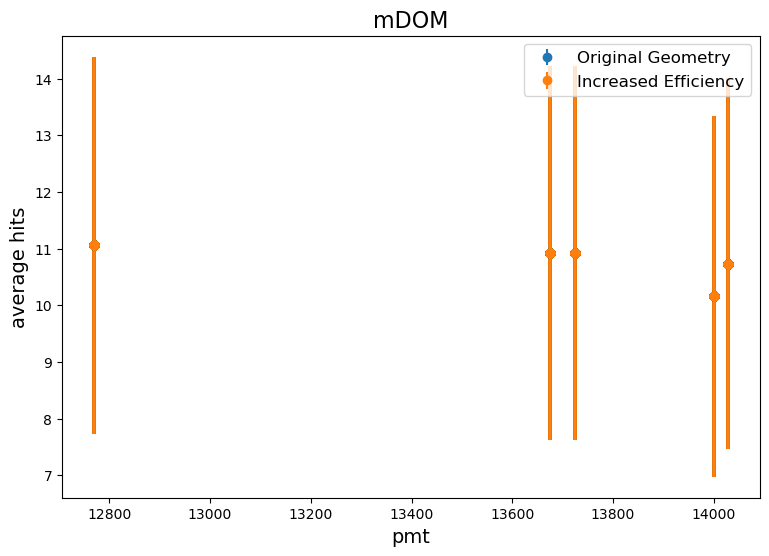

In [42]:
get_plot(mdom_mcpe, mdom_mcpeC, 10, 'mDOM')

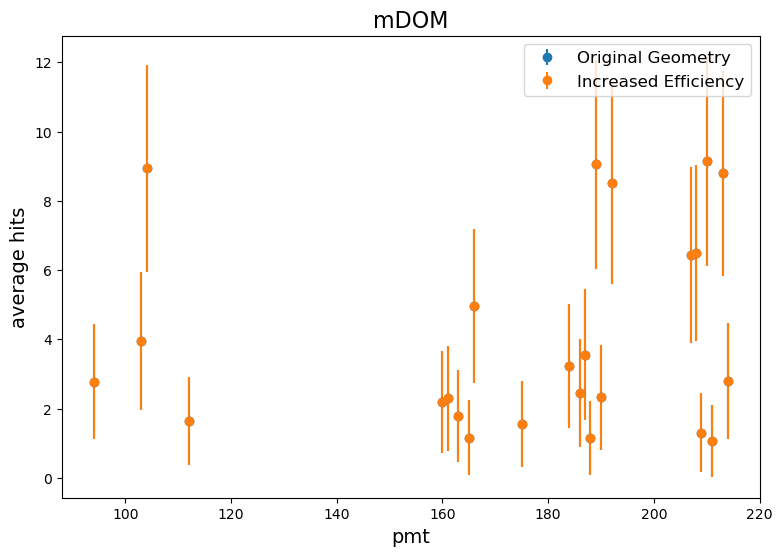

In [27]:
get_plot(mdom_mcpe, mdom_mcpeC, 1, 'mDOM')

In [ ]:
 fig, ax1 = plt.subplots()
    total_error = np.sqrt(mean_error_val**2 + mean_error_valC**2)
    diff_mean = mean_valC-mean_val
    ax1.errorbar(key_valC[mean_valC>=above], diff_mean[mean_valC>=above],
                yerr=total_error[mean_valC>=above],
                fmt='o')
    plt.show()
    
    fig, ax2 = plt.subplots()


    ax2.errorbar(key_val[mean_val>=above], mean_val[mean_val>=above],
                yerr=mean_error_val[mean_val>=above],
                fmt='o')
    plt.show()
    
    fig, ax3 = plt.subplots()
    ax3.errorbar(key_valC[mean_valC>=above], mean_valC[mean_valC>=above],
                yerr=mean_error_valC[mean_valC>=above],
                fmt='o')
    plt.show()

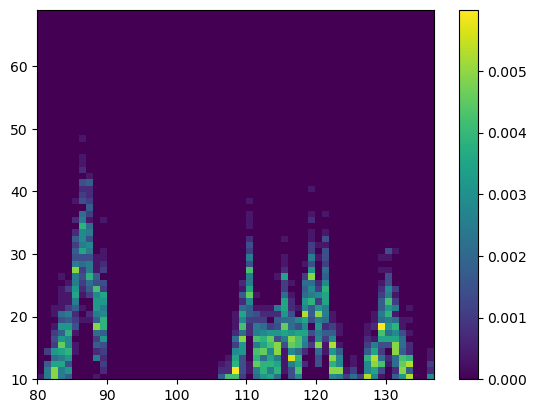

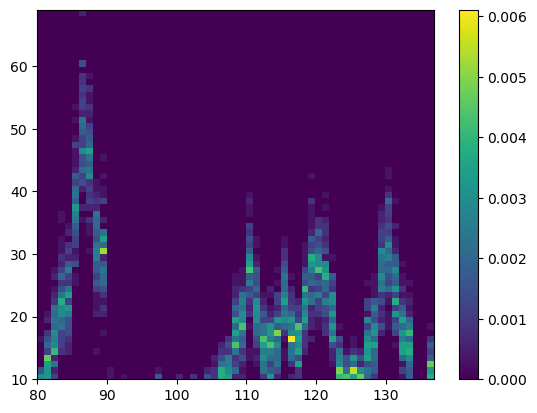

In [24]:


step_size = 5
xbins = np.arange(min(sum_omkeysC), max(sum_omkeysC) + 1, 1)
ybins = np.arange(min(hits), max(hitsC) + 1, 1)
counts, pmt_hist, hits_hist, cbar = plt.hist2d(sum_omkeys, hits, bins=[xbins, ybins], density=True)
plt.colorbar() 
plt.show()

countsC, pmt_histC, hits_histC, cbarC = plt.hist2d(sum_omkeysC, hitsC, bins=[xbins, ybins], density=True)
plt.colorbar() 
plt.show()

In [18]:
hits, sum_omkeys = get_hits(icecube_mcpe) 
hitsC, sum_omkeysC = get_hits(icecube_mcpeC) 

hits_array = np.array(hits)
omkeys_array = np.array(sum_omkeys)
mean_val = []
key_val = range(min(sum_omkeysC), max(sum_omkeysC)+1, 1)
for key in key_val:
    mean = sum(hits_array[omkeys_array==key])/100
    #mean1 = sum(hits_array[omkeys_array==key])/len(hits_array[omkeys_array==key])
    mean_val.append(mean)
    
hits_arrayC = np.array(hitsC)
omkeys_arrayC = np.array(sum_omkeysC)
mean_valC = []
key_valC = range(min(sum_omkeysC), max(sum_omkeysC)+1, 1)
for keyC in key_valC:
    meanC = sum(hits_arrayC[omkeys_arrayC==keyC])/100
    #mean1 = sum(hits_array[omkeys_array==key])/len(hits_array[omkeys_array==key])
    mean_valC.append(meanC)

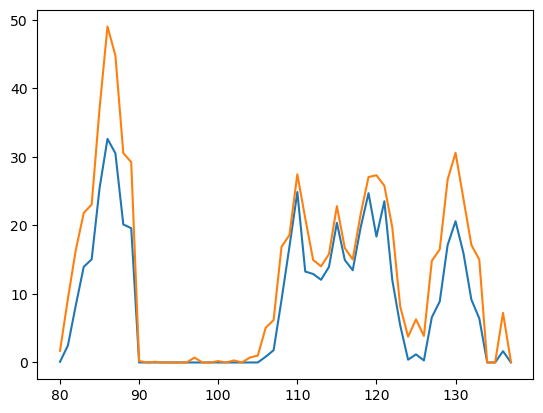

In [19]:
plt.plot(key_val, mean_val)
plt.plot(key_valC, mean_valC)

In [10]:
avg_counts = []
for i in range(0, len(pmt_hist)-1):
    if sum(counts[i]) > 0:
        #print(sum(counts[i])/len(counts[i][counts[i]>0]))
        avg_counts.append(sum(counts[i])/len(counts[i])) 
    else:
        avg_counts.append(0)

In [11]:
avg_countsC = []
for i in range(0, len(pmt_histC)-1):
    if sum(countsC[i]) > 0:
        #print(sum(counts[i])/len(counts[i][counts[i]>0]))
        avg_countsC.append(sum(countsC[i])/len(countsC[i]))
    else:
        avg_countsC.append(0)

In [12]:
pmt_hist, pmt_histC

(array([ 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
        125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
        151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
        177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202]),
 array([ 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
        125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
        151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        164, 165, 166, 167, 168, 169, 170, 171, 1

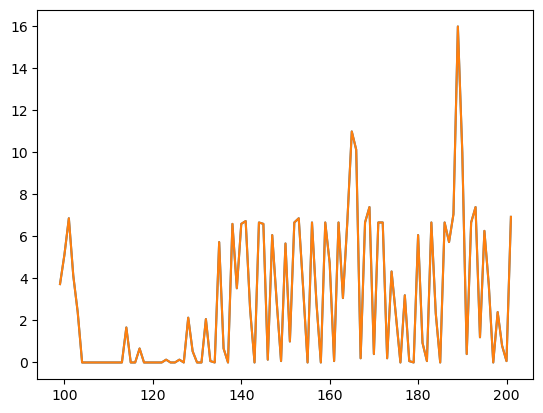

In [13]:
plt.plot(pmt_hist[:-1], avg_counts)
plt.plot(pmt_histC[:-1], avg_countsC)

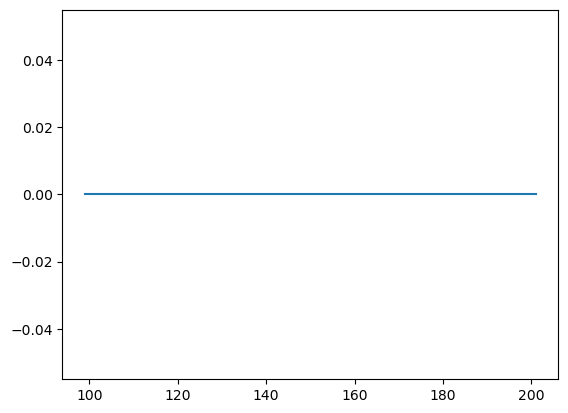

In [14]:
plt.plot(pmt_hist[:-1], np.array(avg_countsC)-np.array(avg_counts))

In [51]:
avg_counts = []
for i in range(0, len(pmt_hist)-1):
    if sum(counts[i]) > 0:
        #print(sum(counts[i])/len(counts[i][counts[i]>0]))
        avg_counts.append(sum(counts[i])/len(counts[i][counts[i]>0]))

1.0
22.0
22.0
23.0
23.75
16.666666666666668
14.285714285714286
16.666666666666668
25.0
16.5
8.0
17.0
24.0
24.75
16.666666666666668
30.333333333333332
30.333333333333332
28.666666666666668
23.5
20.0
24.25
31.333333333333332
25.0
16.666666666666668
20.0
16.666666666666668
29.666666666666668
22.5
4.0
11.0
3.0
27.0
23.0
25.0
20.0
24.5
35.5
17.666666666666668
15.0


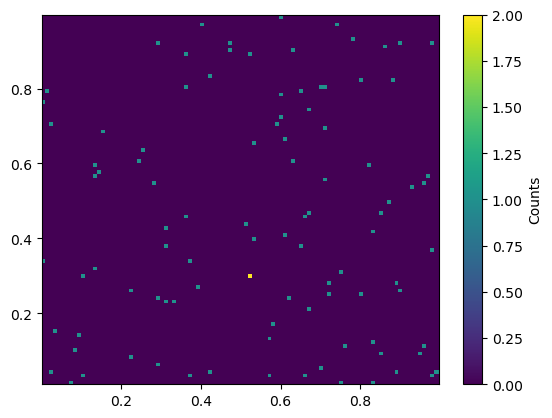

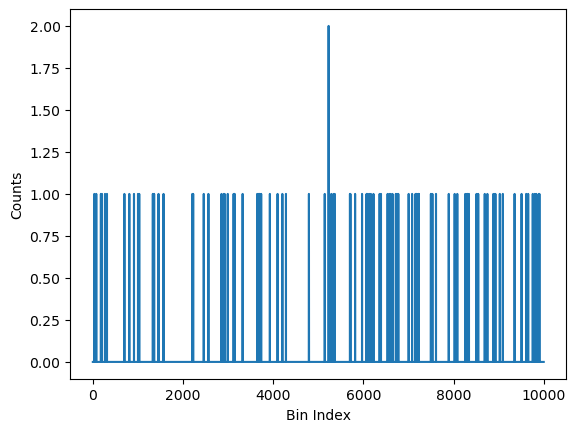

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Generate example data
x = np.random.rand(100)
y = np.random.rand(100)

# Create 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=100)

# Get counts from histogram data
counts = hist.flatten()

# Plot histogram
plt.hist2d(x, y, bins=100, cmap='viridis')
plt.colorbar(label='Counts')  # Add colorbar with label

# Plot counts in another plot
plt.figure()
plt.plot(counts)
plt.xlabel('Bin Index')
plt.ylabel('Counts')

plt.show()

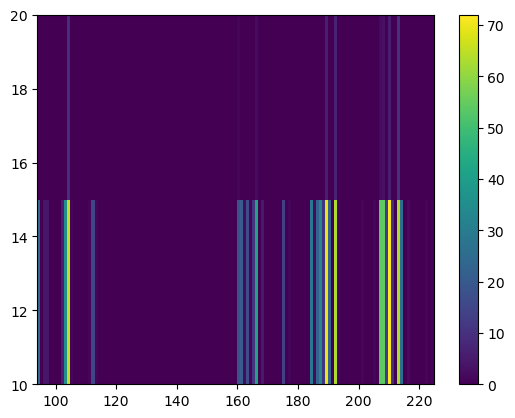

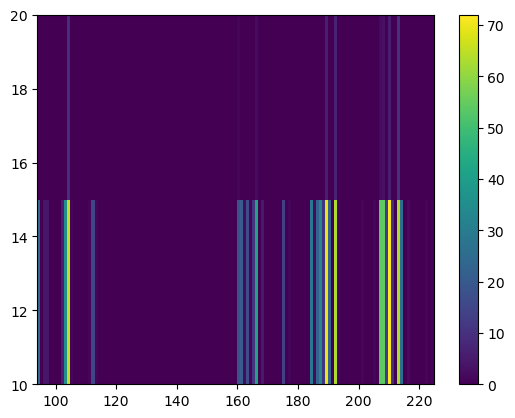

In [8]:
hits, sum_omkeys = get_hits(mdom_mcpe) 
hitsC, sum_Comkeys = get_hits(mdom_Cmcpe) 

step_size = 5
ybins = np.arange(min(hits), max(hitsC) + step_size, step_size)
plt.hist2d(sum_omkeys, hits, bins=[max(sum_omkeys)-min(sum_omkeys), ybins])
plt.colorbar() 
plt.show()

plt.hist2d(sum_Comkeys, hitsC, bins=[max(sum_Comkeys)-min(sum_Comkeys), ybins])
plt.colorbar() 
plt.show()

In [ ]:
count

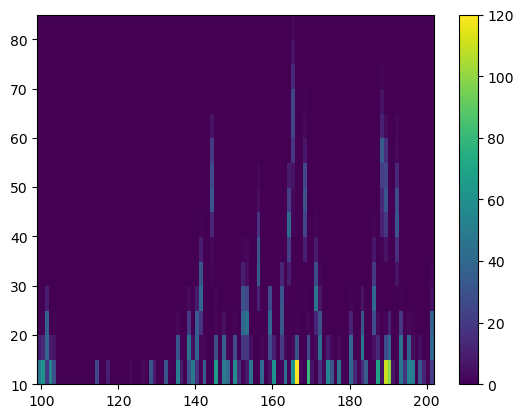

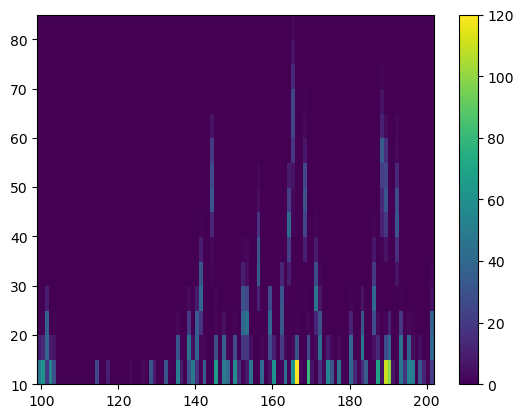

In [9]:
hits, sum_omkeys = get_hits(degg_mcpe) 
hitsC, sum_Comkeys = get_hits(degg_Cmcpe) 

step_size = 5
ybins = np.arange(min(hits), max(hitsC) + step_size, step_size)
plt.hist2d(sum_omkeys, hits, bins=[max(sum_omkeys)-min(sum_omkeys), ybins])
plt.colorbar() 
plt.show()

plt.hist2d(sum_Comkeys, hitsC, bins=[max(sum_Comkeys)-min(sum_Comkeys), ybins])
plt.colorbar() 
plt.show()

In [ ]:
step_size = 5
ybins = np.arange(min(hits), max(hits) + step_size, step_size)
plt.hist2d(sum_omkeys, hits, bins=[max(sum_omkeys)-min(sum_omkeys), ybins])
plt.colorbar() 

In [ ]:
files = sorted(glob('../I3Files/step3_UpdatedGeo/simple_track_posChanged_step3_*.i3.gz'))

icecube_mcpe, mdom_mcpe, degg_mcpe, pdom_mcpe = [], [], [], []
for file in files[0:70]:
    infile = dataio.I3File(file)
    
    while infile.more():
        frame = infile.pop_frame()
        if "I3MCPESeriesMap_IceCube" in frame:
            icecube_mcpe.append(frame["I3MCPESeriesMap_IceCube"])
            mdom_mcpe.append(frame["I3MCPESeriesMap_mDOM"])
            degg_mcpe.append(frame["I3MCPESeriesMap_DEgg"])
            pdom_mcpe.append(frame["I3MCPESeriesMap_PDOM"])
                

In [72]:
strings = [79, 92, 93]
hits, sum_omkeys = [], []
for mcpe_map in icecube_mcpe:
    for omkey, mcpe  in mcpe_map.items():
        if omkey[0] in strings:
            if len(mcpe) >= 10:
                #print(sum(omkey), omkey[2])
                hits.append(len(mcpe))
                sum_omkeys.append(sum(omkey))

In [73]:
max(sum_omkeys)-min(sum_omkeys), max(hits)-min(hits)

(57, 59)

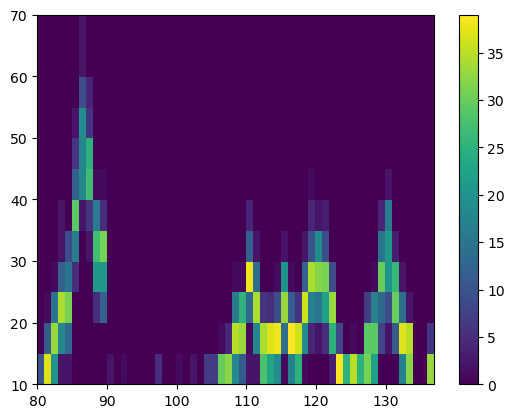

In [74]:
step_size = 5
ybins = np.arange(min(hits), max(hits) + step_size, step_size)
plt.hist2d(sum_omkeys, hits, bins=[max(sum_omkeys)-min(sum_omkeys), ybins])
plt.colorbar() 

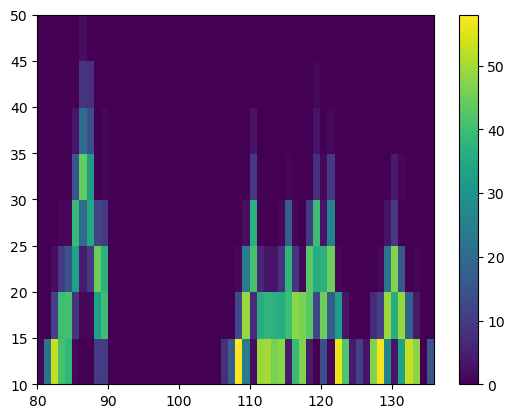

In [69]:
step_size = 5
ybins = np.arange(min(hits), max(hits) + step_size, step_size)
plt.hist2d(sum_omkeys, hits, bins=[max(sum_omkeys)-min(sum_omkeys), ybins])
plt.colorbar() 

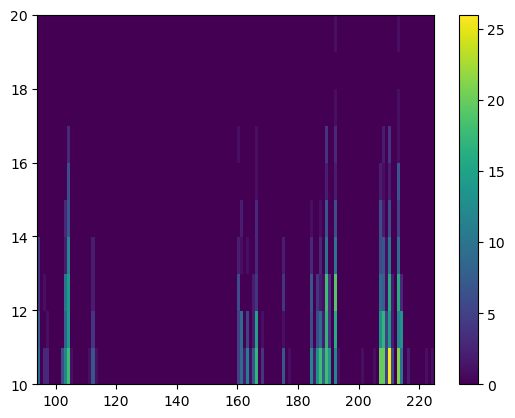

In [50]:
strings = [79, 92, 93]
hits, sum_omkeys = [], []
for mcpe_map in mdom_mcpe:
    for omkey, mcpe  in mcpe_map.items():
        if omkey[0] in strings:
            if len(mcpe) >= 10:
                #print(sum(omkey), omkey[2])
                hits.append(len(mcpe))
                sum_omkeys.append(sum(omkey))
                
plt.hist2d(sum_omkeys, hits, bins=[max(sum_omkeys)-min(sum_omkeys), max(hits)-min(hits)])
plt.colorbar() 

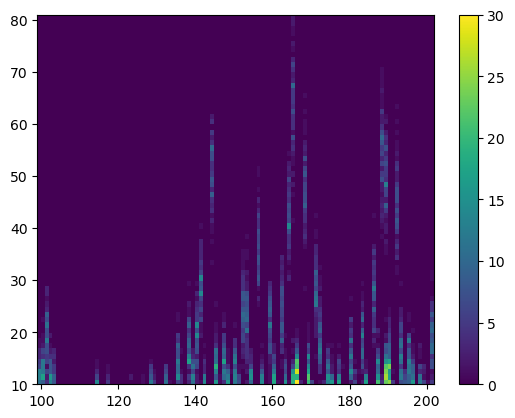

In [51]:
strings = [79, 92, 93]
hits, sum_omkeys = [], []
for mcpe_map in degg_mcpe:
    for omkey, mcpe  in mcpe_map.items():
        if omkey[0] in strings:
            if len(mcpe) >= 10:
                #print(sum(omkey), omkey[2])
                hits.append(len(mcpe))
                sum_omkeys.append(sum(omkey))
                
plt.hist2d(sum_omkeys, hits, bins=[max(sum_omkeys)-min(sum_omkeys), max(hits)-min(hits)])
plt.colorbar() 

In [25]:
def omkey_mcpe(items, strings):
    hits = []
    string = []
    DOM = []
    PMT = []
    for omkey, mcpe  in items:
        if omkey[0] in strings:
            hits.append(len(mcpe))
            string.append(omkey[0])
            DOM.append(omkey[1])
            PMT.append(omkey[2])
        
    return hits, string, DOM, PMT
    
def get_hits(input_file, DOM_type, strings):
    file = dataio.I3File(input_file)
    
    while file.more():
        frame = file.pop_frame()
        if "I3MCPESeriesMap_IceCube" in frame:
            if DOM_type == 'IceCube':
                DOM = frame["I3MCPESeriesMap_IceCube"]
            if DOM_type == 'mDOM':
                DOM = frame["I3MCPESeriesMap_mDOM"]
            if DOM_type == 'DEgg':
                DOM = frame["I3MCPESeriesMap_DEgg"]
            if DOM_type == 'PDOM':
                DOM = frame["I3MCPESeriesMap_PDOM"]
            
    hits, string, DOM, PMT = omkey_mcpe(DOM.items(), strings)
    
    return hits, string, DOM, PMT

In [ ]:
strings = [79]
total_hits = []
total_DOMs = []
for file in files:
    infile = dataio.I3File(file)
    hits, string, DOM, PMT = get_hits(input_file=infile, DOM_type='IceCube', strings=strings)
    total_hits.append(hits)
    total_DOMs.append(DOM)

In [11]:


file = dataio.I3File('../I3Files/simple_track_posChanged_step3.i3.gz')

num_hits_file = []
while file.more():
    frame = file.pop_frame()
    if "I3MCPESeriesMap_IceCube" in frame:
        
        icecube = frame["I3MCPESeriesMap_PDOM"]
        #print("IceCube:", frame["I3MCPESeriesMap_IceCube"].keys())
        #print("DEgg:", frame["I3MCPESeriesMap_DEgg"].keys())
        #print("mDOM:", frame["I3MCPESeriesMap_mDOM"].keys())
        #print("PDOM:", frame["I3MCPESeriesMap_PDOM"].keys())

In [10]:
for omkey, mcpe  in icecube.items():
    if len(mcpe) > 10:
        print(omkey, len(mcpe))
    #for pulse in mcpe:
        #print(omkey, pulse)

OMKey(92,1,0) 20


IceCube string 79
DEgg string 92, some in 93
mDOM string 92
PDOM string 92